# Use Correlation to predict Market Index
Market Index consists of a list of major companies stock price. There should be a correlation between their prices. Here I would like to use the Machine Learning Model (LSTM) to predict the market index with the historical data of certain stocks.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Collection
I use the python package yfinance to get the daily stock price. I downloaded 3-year figures including “Open”, “Close”, “High”, “Low”, and “Volume”

In [2]:
!pip install yfinance

You should consider upgrading via the '/Users/kahingleung/PycharmProjects/mylightning/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
from time import time
from datetime import datetime
import numpy as np
import pandas as pd
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray import tune
# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pickle

# Neural Networks
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger

# Plotting
import matplotlib.pyplot as plt
import json
import os
from os import path
import yfinance as yf
import math

# Data Preprocessing
I defined the class "TimeseriesDataset" to geneate the sequence data using rolloing window of size "seq_len"

In [4]:
class TimeseriesDataset(Dataset):
    '''
    Custom Dataset subclass.
    Serves as input to DataLoader to transform X
      into sequence data using rolling window.
    DataLoader using this dataset will output batches
      of `(batch_size, seq_len, n_features)` shape.
    Suitable as an input to RNNs.
    '''
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])


# Feature Engineering

MyDataModule will perform the data preparation and feature engineering in the function: setup()

1. The target variable of the prediction is the Index ETL close price rate of return of the next day.
1. Since the value of the stock volume is too large, I transformed it into log(10).
1. Since it is assumed that the price of the index ETL will depends on the historical stock price, I used the figures: “Open”, “Close”, “High”, “Low”, and “Volume” to construct the features.
1. For each column in [“Open”, “Close”, “High”, “Low”, “Volume”], I computed the 5-day lag, which is the previous-i-day figure (i ranges from 1–5).
1. Construct PCA transform for all the lag-i-values in [“Open”, “Close”, “High”, “Low”, “Volume”], totally 5*5 features.
1. Use the first 3 PCA components as the final features because the first 3 components already explained over 80% of the total variance.

Finally output the 3 PCA features and the target variable through dataloader.  I use about 80% for model training, and 20% unseen data for model testing. 


In [5]:
class MyDataModule(pl.LightningDataModule):
    '''
    PyTorch Lighting DataModule subclass:
    https://pytorch-lightning.readthedocs.io/en/latest/datamodules.html

    Serves the purpose of aggregating all data loading
      and processing work in one place.
    '''

    def __init__(self, sym01, sym02,period, seq_len=1, batch_size=128, num_workers=0):
        super().__init__()
        self.reset(sym01, sym02, period, seq_len=1, batch_size=128, num_workers=0)

    def reset(self, sym01, sym02, period, seq_len=1, batch_size=128, num_workers=0):
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.X_train = None
        self.y_train = None
        self.X_val = None
        self.y_val = None
        self.X_test = None
        self.y_test = None
        self.columns = None
        self.preprocessing = None
        self.testsize = 0
        self.sym01 = sym01
        self.sym02 = sym02
        self.period = period
        self.isreset = 1
        self.lastdata = None

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        '''
        Data is resampled to hourly intervals.
        Both 'np.nan' and '?' are converted to 'np.nan'
        'Date' and 'Time' columns are merged into 'dt' index
        '''
        print("reset is:",self.isreset)
        if stage == 'fit' and self.X_train is not None:
            print("pass setup", self.isreset)
            return
        if stage == 'test' and self.X_test is not None:
            print("pass setup", self.isreset)
            return
        #if stage is None and self.X_train is not None and self.X_test is not None:
            #return
        custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
        dir = '/Users/kahingleung/PycharmProjects/mylightning/'
        if path.exists(dir+self.sym01+'.csv'):
            print("reading file",dir+self.sym01+'.csv')
            hist1 = pd.read_csv(dir+self.sym01+'.csv',header=0,parse_dates=['Date'],date_parser=custom_date_parser)
            #hist1 = pd.read_csv(dir+sym01+'.csv',header=0)
            #print(hist1)
        else:
            ticker1 = yf.Ticker(self.sym01)
            hist1 = ticker1.history(period=self.period)
            hist1 = hist1.dropna().reset_index()
            hist1.to_csv(dir+self.sym01+'.csv',index=False)
        if path.exists(dir+self.sym02+'.csv'):
            print("reading file",dir+self.sym02+'.csv')
            hist2 = pd.read_csv(dir+self.sym02+'.csv',header=0,parse_dates=['Date'],date_parser=custom_date_parser)
            #hist2 = pd.read_csv(dir+sym02+'.csv',header=0)
            #print(hist2)
        else:
            ticker2 = yf.Ticker(self.sym02)
            hist2 = ticker2.history(period=self.period)
            hist2 = hist2.dropna().reset_index()
            hist2.to_csv(dir+self.sym02 + '.csv', index=False)
        df = hist1.merge(hist2, left_on='Date', right_on='Date').reset_index()
        #df['date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))
        #df['year-month'] = df['Date'].apply(lambda x: int((x.year - y) * 12 + x.month))
        df['year'] = df['Date'].apply(lambda x: int(x.year))
        df['month'] = df['Date'].apply(lambda x: int(x.month))
        df['day'] = df['Date'].apply(lambda x: int(x.day))
        df['log-vol'] = df['Volume_x'].apply(lambda x: math.log(1 + x))
        tgt = 'close-y-next-diff'
        df[tgt] = df['Close_y'].shift(-1)
        df[tgt] = df[[tgt, 'Close_y']].apply(lambda x: (x[tgt] - x['Close_y'])*100/x['Close_y'], axis=1)
        print(df.columns)
        lag=5
        for f in ['Open_x','Close_x','High_x','Low_x','log-vol']:
            for i in range(1,lag+1):
                col = f +'-over-lag-'+ str(i)
                df[col] = df[f].shift(i)
                df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)
        print("last date is",df['Date'].iloc[-1])
        last = df.iloc[-1*self.seq_len:].copy()
        df = df.replace([np.inf, -np.inf], np.nan).dropna().reset_index()
        pca_features = [f for f in df.columns if 'lag' in f]
        print("pca features:",pca_features)
        X = df[pca_features].values
        pca = PCA(n_components=3)
        pca.fit(X)
        X_reduced = pca.transform(X)
        with open(self.sym01+'_pca.pkl', 'wb') as pickle_file:
            pickle.dump(pca, pickle_file)
        #print("pca transform",last[pca_features].values.reshape(1,-1))
        last_pca = pca.transform(last[pca_features].values)
        self.lastdata = last_pca
        print("pca explained var",sum(pca.explained_variance_ratio_))
        print("last pca", last_pca)
        pf = pd.DataFrame(X_reduced, columns=['PCA1', 'PCA2','PCA3'])
        print("pca len",len(pf))
        df['PCA1'] = pf['PCA1']
        df['PCA2'] = pf['PCA2']
        df['PCA3'] = pf['PCA3']
        print("df len",len(df.index))
        #print("last data is",df[['Date','PCA1','PCA2','PCA3',tgt]].iloc[-5:])
        n = len(df.index)
        t = int(n*0.8)
        #features = ['PCA1', 'PCA2', 'PCA11', 'PCA22', 'PCA12', 'log-vol']
        features = ['PCA1', 'PCA2', 'PCA3']
        #features = ['Close_x', 'Open_x', 'High_x', 'Low_x', 'Close_y', 'log-vol']
        label = [tgt]

        xtrain = df[features + label].iloc[:t]
        xtest = df[features + label].iloc[t:]
        #print("data size",xtrain.size, xtest.size)

        X_train = xtrain.iloc[:-50]
        X_val = xtrain.iloc[-50:]

        if stage == 'fit' or stage is None:
            self.X_train = X_train[features].values
            self.y_train = X_train[label].values.reshape((-1, 1))
            self.X_val = X_val[features].values
            self.y_val = X_val[label].values.reshape((-1, 1))

        if stage == 'test' or stage is None:
            self.X_test = xtest[features].values
            self.y_test = xtest[label].values.reshape((-1, 1))

    def train_dataloader(self):
        train_dataset = TimeseriesDataset(self.X_train,
                                          self.y_train,
                                          seq_len=self.seq_len)
        train_loader = DataLoader(train_dataset,
                                  batch_size=self.batch_size,
                                  shuffle=False,
                                  num_workers=self.num_workers)

        return train_loader

    def val_dataloader(self):
        val_dataset = TimeseriesDataset(self.X_val,
                                        self.y_val,
                                        seq_len=self.seq_len)
        val_loader = DataLoader(val_dataset,
                                batch_size=self.batch_size,
                                shuffle=False,
                                num_workers=self.num_workers)

        return val_loader

    def test_dataloader(self):
        #print(self.X_test)
        #print(self.y_test)
        test_dataset = TimeseriesDataset(self.X_test,
                                         self.y_test,
                                         seq_len=self.seq_len)
        test_loader = DataLoader(test_dataset,
                                 batch_size=self.batch_size,
                                 shuffle=False,
                                 num_workers=self.num_workers)

        return test_loader

    def today_dataloader(self):
        #print(self.X_test)
        #print(self.y_test)
        today_dataset = TimeseriesDataset(self.lastdata,
                                         np.zeros(self.seq_len),
                                         seq_len=self.seq_len)
        today_loader = DataLoader(today_dataset,
                                 batch_size=1,
                                 shuffle=False,
                                 num_workers=self.num_workers)

        return today_loader


# LSTM Model

In [6]:
class LSTMRegressor(pl.LightningModule):
    '''
    Standard PyTorch Lightning module:
    https://pytorch-lightning.readthedocs.io/en/latest/lightning_module.html
    '''

    def __init__(self,
                 n_features,
                 hidden_size,
                 seq_len,
                 batch_size,
                 num_layers,
                 dropout,
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            dropout=dropout,
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # lstm_out = (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:, -1])
        #y_pred = torch.relu(y_pred)
        return y_pred

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        #print("test_step gets",x,y)
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('test_loss', loss)
        return loss
    def validation_epoch_end(self, outputs):
        avg_loss = sum(outputs)/len(outputs)
        self.log("ptl/val_loss", avg_loss)
    def test_epoch_end(self, outputs):
        avg_loss = sum(outputs)/len(outputs)
        self.log("ptl/test_loss", avg_loss)

# Model Training and Testing

In [7]:
def myTrain(config,num_epochs,sym01,sym02,period):
    p = dict(
        seq_len = config['seq_len'],
        batch_size = config['batch_size'],
        criterion = nn.MSELoss(),
        max_epochs = num_epochs,
        n_features = 3,
        hidden_size = config['hidden_size'],
        num_layers = config['num_layers'],
        dropout = config['dropout'],
        learning_rate = config['lr']
    )
    print("myTrain parameters:",sym01,sym02,period)

    seed_everything(1)

    csv_logger = CSVLogger('./', name='lstm', version='0'),
    metrics = {"loss": "ptl/val_loss"}
    trainer = Trainer(
        max_epochs=p['max_epochs'],
        logger=csv_logger,
        callbacks=[TuneReportCallback(metrics, on="validation_end")]
        #gpus=1,
        #row_log_interval=1,
        #progress_bar_refresh_rate=2,
    )
    model = LSTMRegressor(
        n_features = p['n_features'],
        hidden_size = p['hidden_size'],
        seq_len = p['seq_len'],
        batch_size = p['batch_size'],
        criterion = p['criterion'],
        num_layers = p['num_layers'],
        dropout = p['dropout'],
        learning_rate = p['learning_rate']
    )

    dm = MyDataModule(
        sym01=sym01,
        sym02=sym02,
        period=period,
        seq_len = p['seq_len'],
        batch_size = p['batch_size']
    )
    dm.reset(
        sym01=sym01,
        sym02=sym02,
        period=period,
        seq_len = p['seq_len'],
        batch_size = p['batch_size']
    )
    dm.setup('test')
    trainer.fit(model, dm)
    testresult = trainer.test(model, datamodule=dm)
    trainer.save_checkpoint(sym01+"-lstm.ckpt")
    print(testresult)
    return model

# Hyper-parameter tuning 
I used the package Ray Tune for the hyper-parameter tuning of the pytorch model. The hyper-parameters includes:
1. sequence length of the time series
1. no. of hidden states in the LSTM layer
1. batch size for the model training
1. dropout rate for the LSTM output
1. learning rate (lr) for model training
1. no. of LSTM layers

In [8]:
def hypertune(num_samples, num_epochs, sym01, sym02, period):
    config = {
        "seq_len": tune.choice([5, 10]),
        "hidden_size": tune.choice([10, 50, 100]),
        "batch_size": tune.choice([30,60]),
        "dropout": tune.choice([0.1, 0.2]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "num_layers": tune.choice([2, 3, 4])
    }
    trainable = tune.with_parameters(
        myTrain,
        num_epochs=num_epochs,
        sym01=sym01,
        sym02=sym02,
        period=period,
    )
    analysis = tune.run(
        trainable,
        resources_per_trial={
            "cpu": 1,
        },
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        name="tune_lstm")
    print("tuning finished")
    return analysis.best_config

# Performance evaluation
Although the predicted value of the model is the future rate of return of the market index, and the loss function is MSE, we only focus on the accuracy to evaluate the performance.

It is because in the real trading situation, it only concerns whether it makes profit or lose. If it is predicted to rise, and it actually rises, the trade has made profit. If it is predicted to drop, and it actually dropped, we can still make profit by buying the inverse ETF.

However, for the MSE, the difference of +0.1% and -0.1% is very small, but it is actually a finance loss for trading. If the direction (rise/drop) is predicted correctly, say the predicted value is +0.3%, but the actual rise is just +0.1%, the difference is as the same as the previous case (0.2%), but the trade is still a profit.

In [9]:
def getAcc(p,y):
    n = len(p)
    total = 0
    hit = 0
    for i in range(n):
        total = total + 1
        if p[i][0]*y[i][0] > 0:
            hit = hit + 1

    return hit*100/total

# Trading Strategy and Profit/Loss calculation
If the predicted rate of return (p[i][0]) is postive, we will buy the index ETF at the market open, and then sell it at the market end of the same day, taking the acutal return (y[i][0]) as P/L.
The function "buyAcc()" is to calculate the daily P/L (delta).  It assume the order executed is bounded with take-profit limit price and stop-loss limit at 3%.
Finally it returns the daily average.

In [10]:
def buyAcc(p,y):
    n = len(p)
    total = 0
    hit = 0
    bal = 0
    for i in range(n):
        if p[i][0] > 0:
            total = total + 1
            if y[i][0] > 0:
                hit = hit + 1
                delta = min(y[i][0],3)
            else:
                delta = max(y[i][0],-3)

            bal = bal + delta

    if total == 0 :
        return 0
    return bal/total

# Main Test Run
Tune the hyper-parameter
Train the model again with the best config
get the testing data fro the dataloader
Perform the prediction on testing data
Evaluate the performance by calcuting the accuracy (acc), and the P/L (score)

In [11]:
def mainTest(num_samples,num_epochs,sym01,sym02,period):
    best_config = hypertune(num_samples,num_epochs,sym01,sym02,period)
    with open(sym01+'-best.json','w') as outfile:
        json.dump(best_config,outfile)
    print(best_config)
    model = myTrain(best_config,num_epochs*10,sym01,sym02,period)
    model.eval()
    model.freeze()
    print("testing final result")
    testdm = MyDataModule(
        sym01=sym01,
        sym02=sym02,
        period=period,
        seq_len=best_config['seq_len'],
        batch_size=best_config['batch_size']
    )
    testdm.reset(
        sym01=sym01,
        sym02=sym02,
        period=period,
        seq_len = best_config['seq_len'],
        batch_size = best_config['batch_size']
    )
    testdm.setup('test')
    loader = testdm.test_dataloader()
    mae = []
    mse = []
    predictions =[]
    truth = []
    for xtest, labels in iter(loader):
        y_hat = model(xtest)
        mae.append(mean_absolute_error(labels,y_hat))
        mse.append(mean_squared_error(labels,y_hat))
        predictions.append(y_hat)
        truth.append(labels)

    p=np.concatenate(predictions)
    y=np.concatenate(truth)
    print("final result")
    print("mae =",mean_absolute_error(y,p))
    print("mse =",mean_squared_error(y,p))
    score = buyAcc(p,y)
    acc = getAcc(p,y)
    print("acc =",score)
    plt.clf()
    plt.plot(p,'r')
    plt.plot(y,'y')
    #plt.show()
    plt.savefig(sym01+'-'+sym02+'-test.png')

    loader = testdm.today_dataloader()
    for today, labels in iter(loader):
        print("predict tmr from ",today)
        y_tmr = model(today)
        y_tmr = y_tmr[0][0].numpy()
        print("tmr return is", y_tmr)
    return (score,acc,y_tmr)

# Comparison
For a list of 10 selected stocks, perform model training and testing, and compare the metrics returned above. Here is the final result.
Using Mei Tuan (3690) to predict HSI can achieve the highest accuracy of 58%. Tencent (700) and Ping An (2318) can also achieve a high accuracy of ~56%.

In [12]:
!pip install "ray[tune]"

You should consider upgrading via the '/Users/kahingleung/PycharmProjects/mylightning/venv/bin/python -m pip install --upgrade pip' command.


['0005.HK', '2318.HK', '1398.HK', '2628.HK', '0823.HK', '0700.HK', '1810.HK', '0175.HK', '3690.HK', '2269.HK']


2021-01-01 20:13:07,788	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265
2021-01-01 20:13:09,365	WARNING function_runner.py:539 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_b62f1_00000,RUNNING,,60,0.2,100,0.00176802,2,10


(pid=10958) myTrain parameters: 0005.HK 7200.HK 3y
(pid=10958) reset is: 1
(pid=10958) reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
(pid=10957) myTrain parameters: 0005.HK 7200.HK 3y
(pid=10957) reset is: 1
(pid=10957) reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
(pid=10955) myTrain parameters: 0005.HK 7200.HK 3y
(pid=10955) reset is: 1
(pid=10955) reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
(pid=10954) myTrain parameters: 0005.HK 7200.HK 3y
(pid=10954) reset is: 1
(pid=10954) reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
(pid=10952) myTrain parameters: 0005.HK 7200.HK 3y
(pid=10952) reset is: 1
(pid=10952) reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
(pid=10956) myTrain parameters: 0005.HK 7200.HK 3y
(pid=10956) reset is: 1
(pid=10956) reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
(pid=10949) myTrain parameters: 0005.HK 7200.H

(pid=10955) GPU available: False, used: False
(pid=10955) TPU available: None, using: 0 TPU cores
(pid=10954) GPU available: False, used: False
(pid=10954) TPU available: None, using: 0 TPU cores
(pid=10957) GPU available: False, used: False
(pid=10957) TPU available: None, using: 0 TPU cores
(pid=10958) GPU available: False, used: False
(pid=10958) TPU available: None, using: 0 TPU cores
(pid=10951) GPU available: False, used: False
(pid=10951) TPU available: None, using: 0 TPU cores
(pid=10953) GPU available: False, used: False
(pid=10953) TPU available: None, using: 0 TPU cores
(pid=10948) GPU available: False, used: False
(pid=10948) TPU available: None, using: 0 TPU cores
(pid=10949) GPU available: False, used: False
(pid=10949) TPU available: None, using: 0 TPU cores
(pid=10952) GPU available: False, used: False
(pid=10952) TPU available: None, using: 0 TPU cores
(pid=10956) GPU available: False, used: False
(pid=10956) TPU available: None, using: 0 TPU cores


(pid=10955) last date is 2020-12-31 00:00:00
(pid=10955) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=10955) pca explained var 0.8308241563361743
(pid=10955) last pca [[  1.34907881  -2.99280665   1.85556698]
(pid=10955)  [  1.66179632  -8.82245305   1.1605914 ]
(pid=10955)  [ 12.88402658   4.23654024  -4.4519563 ]
(pid=10955)  [ 17.51772954  -5.95082102  -3.91435813]
(pid=10955)  [ 13.32721534 -12.54907853   1.91954834]
(pid=10955)  [  1.75759778  -3.28419666   8.50458973]
(pid=10955)  [ -

(pid=10958) last date is 2020-12-31 00:00:00
(pid=10958) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=10958) pca explained var 0.8308241563362904
(pid=10958) last pca [[  1.34907881  -2.99280664   1.8555668 ]
(pid=10958)  [  1.66179632  -8.82245305   1.16059141]
(pid=10958)  [ 12.88402658   4.23654024  -4.45195636]
(pid=10958)  [ 17.51772954  -5.95082102  -3.91435812]
(pid=10958)  [ 13.32721534 -12.54907853   1.91954836]
(pid=10958)  [  1.75759778  -3.28419666   8.5045897 ]
(pid=10958)  [ -

(pid=10955) 
(pid=10955)   | Name      | Type    | Params
(pid=10955) --------------------------------------
(pid=10955) 0 | criterion | MSELoss | 0     
(pid=10955) 1 | lstm      | LSTM    | 122 K 
(pid=10955) 2 | linear    | Linear  | 101   
(pid=10955) --------------------------------------
(pid=10955) 122 K     Trainable params
(pid=10955) 0         Non-trainable params
(pid=10955) 122 K     Total params
(pid=10955) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10955)   warnings.warn(*args, **kwargs)
(pid=10951) 
(pid=10951)   | Name      | Type    | Params
(pid=10951) --------------------------------------
(pid=10951) 0 | criterion | MSE

Epoch 0:  40%|████      | 8/20 [00:00<00:00, 49.64it/s, loss=6.95, v_num=0]
Result for _inner_b62f1_00004:
  date: 2021-01-01_20-13-13
  done: false
  experiment_id: 1f3c95406c9c49d88db6dab675a22132
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.997852325439453
  node_ip: 192.168.1.25
  pid: 10956
  time_since_restore: 1.4860291481018066
  time_this_iter_s: 1.4860291481018066
  time_total_s: 1.4860291481018066
  timestamp: 1609503193
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b62f1_00004
  
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 42.89it/s, loss=5.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 44.37it/s, loss=6.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  75%|███████▌  | 15/20 [00:00<00:00, 68.29it/s, loss=5.66, v_num=0]

  date: 2021-01-01_20-13-13
  done: false
  experiment_id: e64e8d7d00494cc197ba0f597bfe149e
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.816759109

  
Result for _inner_b62f1_00008:
  date: 2021-01-01_20-13-13
  done: false
  experiment_id: 81fe0af7f064492db1084e94656dac3e
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 21.366554260253906
  node_ip: 192.168.1.25
  pid: 10949
  time_since_restore: 1.5965418815612793
  time_this_iter_s: 1.5965418815612793
  time_total_s: 1.5965418815612793
  timestamp: 1609503193
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b62f1_00008
  
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 52.82it/s, loss=6.15, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 54.87it/s, loss=6.15, v_num=0]
                              
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 49.66it/s, loss=5.7, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s, loss=6.15, v_num=0]         
(pid=10952) 
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 87.63it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|

Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 73.28it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 32.59it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 48.76it/s, loss=5.55, v_num=0]
                              
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 59.89it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  10%|█         | 1/10 [00:00<00:00, 51.46it/s, loss=5.83, v_num=0]
(pid=10948) 
Validating: 0it [00:00, ?it/s]
Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s, loss=5.55, v_num=0]
Result for _inner_b62f1_00007:
  date: 2021-01-01_20-13-13
  done: false
  experiment_id: b638c89ef22b443c9d848e93f5bdc71e
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.836898803710938
  node_ip: 192.168.1.25
  pid: 10948
  time_since_restore: 1.945094108581543
  time_this_iter_s: 1.945094108581543
  time_total_s: 1.945094108581543
  timestamp: 1609503193
 

Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 93.95it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 56.68it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]


Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 50.23it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 47.44it/s, loss=5.61, v_num=0]
                              
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 33.14it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  30%|███       | 3/10 [00:00<00:00, 36.64it/s, loss=5.6, v_num=0]
(pid=10958) 
Validating: 0it [00:00, ?it/s]
Epoch 5:  50%|█████     | 5/10 [00:00<00:00, 44.18it/s, loss=5.68, v_num=0]
(pid=10956) 
Validating: 0it [00:00, ?it/s]
Epoch 6:  20%|██        | 2/10 [00:00<00:00, 52.74it/s, loss=5.43, v_num=0]


Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 63.90it/s, loss=5.63, v_num=0]
                              
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 37.43it/s, loss=5.57, v_num=0]
                              
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 85.04it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 20/20 [00:00<00:00, 90.27it/s, loss=5.77, v_num=0]
                              
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 36.37it/s, loss=5.46, v_num=0]
                              
Epoch 4:  65%|██████▌   | 13/20 [00:00<00:00, 70.84it/s, loss=5.47, v_num=0]


Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 59.59it/s, loss=5.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  70%|███████   | 7/10 [00:00<00:00, 41.43it/s, loss=5.42, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_b62f1_00000,RUNNING,192.168.1.25:10955,60,0.2,100,0.00176802,2,10,5,2.72295,16.8924
_inner_b62f1_00001,RUNNING,192.168.1.25:10958,30,0.2,10,0.000214365,2,10,6,2.66077,16.7444
_inner_b62f1_00002,RUNNING,192.168.1.25:10957,60,0.2,10,0.00585761,4,10,7,2.77591,16.7233
_inner_b62f1_00003,RUNNING,192.168.1.25:10954,30,0.2,10,0.0108007,2,10,6,2.63044,16.8673
_inner_b62f1_00004,RUNNING,192.168.1.25:10956,60,0.1,50,0.00990684,2,10,8,2.79252,17.3951
_inner_b62f1_00005,RUNNING,192.168.1.25:10952,60,0.2,50,0.0051367,4,5,7,2.71164,24.1264
_inner_b62f1_00006,RUNNING,192.168.1.25:10953,30,0.1,50,0.00257003,3,5,6,2.75551,21.6128
_inner_b62f1_00007,RUNNING,192.168.1.25:10948,60,0.2,100,0.0658545,4,5,1,1.94509,22.8369
_inner_b62f1_00008,RUNNING,192.168.1.25:10949,30,0.2,50,0.00198919,4,5,4,2.53635,21.4093
_inner_b62f1_00009,RUNNING,192.168.1.25:10951,60,0.2,50,0.00298867,3,10,5,2.59599,16.9058


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 93.31it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 38.09it/s, loss=5.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 88.69it/s, loss=5.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 39.51it/s, loss=5.36, v_num=0]
                              
Epoch 7:  75%|███████▌  | 15/20 [00:00<00:00, 104.77it/s, loss=5.18, v_num=0]


Testing: 100%|██████████| 3/3 [00:00<00:00, 228.76it/s]
(pid=10956) --------------------------------------------------------------------------------
(pid=10956) DATALOADER:0 TEST RESULTS
Epoch 8:  70%|███████   | 14/20 [00:00<00:00, 105.54it/s, loss=5.17, v_num=0]
(pid=10956) {'ptl/test_loss': tensor(5.7577),
(pid=10956)  'ptl/val_loss': tensor(17.5704),
(pid=10956)  'test_loss': tensor(6.3564),
(pid=10956)  
(pid=10956) 'val_loss'
(pid=10956) : 
Epoch 8:  55%|█████▌    | 11/20 [00:00<00:00, 111.67it/s, loss=5.44, v_num=0]Result for _inner_b62f1_00004:
  date: 2021-01-01_20-13-14
  done: true
  experiment_id: 1f3c95406c9c49d88db6dab675a22132
  experiment_tag: 4_batch_size=60,dropout=0.1,hidden_size=50,lr=0.0099068,num_layers=2,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 17.570371627807617
  node_ip: 192.168.1.25
  pid: 10956
  time_since_restore: 3.118551015853882
  time_this_iter_s: 0.15996885299682617
  time_total_s: 3.118551015853882
  timestamp: 160

(pid=10956) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10956)   warnings.warn(*args, **kwargs)
(pid=10952) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10952)   warnings.warn(*args, **kwargs)
(pid=10957) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_li

Result for _inner_b62f1_00005:
  date: 2021-01-01_20-13-14
  done: true
  experiment_id: e64e8d7d00494cc197ba0f597bfe149e
  experiment_tag: 5_batch_size=60,dropout=0.2,hidden_size=50,lr=0.0051367,num_layers=4,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 23.73027801513672
  node_ip: 192.168.1.25
  pid: 10952
  time_since_restore: 3.2407948970794678
  time_this_iter_s: 0.1655590534210205
  time_total_s: 3.2407948970794678
  timestamp: 1609503194
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b62f1_00005
  
Testing: 100%|██████████| 3/3 [00:00<00:00, 212.56it/s]
(pid=10952) --------------------------------------------------------------------------------
(pid=10952) DATALOADER:0 TEST RESULTS
(pid=10952) {'ptl/test_loss': tensor(5.7623),
(pid=10952)  'ptl/val_loss': tensor(23.7303),
(pid=10952)  'test_loss': tensor(6.3267),
(pid=10952)  'val_loss': tensor(23.7303)}
(pid=10952) -----------------------------------------------------------------

(pid=10954) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10954)   warnings.warn(*args, **kwargs)
(pid=10958) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10958)   warnings.warn(*args, **kwargs)


Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 78.93it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  30%|███       | 3/10 [00:00<00:00, 41.73it/s, loss=5.33, v_num=0]
Result for _inner_b62f1_00006:
  date: 2021-01-01_20-13-15
  done: true
  experiment_id: f306dbc9a1d94214b407eee4ac87ee0a
  experiment_tag: 6_batch_size=30,dropout=0.1,hidden_size=50,lr=0.00257,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 21.94589614868164
  node_ip: 192.168.1.25
  pid: 10953
  time_since_restore: 3.585577964782715
  time_this_iter_s: 0.200639009475708
  time_total_s: 3.585577964782715
  timestamp: 1609503195
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b62f1_00006
  
Testing: 100%|██████████| 5/5 [00:00<00:00, 322.36it/s]
(pid=10953) --------------------------------------------------------------------------------
(pid=10953) DATALOADER:0 TEST RESULTS
(pid=10953) {'ptl/test_loss': tensor(6.3265),
(pid=10953)  'ptl/val_loss':

(pid=10953) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10953)   warnings.warn(*args, **kwargs)
(pid=10951) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10951)   warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 3/3 [00:00<00:00, 163.18it/s]
(pid=10951) --------------------------------------------------------------------------------
(pid=10951) DATALOADER:0 TEST RESULTS
Result for _inner_b62f1_00009:
  date: 2021-01-01_20-13-15
  done: true
  experiment_id: be3a941bacc1452d80f056954a212850
  experiment_tag: 9_batch_size=60,dropout=0.2,hidden_size=50,lr=0.0029887,num_layers=3,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.36130142211914
  node_ip: 192.168.1.25
  pid: 10951
  time_since_restore: 3.7070438861846924
  time_this_iter_s: 0.24208784103393555
  time_total_s: 3.7070438861846924
  timestamp: 1609503195
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b62f1_00009
  
(pid=10951) {'ptl/test_loss': tensor(5.3964),
(pid=10951)  'ptl/val_loss': tensor(16.3613),
(pid=10951)  
Epoch 8:  55%|█████▌    | 11/20 [00:00<00:00, 64.71it/s, loss=5.34, v_num=0]
(pid=10951) 'test_loss': tensor(5.9623),
(pid=10951)  'val_loss': te

(pid=10955) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10955)   warnings.warn(*args, **kwargs)
(pid=10949) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10949)   warnings.warn(*args, **kwargs)


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 55.02it/s, loss=5.51, v_num=0]
(pid=10949) 
Validating: 0it [00:00, ?it/s]
Result for _inner_b62f1_00008:
  date: 2021-01-01_20-13-15
  done: true
  experiment_id: 81fe0af7f064492db1084e94656dac3e
  experiment_tag: 8_batch_size=30,dropout=0.2,hidden_size=50,lr=0.0019892,num_layers=4,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 21.80276870727539
  node_ip: 192.168.1.25
  pid: 10949
  time_since_restore: 4.192976951599121
  time_this_iter_s: 0.34453511238098145
  time_total_s: 4.192976951599121
  timestamp: 1609503195
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b62f1_00008
  
Testing: 100%|██████████| 5/5 [00:00<00:00, 397.62it/s]
(pid=10949) --------------------------------------------------------------------------------
(pid=10949) DATALOADER:0 TEST RESULTS
(pid=10949) {'ptl/test_loss': tensor(5.7413),
(pid=10949)  'ptl/val_loss': tensor(21.8028),
(pid=10949)  'test_loss': tensor(5.9274),

(pid=10948) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10948)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_b62f1_00000,TERMINATED,,60,0.2,100,0.00176802,2,10,10,4.0561,16.2848
_inner_b62f1_00001,TERMINATED,,30,0.2,10,0.000214365,2,10,10,3.417,16.7417
_inner_b62f1_00002,TERMINATED,,60,0.2,10,0.00585761,4,10,10,3.31912,17.1637
_inner_b62f1_00003,TERMINATED,,30,0.2,10,0.0108007,2,10,10,3.37572,18.1534
_inner_b62f1_00004,TERMINATED,,60,0.1,50,0.00990684,2,10,10,3.11855,17.5704
_inner_b62f1_00005,TERMINATED,,60,0.2,50,0.0051367,4,5,10,3.24079,23.7303
_inner_b62f1_00006,TERMINATED,,30,0.1,50,0.00257003,3,5,10,3.58558,21.9459
_inner_b62f1_00007,TERMINATED,,60,0.2,100,0.0658545,4,5,10,7.63086,22.9791
_inner_b62f1_00008,TERMINATED,,30,0.2,50,0.00198919,4,5,10,4.19298,21.8028
_inner_b62f1_00009,TERMINATED,,60,0.2,50,0.00298867,3,10,10,3.70704,16.3613


2021-01-01 20:13:19,371	INFO tune.py:448 -- Total run time: 12.04 seconds (9.92 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Testing: 100%|██████████| 3/3 [00:00<00:00, 87.35it/s]
(pid=10948) --------------------------------------------------------------------------------
(pid=10948) DATALOADER:0 TEST RESULTS
(pid=10948) {'ptl/test_loss': tensor(5.8905),
(pid=10948)  'ptl/val_loss': tensor(22.9791),
(pid=10948)  'test_loss': tensor(6.5659),
(pid=10948)  'val_loss': tensor(22.9791)}
(pid=10948) --------------------------------------------------------------------------------
(pid=10948) [{'val_loss': 22.97905731201172, 'ptl/val_loss': 22.97905731201172, 'test_loss': 6.565928936004639, 'ptl/test_loss': 5.890527248382568}]
tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 60, 'dropout': 0.2, 'lr': 0.0017680208429494695, 'num_layers': 2}
myTrain parameters: 0005.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volu

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 122 K 
2 | linear    | Linear  | 101   
--------------------------------------
122 K     Trainable params
0         Non-trainable params
122 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8308241563362904
last pca [[  1.34907881  -2.99280664   1.8555668 ]
 [  1.66179632  -8.82245305   1.16059141]
 [ 12.88402658   4.23654024  -4.45195636]
 [ 17.51772954  -5.95082102  -3.91435812]
 [ 13.32721534 -12.54907853   1.91954836]
 [  1.75759778  -3.28419666   8.5045897 ]
 [ -0.35639238   7.16606261   6.25449266]
 [ -3.59982322  -1.78576913  -0.89277521]
 [ -6.34262325   1.30580821  -1.87861414

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
2021-01-01 20:13:20,194	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the cla

Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 66.09it/s, loss=5.66, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:20,348	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 67.29it/s, loss=5.57, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:20,494	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 68.49it/s, loss=5.53, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:20,637	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 69.01it/s, loss=5.46, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:20,783	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 67.94it/s, loss=5.36, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:20,928	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 66.94it/s, loss=5.25, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,078	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 65.95it/s, loss=5.13, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,229	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 67.22it/s, loss=5.03, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,375	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 69.15it/s, loss=4.9, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,518	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 9/10 [00:00<00:00, 67.97it/s, loss=4.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,665	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 9/10 [00:00<00:00, 67.78it/s, loss=4.66, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,810	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 9/10 [00:00<00:00, 70.12it/s, loss=4.5, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:21,950	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 9/10 [00:00<00:00, 69.83it/s, loss=4.34, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,090	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 9/10 [00:00<00:00, 68.60it/s, loss=4.17, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,234	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 9/10 [00:00<00:00, 67.58it/s, loss=4.02, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,379	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 9/10 [00:00<00:00, 66.62it/s, loss=3.82, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,529	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 9/10 [00:00<00:00, 67.31it/s, loss=3.57, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,675	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 9/10 [00:00<00:00, 69.33it/s, loss=3.34, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,817	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 9/10 [00:00<00:00, 68.55it/s, loss=3.13, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:22,961	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 9/10 [00:00<00:00, 68.19it/s, loss=2.9, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,105	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 9/10 [00:00<00:00, 68.91it/s, loss=2.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,248	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 9/10 [00:00<00:00, 67.04it/s, loss=2.53, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,394	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 9/10 [00:00<00:00, 68.92it/s, loss=2.31, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,537	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 9/10 [00:00<00:00, 68.35it/s, loss=2.03, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,681	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 9/10 [00:00<00:00, 68.33it/s, loss=1.85, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,825	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 9/10 [00:00<00:00, 66.83it/s, loss=1.83, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:23,972	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 9/10 [00:00<00:00, 65.72it/s, loss=1.68, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,121	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 9/10 [00:00<00:00, 66.72it/s, loss=1.43, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,270	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 9/10 [00:00<00:00, 64.88it/s, loss=1.33, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,422	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 9/10 [00:00<00:00, 67.69it/s, loss=1.23, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,568	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 9/10 [00:00<00:00, 68.77it/s, loss=1.11, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,712	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 9/10 [00:00<00:00, 68.15it/s, loss=1.04, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,856	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 9/10 [00:00<00:00, 68.94it/s, loss=1.01, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:24,999	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 9/10 [00:00<00:00, 67.22it/s, loss=0.926, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:25,144	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 9/10 [00:00<00:00, 69.78it/s, loss=0.8, v_num=0]   
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:25,286	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 9/10 [00:00<00:00, 69.81it/s, loss=0.776, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:25,427	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 9/10 [00:00<00:00, 68.82it/s, loss=0.736, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:25,570	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 9/10 [00:00<00:00, 67.99it/s, loss=0.692, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:25,714	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 9/10 [00:00<00:00, 68.05it/s, loss=0.638, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:25,859	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 9/10 [00:00<00:00, 66.71it/s, loss=0.595, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,006	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 9/10 [00:00<00:00, 68.73it/s, loss=0.592, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,151	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 9/10 [00:00<00:00, 68.41it/s, loss=0.555, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,295	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 9/10 [00:00<00:00, 68.30it/s, loss=0.494, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,439	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 9/10 [00:00<00:00, 67.98it/s, loss=0.46, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,584	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 9/10 [00:00<00:00, 68.66it/s, loss=0.447, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,727	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 9/10 [00:00<00:00, 68.86it/s, loss=0.417, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:26,870	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 9/10 [00:00<00:00, 67.80it/s, loss=0.374, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,015	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 9/10 [00:00<00:00, 70.14it/s, loss=0.373, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,155	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 9/10 [00:00<00:00, 69.44it/s, loss=0.396, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,298	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 9/10 [00:00<00:00, 68.75it/s, loss=0.402, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,441	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 9/10 [00:00<00:00, 69.93it/s, loss=0.372, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,582	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 9/10 [00:00<00:00, 69.60it/s, loss=0.329, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,722	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 9/10 [00:00<00:00, 68.32it/s, loss=0.327, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:27,867	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 9/10 [00:00<00:00, 68.52it/s, loss=0.319, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,010	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 9/10 [00:00<00:00, 68.44it/s, loss=0.307, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,155	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 9/10 [00:00<00:00, 69.52it/s, loss=0.266, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,296	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 9/10 [00:00<00:00, 69.01it/s, loss=0.258, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,439	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 9/10 [00:00<00:00, 69.33it/s, loss=0.253, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,581	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 9/10 [00:00<00:00, 68.96it/s, loss=0.247, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,724	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 9/10 [00:00<00:00, 68.93it/s, loss=0.258, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:28,868	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 9/10 [00:00<00:00, 68.70it/s, loss=0.249, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,011	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 9/10 [00:00<00:00, 69.46it/s, loss=0.232, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,153	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 9/10 [00:00<00:00, 69.25it/s, loss=0.225, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,295	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 9/10 [00:00<00:00, 69.74it/s, loss=0.214, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,437	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 9/10 [00:00<00:00, 68.95it/s, loss=0.204, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,580	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 9/10 [00:00<00:00, 68.83it/s, loss=0.211, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,723	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 9/10 [00:00<00:00, 68.53it/s, loss=0.218, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:29,866	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 9/10 [00:00<00:00, 69.49it/s, loss=0.22, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,007	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 9/10 [00:00<00:00, 69.12it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,150	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 9/10 [00:00<00:00, 68.58it/s, loss=0.211, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,294	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 9/10 [00:00<00:00, 69.71it/s, loss=0.21, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,436	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 9/10 [00:00<00:00, 67.57it/s, loss=0.191, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,581	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 9/10 [00:00<00:00, 69.69it/s, loss=0.182, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,722	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 9/10 [00:00<00:00, 70.04it/s, loss=0.187, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:30,863	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 9/10 [00:00<00:00, 69.56it/s, loss=0.186, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,005	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 9/10 [00:00<00:00, 68.24it/s, loss=0.16, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,150	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 9/10 [00:00<00:00, 68.39it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,294	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 9/10 [00:00<00:00, 69.02it/s, loss=0.166, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,437	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 9/10 [00:00<00:00, 69.05it/s, loss=0.164, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,579	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 9/10 [00:00<00:00, 67.90it/s, loss=0.164, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,724	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 9/10 [00:00<00:00, 68.86it/s, loss=0.177, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:31,867	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 9/10 [00:00<00:00, 69.34it/s, loss=0.174, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,010	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 9/10 [00:00<00:00, 67.66it/s, loss=0.162, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,155	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 9/10 [00:00<00:00, 69.19it/s, loss=0.156, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,298	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 9/10 [00:00<00:00, 69.69it/s, loss=0.158, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,439	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 9/10 [00:00<00:00, 70.07it/s, loss=0.16, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,579	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 9/10 [00:00<00:00, 69.25it/s, loss=0.153, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,722	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 9/10 [00:00<00:00, 68.17it/s, loss=0.144, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:32,866	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 9/10 [00:00<00:00, 69.08it/s, loss=0.144, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,009	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 9/10 [00:00<00:00, 69.09it/s, loss=0.142, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,151	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 9/10 [00:00<00:00, 69.75it/s, loss=0.126, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,292	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 9/10 [00:00<00:00, 70.12it/s, loss=0.12, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,433	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 9/10 [00:00<00:00, 68.23it/s, loss=0.115, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,577	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 9/10 [00:00<00:00, 69.04it/s, loss=0.124, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,721	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 9/10 [00:00<00:00, 69.02it/s, loss=0.132, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:33,864	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 9/10 [00:00<00:00, 69.67it/s, loss=0.13, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:34,005	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 9/10 [00:00<00:00, 68.85it/s, loss=0.121, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:34,148	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 9/10 [00:00<00:00, 69.26it/s, loss=0.11, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:34,290	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 9/10 [00:00<00:00, 68.92it/s, loss=0.11, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:34,435	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 3/3 [00:00<00:00, 232.48it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(9.0222),
 'ptl/val_loss': tensor(20.4269),
 'test_loss': tensor(9.0349),
 'val_loss': tensor(20.4269)}
--------------------------------------------------------------------------------
[{'val_loss': 20.42688751220703, 'ptl/val_loss': 20.42688751220703, 'test_loss': 9.034933090209961, 'ptl/test_loss': 9.022178649902344}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0005.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8308241563362835
last pca [[  1.34907881  -2.99280664   1.85556668]
 [  1.66179632  -8.82245305   1.1605913 

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_c5660_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=10947) myTrain parameters: 2318.HK 7200.HK 3y
(pid=10947) reset is: 1
(pid=10947) reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
(pid=10947) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=10950) myTrain parameters: 2318.HK 7200.HK 3y
(pid=10950) reset is: 1
(pid=10950) reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
(pid=10950) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=10947) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=10947)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=10947)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=10947)        'log-vol', 'close-y-next-diff'],
(pid=10947)       dtype='object')
(pid=10950) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=10950)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=10950) GPU available: False, used: False
(pid=10950) TPU available: None, using: 0 TPU cores
(pid=10947) GPU available: False, used: False
(pid=10947) TPU available: None, using: 0 TPU cores
(pid=11029) GPU available: False, used: False
(pid=11029) TPU available: None, using: 0 TPU cores
(pid=11030) GPU available: False, used: False
(pid=11030) TPU available: None, using: 0 TPU cores
(pid=11027) GPU available: False, used: False
(pid=11027) TPU available: None, using: 0 TPU cores
(pid=11031) GPU available: False, used: False
(pid=11031) TPU available: None, using: 0 TPU cores
(pid=11028) GPU available: False, used: False
(pid=11028) TPU available: None, using: 0 TPU cores
(pid=11026) GPU available: False, used: False
(pid=11026) TPU available: None, using: 0 TPU cores
(pid=11034) GPU available: False, used: False
(pid=11034) TPU available: None, using: 0 TPU cores
(pid=11032) GPU available: False, used: False
(pid=11032) TPU available: None, using: 0 TPU cores


(pid=11030) myTrain parameters: 2318.HK 7200.HK 3y
(pid=11030) reset is: 1
(pid=11030) reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
(pid=11030) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11029) myTrain parameters: 2318.HK 7200.HK 3y
(pid=11029) reset is: 1
(pid=11029) reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
(pid=11029) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11026) myTrain parameters: 2318.HK 7200.HK 3y
(pid=11026) reset is: 1
(pid=11026) reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
(pid=11026) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11028) myTrain parameters: 2318.HK 7200.HK 3y
(pid=11028) reset is: 1
(pid=11028) reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
(pid=11028) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11031) myTrain paramete

(pid=10947) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=10947)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=10947)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=10947)        'log-vol', 'close-y-next-diff'],
(pid=10947)       dtype='object')
(pid=10950) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=10950)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=10950)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=10950)        'log-vol', 'close-y-next-diff'],
(pid=10950)       dtype='object')
(pid=11029) last date is 2020-12-31 00:00:00
(pid=11029) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High

(pid=10950) 
(pid=10950)   | Name      | Type    | Params
(pid=10950) --------------------------------------
(pid=10950) 0 | criterion | MSELoss | 0     
(pid=10950) 1 | lstm      | LSTM    | 203 K 
(pid=10950) 2 | linear    | Linear  | 101   
(pid=10950) --------------------------------------
(pid=10950) 203 K     Trainable params
(pid=10950) 0         Non-trainable params
(pid=10950) 203 K     Total params
(pid=10950) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10950)   warnings.warn(*args, **kwargs)
(pid=10947) 
(pid=10947)   | Name      | Type    | Params
(pid=10947) --------------------------------------
(pid=10947) 0 | criterion | MSE

Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 113.43it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_c5660_00000:
  date: 2021-01-01_20-13-38
  done: false
  experiment_id: 2d8dd99f22a6421fb1810fd0dbfbd2d2
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.73764991760254
  node_ip: 192.168.1.25
  pid: 10950
  time_since_restore: 1.3652808666229248
  time_this_iter_s: 1.3652808666229248
  time_total_s: 1.3652808666229248
  timestamp: 1609503218
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c5660_00000
  
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 117.35it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  10%|█         | 1/10 [00:00<00:00, 56.44it/s, loss=5.82, v_num=0]
(pid=11030) last date is 2020-12-31 00:00:00
(pid=11029) last date is 2020-12-31 00:00:00
(pid=11029) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'C

(pid=11026) 
(pid=11026)   | Name      | Type    | Params
(pid=11026) --------------------------------------
(pid=11026) 0 | criterion | MSELoss | 0     
(pid=11026) 1 | lstm      | LSTM    | 1.5 K 
(pid=11026) 2 | linear    | Linear  | 11    
(pid=11026) --------------------------------------
(pid=11026) 1.5 K     Trainable params
(pid=11026) 0         Non-trainable params
(pid=11026) 1.5 K     Total params
(pid=11026) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11026)   warnings.warn(*args, **kwargs)
(pid=11029) 
(pid=11029)   | Name      | Type    | Params
(pid=11029) --------------------------------------
(pid=11029) 0 | criterion | MSE

Epoch 0:   5%|▌         | 1/20 [00:00<00:01, 13.79it/s, loss=10.9, v_num=0]
Result for _inner_c5660_00003:
  date: 2021-01-01_20-13-38
  done: false
  experiment_id: e0675f4cc2b54f0292670a3488b5d871
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.92768096923828
  node_ip: 192.168.1.25
  pid: 11029
  time_since_restore: 1.3177998065948486
  time_this_iter_s: 1.3177998065948486
  time_total_s: 1.3177998065948486
  timestamp: 1609503218
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c5660_00003
  
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 58.52it/s, loss=7.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  70%|███████   | 7/10 [00:00<00:00, 66.51it/s, loss=5.38, v_num=0]
Result for _inner_c5660_00006:
  date: 2021-01-01_20-13-38
  done: false
  experiment_id: 09d6e0d4aa2a4eafba20cf58250b470e
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 21.360206604003906
  node_ip: 192.168.1.25
  pid: 11026
  time_since_restore: 1.33185315132

Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 132.40it/s, loss=5.63, v_num=0]
                              
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 32.10it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  10%|█         | 1/10 [00:00<00:00, 81.09it/s, loss=5.73, v_num=0]
Result for _inner_c5660_00002:
  date: 2021-01-01_20-13-38
  done: false
  experiment_id: 8c33bdf90b5f4209aa9f02d66036954e
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.83021354675293
  node_ip: 192.168.1.25
  pid: 11028
  time_since_restore: 1.5142781734466553
  time_this_iter_s: 1.5142781734466553
  time_total_s: 1.5142781734466553
  timestamp: 1609503218
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c5660_00002
  
Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 100.59it/s, loss=5.71, v_num=0]
                              
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 125.24it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 20

Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 83.80it/s, loss=5.29, v_num=0]
                              
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 88.18it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 86.79it/s, loss=5.53, v_num=0]
                              
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 143.24it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 144.55it/s, loss=5.62, v_num=0]
                              
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 100.71it/s, loss=5.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 94.80it/s, loss=5.24, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:00<00:00, 104.52it/s, loss=5.68, v_num=0]
                              
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 83.40it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:   0%|          | 0

(pid=10947) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10947)   warnings.warn(*args, **kwargs)


Result for _inner_c5660_00008:
  date: 2021-01-01_20-13-39
  done: false
  experiment_id: e0d0ed45aab443c984f6dcac302df2be
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.737489700317383
  node_ip: 192.168.1.25
  pid: 11032
  time_since_restore: 1.9839160442352295
  time_this_iter_s: 1.9839160442352295
  time_total_s: 1.9839160442352295
  timestamp: 1609503219
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c5660_00008
  
Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 23.43it/s, loss=5.8, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 24.63it/s, loss=5.8, v_num=0]
                              
Epoch 5:  30%|███       | 6/20 [00:00<00:00, 119.44it/s, loss=5.5, v_num=0] 
(pid=11031) 
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 38.90it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 95.09it/s, loss=5.66, v_num=0]
Validating: 0it [

Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 92.22it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 75.59it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 91.08it/s, loss=5.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 82.07it/s, loss=5.58, v_num=0]
                              
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 92.35it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  65%|██████▌   | 13/20 [00:00<00:00, 98.75it/s, loss=5.49, v_num=0]
(pid=10950) 
Validating: 0it [00:00, ?it/s]
Epoch 7:  45%|████▌     | 9/20 [00:00<00:00, 127.01it/s, loss=5.56, v_num=0]


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 82.18it/s, loss=5.52, v_num=0]
                              
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 128.05it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  60%|██████    | 6/10 [00:00<00:00, 84.47it/s, loss=5.39, v_num=0]
Result for _inner_c5660_00003:
  date: 2021-01-01_20-13-39
  done: true
  experiment_id: e0675f4cc2b54f0292670a3488b5d871
  experiment_tag: 3_batch_size=60,dropout=0.2,hidden_size=10,lr=0.054003,num_layers=2,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.830936431884766
  node_ip: 192.168.1.25
  pid: 11029
  time_since_restore: 2.4838197231292725
  time_this_iter_s: 0.12153291702270508
  time_total_s: 2.4838197231292725
  timestamp: 1609503219
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c5660_00003
  
Result for _inner_c5660_00004:
  date: 2021-01-01_20-13-39
  done: true
  experiment_id: 404e97a720104308930c3906b2a19693
  experiment_tag: 4_bat

(pid=11029) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11029)   warnings.warn(*args, **kwargs)
(pid=11027) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11027)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_c5660_00000,RUNNING,192.168.1.25:10950,60,0.1,100,0.00289455,3,5,7,2.84895,22.2466
_inner_c5660_00002,RUNNING,192.168.1.25:11028,60,0.1,50,0.000610941,3,10,5,2.54572,16.7819
_inner_c5660_00005,RUNNING,192.168.1.25:11031,30,0.1,10,0.0290647,3,5,6,2.43594,21.2877
_inner_c5660_00006,RUNNING,192.168.1.25:11026,30,0.1,10,0.000367625,2,5,9,2.59817,21.3306
_inner_c5660_00007,RUNNING,192.168.1.25:11030,60,0.2,100,0.0114096,2,5,7,2.49368,23.5946
_inner_c5660_00008,RUNNING,192.168.1.25:11032,30,0.1,100,0.00116313,4,10,1,1.98392,16.7375
_inner_c5660_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_c5660_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29686,22.3953
_inner_c5660_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.48382,16.8309
_inner_c5660_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49408,22.8092


Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 66.95it/s, loss=5.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  75%|███████▌  | 15/20 [00:00<00:00, 24.40it/s, loss=5.51, v_num=0]
Result for _inner_c5660_00009:
  date: 2021-01-01_20-13-40
  done: false
  experiment_id: aca5f51da0e04ec2bdcaae4aa9fb98fd
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 17.13291358947754
  node_ip: 192.168.1.25
  pid: 11034
  time_since_restore: 2.6996610164642334
  time_this_iter_s: 2.6996610164642334
  time_total_s: 2.6996610164642334
  timestamp: 1609503220
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: c5660_00009
  
Epoch 0:  90%|█████████ | 18/20 [00:01<00:00, 12.21it/s, loss=104, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 123.33it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 24.70it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  70%|███████   | 14/2

(pid=11026) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11026)   warnings.warn(*args, **kwargs)
(pid=11030) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11030)   warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 55.22it/s, loss=4.94, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 102.14it/s, loss=5.54, v_num=0]
                              
Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s, loss=5.54, v_num=0]
Result for _inner_c5660_00007:
  date: 2021-01-01_20-13-40
  done: true
  experiment_id: b596b99e33d7486c95f37398d7b76b92
  experiment_tag: 7_batch_size=60,dropout=0.2,hidden_size=100,lr=0.01141,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 23.71930503845215
  node_ip: 192.168.1.25
  pid: 11030
  time_since_restore: 2.9991250038146973
  time_this_iter_s: 0.180772066116333
  time_total_s: 2.9991250038146973
  timestamp: 1609503220
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c5660_00007
  
Testing: 100%|██████████| 3/3 [00:00<00:00, 151.82it/s]
(pid=11030) --------------------------------------------------------------------------------
(pid=11030)

(pid=10950) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=10950)   warnings.warn(*args, **kwargs)
(pid=11031) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11031)   warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 38.79it/s, loss=5.38, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 9:  55%|█████▌    | 11/20 [00:00<00:00, 90.99it/s, loss=5.35, v_num=0]
Result for _inner_c5660_00000:
  date: 2021-01-01_20-13-40
  done: true
  experiment_id: 2d8dd99f22a6421fb1810fd0dbfbd2d2
  experiment_tag: 0_batch_size=60,dropout=0.1,hidden_size=100,lr=0.0028946,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 22.58298683166504
  node_ip: 192.168.1.25
  pid: 10950
  time_since_restore: 3.5817739963531494
  time_this_iter_s: 0.25647616386413574
  time_total_s: 3.5817739963531494
  timestamp: 1609503220
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c5660_00000
  
Testing: 100%|██████████| 3/3 [00:00<00:00, 157.34it/s]
(pid=10950) --------------------------------------------------------------------------------
(pid=10950) DATALOADER:0 TEST RESULTS
(pid=10950) {'ptl/test_loss': tensor(5.2242),
(pid=10950)  'ptl/val_l

(pid=11028) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11028)   warnings.warn(*args, **kwargs)


Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 19.58it/s, loss=6.1, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 19.37it/s, loss=6.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 59.29it/s, loss=5.72, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_c5660_00008:
  date: 2021-01-01_20-13-43
  done: true
  experiment_id: e0d0ed45aab443c984f6dcac302df2be
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.61019515991211
  node_ip: 192.168.1.25
  pid: 11032
  time_since_restore: 5.830266952514648
  time_this_iter_s: 0.3375518321990967
  time_total_s: 5.830266952514648
  timestamp: 1609503223
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: c5660_00008
  
Testing: 100%|██████████| 5/5 [00:00<00:00, 201.69it/s]
(pid=11032) ---------------------------------------------------

(pid=11032) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11032)   warnings.warn(*args, **kwargs)


Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 21.53it/s, loss=6.34, v_num=0]
                              
Epoch 5:  85%|████████▌ | 17/20 [00:00<00:00, 19.68it/s, loss=6.41, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_c5660_00009,RUNNING,192.168.1.25:11034,30,0.2,100,0.0836831,4,10,6,7.64319,17.2998
_inner_c5660_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.58177,22.583
_inner_c5660_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29686,22.3953
_inner_c5660_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.54571,16.7319
_inner_c5660_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.48382,16.8309
_inner_c5660_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49408,22.8092
_inner_c5660_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.21313,21.277
_inner_c5660_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.76066,21.3304
_inner_c5660_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.99913,23.7193
_inner_c5660_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.83027,16.6102


Epoch 6:  85%|████████▌ | 17/20 [00:00<00:00, 19.82it/s, loss=6.74, v_num=0]
Result for _inner_c5660_00009:
  date: 2021-01-01_20-13-45
  done: false
  experiment_id: aca5f51da0e04ec2bdcaae4aa9fb98fd
  hostname: Ka5kiMac.local
  iterations_since_restore: 7
  loss: 17.05404281616211
  node_ip: 192.168.1.25
  pid: 11034
  time_since_restore: 8.548696994781494
  time_this_iter_s: 0.9055118560791016
  time_total_s: 8.548696994781494
  timestamp: 1609503225
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: c5660_00009
  
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 20.08it/s, loss=7.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 19.94it/s, loss=8.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 21.71it/s, loss=8.36, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 126.48it/s]
(pid=11034) --------------------------------------------------------------------------

(pid=11034) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11034)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_c5660_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.58177,22.583
_inner_c5660_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29686,22.3953
_inner_c5660_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.54571,16.7319
_inner_c5660_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.48382,16.8309
_inner_c5660_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49408,22.8092
_inner_c5660_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.21313,21.277
_inner_c5660_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.76066,21.3304
_inner_c5660_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.99913,23.7193
_inner_c5660_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.83027,16.6102
_inner_c5660_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,11.3178,17.0422


2021-01-01 20:13:48,710	INFO tune.py:448 -- Total run time: 13.81 seconds (13.80 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0011631297606181671, 'num_layers': 4}
myTrain parameters: 2318.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11034) [{'val_loss': 17.599632263183594, 'ptl/val_loss': 17.042226791381836, 'test_loss': 6.448380470275879, 'ptl/test_loss': 6.235781192779541}]
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8469081108272974
last pca [[  2.18981396   0.67085877  -3.28782695]
 [  1.89049841   7.39404883   0.4147613 ]
 [ -2.08539205  -3.46589114   1.84981045]
 [ -5.4473502   -0.88684094   3.6940528 ]
 [-12.38057088  -3.37052149   1.87663588]
 [ -6.6620564   -5.60675119  -3.73328527]
 [ -2.29339143   0.92794307  -4.74635721]
 [  3.93449465  -6.85099143  -4.84021604]
 [  6.52344561   0.34932172  -0.85631347

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 51.82it/s, loss=5.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:49,719	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 51.67it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:50,090	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 51.10it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:50,465	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 52.43it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:50,831	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 52.42it/s, loss=5.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:51,197	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 51.63it/s, loss=5.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:51,568	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 52.25it/s, loss=5.75, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:51,934	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 52.18it/s, loss=5.75, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:52,301	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 51.61it/s, loss=5.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:52,672	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 50.54it/s, loss=5.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:53,052	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 18/20 [00:00<00:00, 52.09it/s, loss=5.69, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:53,419	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 18/20 [00:00<00:00, 51.95it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:53,788	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 18/20 [00:00<00:00, 51.73it/s, loss=5.57, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:54,158	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 18/20 [00:00<00:00, 50.27it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:54,538	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 18/20 [00:00<00:00, 51.77it/s, loss=5.37, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:54,908	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 18/20 [00:00<00:00, 51.82it/s, loss=5.34, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:55,277	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 18/20 [00:00<00:00, 51.84it/s, loss=5.28, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:55,646	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 18/20 [00:00<00:00, 51.82it/s, loss=5.25, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:56,011	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 18/20 [00:00<00:00, 51.94it/s, loss=5.07, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:56,376	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 18/20 [00:00<00:00, 51.84it/s, loss=4.97, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:56,741	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 18/20 [00:00<00:00, 51.92it/s, loss=4.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:57,105	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 18/20 [00:00<00:00, 51.89it/s, loss=4.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:57,469	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 18/20 [00:00<00:00, 52.04it/s, loss=4.82, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:57,833	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 18/20 [00:00<00:00, 52.46it/s, loss=4.87, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:58,193	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 18/20 [00:00<00:00, 51.50it/s, loss=4.68, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:58,567	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 18/20 [00:00<00:00, 52.13it/s, loss=4.5, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:58,930	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 18/20 [00:00<00:00, 51.81it/s, loss=4.31, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:59,295	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 18/20 [00:00<00:00, 51.82it/s, loss=4.21, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:13:59,661	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 18/20 [00:00<00:00, 51.42it/s, loss=4.41, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:00,029	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 18/20 [00:00<00:00, 51.96it/s, loss=4.34, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:00,392	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 18/20 [00:00<00:00, 51.85it/s, loss=3.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:00,757	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 18/20 [00:00<00:00, 51.68it/s, loss=3.92, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:01,123	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 18/20 [00:00<00:00, 51.68it/s, loss=3.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:01,489	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 18/20 [00:00<00:00, 52.11it/s, loss=3.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:01,851	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 18/20 [00:00<00:00, 52.51it/s, loss=3.52, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:02,212	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 18/20 [00:00<00:00, 52.06it/s, loss=3.21, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:02,581	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 18/20 [00:00<00:00, 51.71it/s, loss=3.03, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:02,948	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 18/20 [00:00<00:00, 51.94it/s, loss=2.81, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:03,312	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=2.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:03,684	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 18/20 [00:00<00:00, 52.06it/s, loss=3.05, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:04,047	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 18/20 [00:00<00:00, 52.20it/s, loss=2.83, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:04,410	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 18/20 [00:00<00:00, 52.06it/s, loss=2.34, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:04,774	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 18/20 [00:00<00:00, 52.08it/s, loss=2.04, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:05,137	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 18/20 [00:00<00:00, 52.07it/s, loss=1.97, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:05,501	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 18/20 [00:00<00:00, 51.94it/s, loss=1.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:05,866	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 18/20 [00:00<00:00, 52.20it/s, loss=1.91, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:06,228	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 18/20 [00:00<00:00, 52.40it/s, loss=1.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:06,589	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 18/20 [00:00<00:00, 52.01it/s, loss=1.67, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:06,952	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 18/20 [00:00<00:00, 51.77it/s, loss=2.09, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:07,319	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 18/20 [00:00<00:00, 51.96it/s, loss=1.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:07,685	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 18/20 [00:00<00:00, 52.01it/s, loss=1.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:08,049	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 18/20 [00:00<00:00, 50.64it/s, loss=1.57, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:08,423	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 18/20 [00:00<00:00, 50.71it/s, loss=1.56, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:08,796	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 18/20 [00:00<00:00, 49.77it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:09,177	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 18/20 [00:00<00:00, 51.00it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:09,547	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 18/20 [00:00<00:00, 51.01it/s, loss=1.12, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:09,919	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 18/20 [00:00<00:00, 51.50it/s, loss=1.09, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:10,287	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 18/20 [00:00<00:00, 51.45it/s, loss=1.14, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:10,655	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 18/20 [00:00<00:00, 51.55it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:11,022	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 18/20 [00:00<00:00, 51.53it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:11,389	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 18/20 [00:00<00:00, 51.66it/s, loss=0.95, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:11,756	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 18/20 [00:00<00:00, 51.52it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:12,124	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 18/20 [00:00<00:00, 51.50it/s, loss=0.862, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:12,491	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 18/20 [00:00<00:00, 51.36it/s, loss=0.833, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:12,860	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 18/20 [00:00<00:00, 51.41it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:13,227	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 18/20 [00:00<00:00, 49.42it/s, loss=0.848, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:13,609	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 18/20 [00:00<00:00, 51.49it/s, loss=0.964, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:13,977	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 18/20 [00:00<00:00, 51.71it/s, loss=1.08, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:14,343	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 18/20 [00:00<00:00, 52.08it/s, loss=0.963, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:14,707	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 18/20 [00:00<00:00, 51.55it/s, loss=0.849, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:15,074	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 18/20 [00:00<00:00, 52.28it/s, loss=1.29, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:15,437	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 18/20 [00:00<00:00, 52.19it/s, loss=0.825, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:15,800	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 18/20 [00:00<00:00, 52.05it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:16,164	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 18/20 [00:00<00:00, 52.04it/s, loss=0.929, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:16,529	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 18/20 [00:00<00:00, 52.08it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:16,894	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 18/20 [00:00<00:00, 51.96it/s, loss=0.55, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:17,258	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 18/20 [00:00<00:00, 52.50it/s, loss=0.476, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:17,619	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 18/20 [00:00<00:00, 51.56it/s, loss=0.508, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:17,987	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 18/20 [00:00<00:00, 51.64it/s, loss=0.473, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:18,354	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 18/20 [00:00<00:00, 52.01it/s, loss=0.492, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:18,717	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=0.449, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:19,086	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:19,452	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 18/20 [00:00<00:00, 52.10it/s, loss=0.522, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:19,816	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 18/20 [00:00<00:00, 51.45it/s, loss=0.57, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:20,184	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 18/20 [00:00<00:00, 51.61it/s, loss=0.42, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:20,552	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 18/20 [00:00<00:00, 51.92it/s, loss=0.455, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:20,917	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 18/20 [00:00<00:00, 51.45it/s, loss=0.483, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:21,286	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 18/20 [00:00<00:00, 51.82it/s, loss=0.402, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:21,651	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 18/20 [00:00<00:00, 51.76it/s, loss=0.397, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:22,017	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 18/20 [00:00<00:00, 51.88it/s, loss=0.435, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:22,382	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 18/20 [00:00<00:00, 51.99it/s, loss=0.433, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:22,746	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 18/20 [00:00<00:00, 51.78it/s, loss=0.382, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:23,112	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=0.459, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:23,477	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 18/20 [00:00<00:00, 51.65it/s, loss=0.42, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:23,844	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 18/20 [00:00<00:00, 51.87it/s, loss=0.318, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:24,209	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 18/20 [00:00<00:00, 51.51it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:24,576	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=0.323, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:24,943	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 18/20 [00:00<00:00, 52.41it/s, loss=0.387, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:25,305	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 18/20 [00:00<00:00, 52.00it/s, loss=0.349, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:25,670	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 18/20 [00:00<00:00, 52.32it/s, loss=0.292, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:26,033	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 5/5 [00:00<00:00, 206.36it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(6.2597),
 'ptl/val_loss': tensor(18.1147),
 'test_loss': tensor(6.3908),
 'val_loss': tensor(17.5774)}
--------------------------------------------------------------------------------
[{'val_loss': 17.577375411987305, 'ptl/val_loss': 18.114694595336914, 'test_loss': 6.390750408172607, 'ptl/test_loss': 6.259682655334473}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/2318.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8469081108270184
last pca [[  2.18981396   0.67085875  -3.28782656]
 [  1.89049841   7.39404885   0.41476133]
 [ -2.08539205  -3.46589115   1.84980978]
 [ -5.4473502   -0.88684095   3.69405247]
 [-12.38057088  -3.37052149   1.87663574]
 [ -6.6620564   -5.60675117  -3.73328501]
 [ -2.29339143   0.92794306  -4.74635751]
 [  3.93449465  -6.85099142  -4.84021545]
 [  6.52344561   0.34932171  -0.85631331

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_e4294_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11051) GPU available: False, used: False
(pid=11051) TPU available: None, using: 0 TPU cores
(pid=11058) GPU available: False, used: False
(pid=11058) TPU available: None, using: 0 TPU cores


(pid=11051) myTrain parameters: 1398.HK 7200.HK 3y
(pid=11051) reset is: 1
(pid=11051) reading file /Users/kahingleung/PycharmProjects/mylightning/1398.HK.csv
(pid=11051) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11058) myTrain parameters: 1398.HK 7200.HK 3y
(pid=11058) reset is: 1
(pid=11058) reading file /Users/kahingleung/PycharmProjects/mylightning/1398.HK.csv
(pid=11058) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11051) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11051)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11051)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11051)        'log-vol', 'close-y-next-diff'],
(pid=11051)       dtype='object')
(pid=11058) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11058)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11104) GPU available: False, used: False
(pid=11104) TPU available: None, using: 0 TPU cores
(pid=11102) GPU available: False, used: False
(pid=11102) TPU available: None, using: 0 TPU cores
(pid=11101) GPU available: False, used: False
(pid=11101) TPU available: None, using: 0 TPU cores
(pid=11105) GPU available: False, used: False
(pid=11105) TPU available: None, using: 0 TPU cores
(pid=11103) GPU available: False, used: False
(pid=11103) TPU available: None, using: 0 TPU cores
(pid=11100) GPU available: False, used: False
(pid=11100) TPU available: None, using: 0 TPU cores
(pid=11108) GPU available: False, used: False
(pid=11108) TPU available: None, using: 0 TPU cores
(pid=11106) GPU available: False, used: False
(pid=11106) TPU available: None, using: 0 TPU cores


(pid=11058) last date is 2020-12-31 00:00:00
(pid=11058) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11058) pca explained var 0.8378316916017094
(pid=11058) last pca [[  6.74727963  -3.49176249   3.78230545]
(pid=11058)  [ -8.70100747  13.54490836   6.56979316]
(pid=11058)  [-27.20602542  15.57299803   6.64334014]
(pid=11058)  [-31.90427805   5.45280371   1.19693194]
(pid=11058)  [-33.40707494   4.4054027   -5.6284048 ]]
(pid=11058) pca len 728
(pid=11058) df len 728
(pid=11051) last date 

(pid=11051) 
(pid=11051)   | Name      | Type    | Params
(pid=11051) --------------------------------------
(pid=11051) 0 | criterion | MSELoss | 0     
(pid=11051) 1 | lstm      | LSTM    | 31.4 K
(pid=11051) 2 | linear    | Linear  | 51    
(pid=11051) --------------------------------------
(pid=11051) 31.5 K    Trainable params
(pid=11051) 0         Non-trainable params
(pid=11051) 31.5 K    Total params
(pid=11051) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11051)   warnings.warn(*args, **kwargs)
(pid=11051) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

Result for _inner_e4294_00000:
  date: 2021-01-01_20-14-29
  done: false
  experiment_id: 52a7513b7f7c42bb9fcfaa3b8ba1276d
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.806215286254883
  node_ip: 192.168.1.25
  pid: 11058
  time_since_restore: 1.345426082611084
  time_this_iter_s: 1.345426082611084
  time_total_s: 1.345426082611084
  timestamp: 1609503269
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e4294_00000
  
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 49.84it/s, loss=5.74, v_num=0]
                              
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 117.21it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  70%|███████   | 7/10 [00:00<00:00, 55.06it/s, loss=5.49, v_num=0]
(pid=11105) last date is 2020-12-31 00:00:00
(pid=11105) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Clos

(pid=11105) 
(pid=11105)   | Name      | Type    | Params
(pid=11105) --------------------------------------
(pid=11105) 0 | criterion | MSELoss | 0     
(pid=11105) 1 | lstm      | LSTM    | 122 K 
(pid=11105) 2 | linear    | Linear  | 101   
(pid=11105) --------------------------------------
(pid=11105) 122 K     Trainable params
(pid=11105) 0         Non-trainable params
(pid=11105) 122 K     Total params
(pid=11105) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11105)   warnings.warn(*args, **kwargs)
(pid=11105) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U


(pid=11104)  [-33.40707494   4.4054027   -5.6284048 ]]
(pid=11104) pca len 728
(pid=11100) [[  9.56538437  -0.08332126  -1.14525384]
(pid=11100)  [ 10.57231167   4.88142571  -0.99575315]
(pid=11100)  [ 13.17209698  -4.97527188   1.37269969]
(pid=11100)  [ 10.81189833  -4.88038318   2.39720812]
(pid=11100)  [ 13.03395553   1.28082136   1.04077249]
(pid=11100)  [  6.74727963  -3.49176249   3.78230545]
(pid=11100)  [ -8.70100747  13.54490836   6.56979316]
(pid=11100)  [-27.20602542  15.57299803   6.64334014]
(pid=11100)  [-31.90427805   5.45280371   1.19693194]
(pid=11100)  [-33.40707494   4.4054027   -5.6284048 ]]
(pid=11100) pca len 728
(pid=11100) df len 728
(pid=11103) last date is 2020-12-31 00:00:00
(pid=11106) pca explained var 0.8378316916017094
(pid=11106) last pca [[  9.56538437  -0.08332126  -1.14525384]
(pid=11106)  [ 10.57231167   4.88142571  -0.99575315]
(pid=11106)  [ 13.17209698  -4.97527188   1.37269969]
(pid=11106)  [ 10.81189833  -4.88038318   2.39720812]
(pid=11106)  

Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 33.46it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 35.14it/s, loss=5.55, v_num=0]
                              
Epoch 1:  70%|███████   | 7/10 [00:00<00:00, 79.61it/s, loss=5.67, v_num=0]
Result for _inner_e4294_00005:
  date: 2021-01-01_20-14-30
  done: false
  experiment_id: 9aecf5a99e4d4fd99ecdb3091527e89c
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 21.343965530395508
  node_ip: 192.168.1.25
  pid: 11103
  time_since_restore: 1.4681870937347412
  time_this_iter_s: 1.4681870937347412
  time_total_s: 1.4681870937347412
  timestamp: 1609503270
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e4294_00005
  
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 87.21it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 89.19it/s, loss=6.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  20%|██        | 4/20 

Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 82.62it/s, loss=5.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  30%|███       | 6/20 [00:00<00:00, 113.37it/s, loss=5.52, v_num=0]
(pid=11100) 
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 97.10it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 10/20 [00:00<00:00, 114.80it/s, loss=5.4, v_num=0]
(pid=11058) 
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 98.38it/s, loss=5.66, v_num=0]
                              
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 39.70it/s, loss=5.54, v_num=0]
                              
Epoch 2:   5%|▌         | 1/20 [00:00<00:00, 91.54it/s, loss=5.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 78.15it/s, loss=5.39, v_num=0]
                              
Epoch 2:  15%|█▌        | 3/20 [00:00<00:00, 100.98it/s, loss=5.59, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<

(pid=11051) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11051)   warnings.warn(*args, **kwargs)


Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 96.70it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 98.10it/s, loss=5.54, v_num=0]
                              
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 103.00it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 126.50it/s, loss=5.63, v_num=0]
                              
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 75.09it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 22.23it/s, loss=5.75, v_num=0]
Validating: 0it [00:00, ?it/s]
(pid=11106) 


Epoch 4:  60%|██████    | 12/20 [00:00<00:00, 123.40it/s, loss=5.42, v_num=0]
Result for _inner_e4294_00008:
  date: 2021-01-01_20-14-31
  done: false
  experiment_id: e1b62d24a86844c79dbab3d689638b44
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.744205474853516
  node_ip: 192.168.1.25
  pid: 11106
  time_since_restore: 2.0532987117767334
  time_this_iter_s: 2.0532987117767334
  time_total_s: 2.0532987117767334
  timestamp: 1609503271
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e4294_00008
Epoch 3:  65%|██████▌   | 13/20 [00:00<00:00, 89.36it/s, loss=5.47, v_num=0]

Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 34.72it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 23.22it/s, loss=5.75, v_num=0]
                              
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 122.84it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 92.71it/s, los

Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 113.74it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  20%|██        | 2/10 [00:00<00:00, 35.10it/s, loss=5.66, v_num=0]
(pid=11105) 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 52.91it/s, loss=5.57, v_num=0]
                              
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 95.30it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 74.99it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 97.01it/s, loss=5.65, v_num=0]
                              
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 72.32it/s, loss=5.66, v_num=0]
                              
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 77.32it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 78.15it/s, loss=5.53, v_num=0]
                              
Epoch 3:  90%|███

Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 115.82it/s, loss=5.63, v_num=0]
                              
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 77.46it/s, loss=5.63, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 36.35it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 51.23it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
(pid=11102) 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 88.36it/s, loss=5.53, v_num=0]
                              
Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 52.88it/s, loss=5.55, v_num=0]
                              
Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s, loss=5.55, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 9:  30%|███       | 3/10 [00:00<00:00, 77.67it/s, loss=5.63, v_num=0]
(pid=11102) --------------------------------------------------------------------------------
(pid=11102) DATALOADER:0 TEST RESULTS
(pid=1

(pid=11102) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11102)   warnings.warn(*args, **kwargs)
(pid=11100) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11100)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e4294_00000,RUNNING,192.168.1.25:11058,60,0.1,100,0.00289455,3,5,8,3.03548,22.8025
_inner_e4294_00002,RUNNING,192.168.1.25:11101,60,0.1,50,0.000610941,3,10,5,2.60862,16.9537
_inner_e4294_00005,RUNNING,192.168.1.25:11103,30,0.1,10,0.0290647,3,5,6,2.5477,21.4097
_inner_e4294_00006,RUNNING,192.168.1.25:11104,30,0.1,10,0.000367625,2,5,8,2.61591,21.414
_inner_e4294_00007,RUNNING,192.168.1.25:11105,60,0.2,100,0.0114096,2,5,8,2.66237,23.3563
_inner_e4294_00008,RUNNING,192.168.1.25:11106,30,0.1,100,0.00116313,4,10,1,2.0533,16.7442
_inner_e4294_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_e4294_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.26531,23.0103
_inner_e4294_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.59651,17.3708
_inner_e4294_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.46899,22.868


Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 131.43it/s, loss=5.63, v_num=0]
                              
Epoch 7:  50%|█████     | 10/20 [00:00<00:00, 105.59it/s, loss=5.36, v_num=0]
(pid=11106) 
Validating: 0it [00:00, ?it/s]
Epoch 7:  55%|█████▌    | 11/20 [00:00<00:00, 104.78it/s, loss=5.34, v_num=0]


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 128.94it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  70%|███████   | 14/20 [00:01<00:00,  8.49it/s, loss=140, v_num=0]
Result for _inner_e4294_00006:
  date: 2021-01-01_20-14-31
  done: true
  experiment_id: b43b42087d02449c8057ce7686335ffb
  experiment_tag: 6_batch_size=30,dropout=0.1,hidden_size=10,lr=0.00036763,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 21.42087173461914
  node_ip: 192.168.1.25
  pid: 11104
  time_since_restore: 2.9291892051696777
  time_this_iter_s: 0.1565871238708496
  time_total_s: 2.9291892051696777
  timestamp: 1609503271
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e4294_00006
  
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 42.33it/s, loss=5.49, v_num=0]
                              
Testing: 100%|██████████| 5/5 [00:00<00:00, 419.54it/s]
(pid=11104) ------------------------------------------------------------------------------

(pid=11104) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11104)   warnings.warn(*args, **kwargs)
(pid=11058) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11058)   warnings.warn(*args, **kwargs)
(pid=11105) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_li

Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 147.58it/s, loss=5.61, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 18/20 [00:02<00:00,  8.98it/s, loss=110, v_num=0]
Validating: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 481.97it/s]
(pid=11103) --------------------------------------------------------------------------------
(pid=11103) DATALOADER:0 TEST RESULTS
(pid=11103) {'ptl/test_loss': tensor(5.7559),
(pid=11103)  'ptl/val_loss': tensor(21.3804),
(pid=11103)  'test_loss': 
Result for _inner_e4294_00005:
  date: 2021-01-01_20-14-32
  done: true
  experiment_id: 9aecf5a99e4d4fd99ecdb3091527e89c
  experiment_tag: 5_batch_size=30,dropout=0.1,hidden_size=10,lr=0.029065,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 21.380422592163086
  node_ip: 192.168.1.25
  pid: 11103
  time_since_restore: 3.2257893085479736
  time_this_iter_s: 0.13420701026916504
  time_total_s: 3.2257893085479736
  timestamp: 1609503272
 

(pid=11103) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11103)   warnings.warn(*args, **kwargs)


Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 60.41it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  25%|██▌       | 5/20 [00:00<00:00, 42.67it/s, loss=5.56, v_num=0]
Result for _inner_e4294_00002:
  date: 2021-01-01_20-14-32
  done: true
  experiment_id: 8047632aa6fa44cd93a0e13dc3b0f872
  experiment_tag: 2_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00061094,num_layers=3,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 17.2180233001709
  node_ip: 192.168.1.25
  pid: 11101
  time_since_restore: 3.5570621490478516
  time_this_iter_s: 0.14443707466125488
  time_total_s: 3.5570621490478516
  timestamp: 1609503272
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e4294_00002
  
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 69.34it/s, loss=5.52, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 3/3 [00:00<00:00, 229.64it/s]
(pid=11101) --------------------------------------------------------------------------------
(

(pid=11101) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11101)   warnings.warn(*args, **kwargs)


Epoch 1:  50%|█████     | 10/20 [00:00<00:00, 11.97it/s, loss=5.65, v_num=0]
(pid=11106) 
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:01<00:00, 12.70it/s, loss=6.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 60.44it/s, loss=5.65, v_num=0]
                              
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 60.04it/s, loss=5.65, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_e4294_00008:
  date: 2021-01-01_20-14-34
  done: true
  experiment_id: e1b62d24a86844c79dbab3d689638b44
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 17.22873306274414
  node_ip: 192.168.1.25
  pid: 11106
  time_since_restore: 5.793628692626953
  time_this_iter_s: 0.3330988883972168
  time_total_s: 5.793628692626953
  timestamp: 1609503274
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e4294_00008
 

(pid=11106) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11106)   warnings.warn(*args, **kwargs)


Epoch 4:  90%|█████████ | 18/20 [00:01<00:00, 13.67it/s, loss=6.3, v_num=0] 
Validating: 0it [00:00, ?it/s]
Result for _inner_e4294_00009:
  date: 2021-01-01_20-14-37
  done: false
  experiment_id: e7ccdada994047409fc618c26ea24ba2
  hostname: Ka5kiMac.local
  iterations_since_restore: 5
  loss: 17.384761810302734
  node_ip: 192.168.1.25
  pid: 11108
  time_since_restore: 8.79228687286377
  time_this_iter_s: 1.3477277755737305
  time_total_s: 8.79228687286377
  timestamp: 1609503277
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: e4294_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e4294_00009,RUNNING,192.168.1.25:11108,30,0.2,100,0.0836831,4,10,5,8.79229,17.3848
_inner_e4294_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.51505,22.0419
_inner_e4294_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.26531,23.0103
_inner_e4294_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.55706,17.218
_inner_e4294_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.59651,17.3708
_inner_e4294_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.46899,22.868
_inner_e4294_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.22579,21.3804
_inner_e4294_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92919,21.4209
_inner_e4294_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.00301,23.5382
_inner_e4294_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.79363,17.2287


Epoch 5:  90%|█████████ | 18/20 [00:01<00:00, 13.60it/s, loss=6.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  85%|████████▌ | 17/20 [00:01<00:00, 13.23it/s, loss=7.54, v_num=0]
Result for _inner_e4294_00009:
  date: 2021-01-01_20-14-43
  done: false
  experiment_id: e7ccdada994047409fc618c26ea24ba2
  hostname: Ka5kiMac.local
  iterations_since_restore: 9
  loss: 16.736045837402344
  node_ip: 192.168.1.25
  pid: 11108
  time_since_restore: 14.21130895614624
  time_this_iter_s: 1.3603901863098145
  time_total_s: 14.21130895614624
  timestamp: 1609503283
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: e4294_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e4294_00009,RUNNING,192.168.1.25:11108,30,0.2,100,0.0836831,4,10,9,14.2113,16.736
_inner_e4294_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.51505,22.0419
_inner_e4294_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.26531,23.0103
_inner_e4294_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.55706,17.218
_inner_e4294_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.59651,17.3708
_inner_e4294_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.46899,22.868
_inner_e4294_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.22579,21.3804
_inner_e4294_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92919,21.4209
_inner_e4294_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.00301,23.5382
_inner_e4294_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.79363,17.2287


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 14.75it/s, loss=8.19, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_e4294_00009:
  date: 2021-01-01_20-14-44
  done: true
  experiment_id: e7ccdada994047409fc618c26ea24ba2
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.920019149780273
  node_ip: 192.168.1.25
  pid: 11108
  time_since_restore: 15.5729341506958
  time_this_iter_s: 1.3616251945495605
  time_total_s: 15.5729341506958
  timestamp: 1609503284
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e4294_00009
  


(pid=11108) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11108)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e4294_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.51505,22.0419
_inner_e4294_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.26531,23.0103
_inner_e4294_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.55706,17.218
_inner_e4294_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.59651,17.3708
_inner_e4294_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.46899,22.868
_inner_e4294_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.22579,21.3804
_inner_e4294_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92919,21.4209
_inner_e4294_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.00301,23.5382
_inner_e4294_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.79363,17.2287
_inner_e4294_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,15.5729,16.92


2021-01-01 20:14:44,669	INFO tune.py:448 -- Total run time: 18.16 seconds (18.14 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Testing: 100%|██████████| 5/5 [00:00<00:00, 58.22it/s]
(pid=11108) --------------------------------------------------------------------------------
(pid=11108) DATALOADER:0 TEST RESULTS
(pid=11108) {'ptl/test_loss': tensor(6.0132),
(pid=11108)  'ptl/val_loss': tensor(16.9200),
(pid=11108)  'test_loss': tensor(6.2282),
(pid=11108)  'val_loss': tensor(17.4132)}
(pid=11108) --------------------------------------------------------------------------------
(pid=11108) [{'val_loss': 17.413164138793945, 'ptl/val_loss': 16.920019149780273, 'test_loss': 6.2282395362854, 'ptl/test_loss': 6.01324462890625}]
tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.2, 'lr': 0.08368312382289159, 'num_layers': 4}
myTrain parameters: 1398.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/1398.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8378316916017094
last pca [[  9.56538437  -0.08332126  -1.14525384]
 [ 10.57231167   4.88142571  -0.99575315]
 [ 13.17209698  -4.97527188   1.37269969]
 [ 10.81189833  -4.88038318   2.39720812]
 [ 13.03395553   1.28082136   1.04077249]
 [  6.74727963  -3.49176249   3.78230545]
 [ -8.70100747  13.54490836   6.56979316]
 [-27.20602542  15.57299803   6.64334014]
 [-31.90427805   5.45280371   1.19693194

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:01<00:00, 14.11it/s, loss=110, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:46,626	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  90%|█████████ | 18/20 [00:01<00:00, 13.33it/s, loss=6.02, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:48,019	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 18/20 [00:01<00:00, 13.11it/s, loss=6.08, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:49,429	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 18/20 [00:01<00:00, 13.38it/s, loss=6.17, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:50,812	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 18/20 [00:01<00:00, 13.34it/s, loss=6.3, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:52,198	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 18/20 [00:01<00:00, 13.23it/s, loss=6.49, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:53,596	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 18/20 [00:01<00:00, 13.35it/s, loss=6.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:54,982	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 18/20 [00:01<00:00, 13.39it/s, loss=7.19, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:56,364	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 18/20 [00:01<00:00, 13.35it/s, loss=7.64, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:57,754	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 18/20 [00:01<00:00, 13.38it/s, loss=8.19, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:14:59,142	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 18/20 [00:01<00:00, 13.29it/s, loss=9.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:00,533	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 18/20 [00:01<00:00, 13.33it/s, loss=10.6, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:01,920	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 18/20 [00:01<00:00, 13.39it/s, loss=9.52, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:03,301	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 18/20 [00:01<00:00, 13.35it/s, loss=9.48, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:04,686	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 18/20 [00:01<00:00, 13.30it/s, loss=9.82, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:06,079	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 18/20 [00:01<00:00, 13.28it/s, loss=9.78, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:07,473	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 18/20 [00:01<00:00, 13.42it/s, loss=9.66, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:08,852	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 18/20 [00:01<00:00, 13.17it/s, loss=9.7, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:10,256	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 18/20 [00:01<00:00, 13.16it/s, loss=9.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:11,660	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 18/20 [00:01<00:00, 13.17it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:13,064	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 18/20 [00:01<00:00, 13.19it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:14,466	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 18/20 [00:01<00:00, 13.24it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:15,863	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 18/20 [00:01<00:00, 13.18it/s, loss=9.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:17,265	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 18/20 [00:01<00:00, 13.11it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:18,676	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 18/20 [00:01<00:00, 13.15it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:20,083	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 18/20 [00:01<00:00, 13.25it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:21,478	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 18/20 [00:01<00:00, 13.19it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:22,881	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 18/20 [00:01<00:00, 13.39it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:24,262	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 18/20 [00:01<00:00, 13.07it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:25,677	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 18/20 [00:01<00:00, 13.49it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:27,047	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 18/20 [00:01<00:00, 13.38it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:28,430	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 18/20 [00:01<00:00, 13.33it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:29,819	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 18/20 [00:01<00:00, 13.44it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:31,196	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 18/20 [00:01<00:00, 13.35it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:32,581	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 18/20 [00:01<00:00, 13.44it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:33,959	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 18/20 [00:01<00:00, 13.46it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:35,333	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 18/20 [00:01<00:00, 13.44it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:36,710	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 18/20 [00:01<00:00, 13.37it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:38,093	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 18/20 [00:01<00:00, 13.35it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:39,480	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 18/20 [00:01<00:00, 13.42it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:40,861	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 18/20 [00:01<00:00, 13.43it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:42,239	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 18/20 [00:01<00:00, 13.46it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:43,613	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 18/20 [00:01<00:00, 13.43it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:44,991	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 18/20 [00:01<00:00, 13.42it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:46,372	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 18/20 [00:01<00:00, 13.42it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:47,751	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 18/20 [00:01<00:00, 13.40it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:49,131	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 18/20 [00:01<00:00, 13.46it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:50,506	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 18/20 [00:01<00:00, 13.47it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:51,880	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 18/20 [00:01<00:00, 13.48it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:53,254	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 18/20 [00:01<00:00, 13.51it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:54,627	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 18/20 [00:01<00:00, 13.29it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:56,021	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 18/20 [00:01<00:00, 13.24it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:57,420	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 18/20 [00:01<00:00, 13.25it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:15:58,815	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 18/20 [00:01<00:00, 13.36it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:00,203	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 18/20 [00:01<00:00, 13.36it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:01,587	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 18/20 [00:01<00:00, 13.37it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:02,973	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 18/20 [00:01<00:00, 13.38it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:04,357	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 18/20 [00:01<00:00, 13.41it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:05,739	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 18/20 [00:01<00:00, 13.31it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:07,129	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 18/20 [00:01<00:00, 13.49it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:08,501	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 18/20 [00:01<00:00, 13.46it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:09,877	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 18/20 [00:01<00:00, 13.27it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:11,275	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 18/20 [00:01<00:00, 13.24it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:12,675	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 18/20 [00:01<00:00, 13.22it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:14,077	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 18/20 [00:01<00:00, 13.27it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:15,473	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 18/20 [00:01<00:00, 13.31it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:16,865	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 18/20 [00:01<00:00, 13.21it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:18,268	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 18/20 [00:01<00:00, 13.12it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:19,680	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 18/20 [00:01<00:00, 13.22it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:21,081	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 18/20 [00:01<00:00, 13.17it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:22,486	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 18/20 [00:01<00:00, 13.16it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:23,893	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 18/20 [00:01<00:00, 13.22it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:25,293	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 18/20 [00:01<00:00, 13.28it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:26,688	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 18/20 [00:01<00:00, 13.32it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:28,079	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 18/20 [00:01<00:00, 13.20it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:29,484	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 18/20 [00:01<00:00, 13.07it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:30,903	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 18/20 [00:01<00:00, 13.03it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:32,325	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 18/20 [00:01<00:00, 12.99it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:33,751	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 18/20 [00:01<00:00, 13.10it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:35,165	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 18/20 [00:01<00:00, 13.00it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:36,591	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 18/20 [00:01<00:00, 12.96it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:38,020	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 18/20 [00:01<00:00, 13.01it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:39,445	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 18/20 [00:01<00:00, 13.09it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:40,861	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 18/20 [00:01<00:00, 13.06it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:42,280	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 18/20 [00:01<00:00, 13.13it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:43,690	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 18/20 [00:01<00:00, 13.08it/s, loss=10.2, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:45,107	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 18/20 [00:01<00:00, 12.97it/s, loss=8.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:46,535	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 18/20 [00:01<00:00, 13.07it/s, loss=8.26, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:47,957	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 18/20 [00:01<00:00, 12.89it/s, loss=14.3, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:49,393	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 18/20 [00:01<00:00, 13.00it/s, loss=8.5, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:50,820	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 18/20 [00:01<00:00, 12.97it/s, loss=8.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:52,248	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 18/20 [00:01<00:00, 13.04it/s, loss=10, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:53,669	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 18/20 [00:01<00:00, 12.95it/s, loss=10.1, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:55,099	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 18/20 [00:01<00:00, 13.00it/s, loss=9.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:56,524	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 18/20 [00:01<00:00, 12.92it/s, loss=9.62, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:57,959	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 18/20 [00:01<00:00, 12.88it/s, loss=9.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:16:59,396	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 18/20 [00:01<00:00, 12.82it/s, loss=9.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:00,840	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 18/20 [00:01<00:00, 12.86it/s, loss=9.68, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:02,281	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 18/20 [00:01<00:00, 12.87it/s, loss=9.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:03,721	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 18/20 [00:01<00:00, 12.88it/s, loss=9.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:05,161	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 5/5 [00:00<00:00, 52.29it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(6.8631),
 'ptl/val_loss': tensor(17.4346),
 'test_loss': tensor(7.0701),
 'val_loss': tensor(18.1425)}
--------------------------------------------------------------------------------
[{'val_loss': 18.142515182495117, 'ptl/val_loss': 17.434627532958984, 'test_loss': 7.070115089416504, 'ptl/test_loss': 6.863125801086426}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/1398.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8378316916014236
last pca [[  9.56538437  -0.08332128  -1.14525312]
 [ 10.57231167   4.88142574  -0.99575395]
 [ 13.17209698  -4.97527188   1.37270005]
 [ 10.81189833  -4.88038315   2.39720787]
 [ 13.03395553   1.28082136   1.04077261]
 [  6.74727963  -3.49176249   3.78230555]
 [ -8.70100747  13.54490831   6.56979314]
 [-27.20602542  15.57299801   6.64333986]
 [-31.90427805   5.45280369   1.19693215

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_4317a_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11125) GPU available: False, used: False
(pid=11125) TPU available: None, using: 0 TPU cores
(pid=11135) GPU available: False, used: False
(pid=11135) TPU available: None, using: 0 TPU cores


(pid=11125) myTrain parameters: 2628.HK 7200.HK 3y
(pid=11125) reset is: 1
(pid=11125) reading file /Users/kahingleung/PycharmProjects/mylightning/2628.HK.csv
(pid=11125) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11135) myTrain parameters: 2628.HK 7200.HK 3y
(pid=11135) reset is: 1
(pid=11135) reading file /Users/kahingleung/PycharmProjects/mylightning/2628.HK.csv
(pid=11135) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11125) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11125)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11125)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11125)        'log-vol', 'close-y-next-diff'],
(pid=11125)       dtype='object')
(pid=11135) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11135)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11180) GPU available: False, used: False
(pid=11180) TPU available: None, using: 0 TPU cores
(pid=11171) GPU available: False, used: False
(pid=11171) TPU available: None, using: 0 TPU cores
(pid=11176) GPU available: False, used: False
(pid=11176) TPU available: None, using: 0 TPU cores
(pid=11168) GPU available: False, used: False
(pid=11168) TPU available: None, using: 0 TPU cores
(pid=11182) GPU available: False, used: False
(pid=11182) TPU available: None, using: 0 TPU cores
(pid=11181) GPU available: False, used: False
(pid=11181) TPU available: None, using: 0 TPU cores
(pid=11185) GPU available: False, used: False
(pid=11185) TPU available: None, using: 0 TPU cores
(pid=11187) GPU available: False, used: False
(pid=11187) TPU available: None, using: 0 TPU cores


(pid=11125) last date is 2020-12-31 00:00:00
(pid=11125) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11125) pca explained var 0.8687358854857878
(pid=11125) last pca [[ -6.65900932  -8.61234049 -10.05299644]
(pid=11125)  [  0.71108104   4.64135787  -2.5773613 ]
(pid=11125)  [  5.77628451  -0.48881249  -6.05069448]
(pid=11125)  [  5.9947445    1.37532818   1.33155137]
(pid=11125)  [  9.92575901   1.75516257   4.01973751]]
(pid=11125) pca len 728
(pid=11125) df len 728
(pid=11125) reset is: 

(pid=11135) 
(pid=11135)   | Name      | Type    | Params
(pid=11135) --------------------------------------
(pid=11135) 0 | criterion | MSELoss | 0     
(pid=11135) 1 | lstm      | LSTM    | 203 K 
(pid=11135) 2 | linear    | Linear  | 101   
(pid=11135) --------------------------------------
(pid=11135) 203 K     Trainable params
(pid=11135) 0         Non-trainable params
(pid=11135) 203 K     Total params
(pid=11135) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11135)   warnings.warn(*args, **kwargs)
(pid=11135) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

Epoch 0:  40%|████      | 4/10 [00:00<00:00, 82.64it/s, loss=6.97, v_num=0]
Result for _inner_4317a_00001:
  date: 2021-01-01_20-17-09
  done: false
  experiment_id: 2a0fd86af05c49dfa215a102bf6ea0a0
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.816736221313477
  node_ip: 192.168.1.25
  pid: 11125
  time_since_restore: 1.2725398540496826
  time_this_iter_s: 1.2725398540496826
  time_total_s: 1.2725398540496826
  timestamp: 1609503429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4317a_00001
  
Epoch 1:  10%|█         | 1/10 [00:00<00:00, 95.83it/s, loss=5.89, v_num=0]
Result for _inner_4317a_00000:
  date: 2021-01-01_20-17-09
  done: false
  experiment_id: 40030c1c0c7d454ca3df694821a1b231
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.920246124267578
  node_ip: 192.168.1.25
  pid: 11135
  time_since_restore: 1.3296780586242676
  time_this_iter_s: 1.3296780586242676
  time_total_s: 1.3296780586242676
  timestamp: 1609503429
  

(pid=11171) 
(pid=11171)   | Name      | Type    | Params
(pid=11171) --------------------------------------
(pid=11171) 0 | criterion | MSELoss | 0     
(pid=11171) 1 | lstm      | LSTM    | 2.4 K 
(pid=11171) 2 | linear    | Linear  | 11    
(pid=11171) --------------------------------------
(pid=11171) 2.4 K     Trainable params
(pid=11171) 0         Non-trainable params
(pid=11171) 2.4 K     Total params
(pid=11171) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11171)   warnings.warn(*args, **kwargs)
(pid=11180) 
(pid=11180)   | Name      | Type    | Params
(pid=11180) --------------------------------------
(pid=11180) 0 | criterion | MSE

Result for _inner_4317a_00003:
  date: 2021-01-01_20-17-09
  done: false
  experiment_id: 5b634ea2d2c74778b971961457ccdf8d
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.941661834716797
  node_ip: 192.168.1.25
  pid: 11180
  time_since_restore: 1.3765771389007568
  time_this_iter_s: 1.3765771389007568
  time_total_s: 1.3765771389007568
  timestamp: 1609503429
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 4317a_00003
  
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 73.68it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  40%|████      | 4/10 [00:00<00:00, 41.19it/s, loss=11.5, v_num=0]
(pid=11180) 
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 56.54it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  55%|█████▌    | 11/20 [00:00<00:00, 109.18it/s, loss=6.1, v_num=0] 
Result for _inner_4317a_00004:
  date: 2021-01-01_20-17-09
  done: false
  experiment_id: 4a67df6a594649969ab46f9b2bc5ce21
  

Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 42.00it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 78.51it/s, loss=5.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 121.00it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 74.89it/s, loss=5.46, v_num=0]
                              
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 95.79it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 76.91it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 88.16it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 54.83it/s, loss=6.87, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 70.35it/s, loss=5.61, v_num=0]
                              
Epoch 6:  90%|█████████ | 9/10 

Epoch 2:  50%|█████     | 10/20 [00:00<00:00, 97.04it/s, loss=5.42, v_num=0]
(pid=11176) 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 86.58it/s, loss=5.54, v_num=0]
                              
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 121.87it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 78.78it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 35.87it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 80.18it/s, loss=5.62, v_num=0]
                              
Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 37.73it/s, loss=5.66, v_num=0]
                              
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 54.78it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 39.78it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|███

Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 87.69it/s, loss=5.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 83.69it/s, loss=5.2, v_num=0]
                              
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 80.48it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 55.57it/s, loss=5.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 73.49it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 36.35it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 95.29it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 99.03it/s, loss=5.64, v_num=0]
                              
Epoch 6:  50%|█████     | 5/10 [00:00<00:00, 82.22it/s, loss=5.69, v_num=0]
(pid=11182) 
Validating: 0it [00:00, ?it/s]
Epoch 4:  40%|████    

(pid=11125) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11125)   warnings.warn(*args, **kwargs)


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 83.15it/s, loss=5.5, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 88.80it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 89.01it/s, loss=5.53, v_num=0]
                              
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 97.41it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 121.51it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 36.57it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  20%|██        | 4/20 [00:00<00:00, 98.81it/s, loss=5.51, v_num=0]
(pid=11180) 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 41.62it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 53.67it/s, loss=5.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████

Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 125.20it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 123.06it/s, loss=5.64, v_num=0]
                              
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 68.78it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 92.03it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  60%|██████    | 6/10 [00:00<00:00, 48.42it/s, loss=4.92, v_num=0]
Result for _inner_4317a_00004:
  date: 2021-01-01_20-17-10
  done: true
  experiment_id: 4a67df6a594649969ab46f9b2bc5ce21
  experiment_tag: 4_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00011663,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 22.86350440979004
  node_ip: 192.168.1.25
  pid: 11176
  time_since_restore: 2.519015073776245
  time_this_iter_s: 0.1364431381225586
  time_total_s: 2.519015073776245
  timestamp: 1609503430
  timesteps_s

(pid=11176) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11176)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_4317a_00000,RUNNING,192.168.1.25:11135,60,0.1,100,0.00289455,3,5,6,2.64881,22.7783
_inner_4317a_00002,RUNNING,192.168.1.25:11168,60,0.1,50,0.000610941,3,10,5,2.62575,17.1084
_inner_4317a_00003,RUNNING,192.168.1.25:11180,60,0.2,10,0.0540031,2,10,9,2.48032,16.5936
_inner_4317a_00005,RUNNING,192.168.1.25:11171,30,0.1,10,0.0290647,3,5,6,2.49252,21.2442
_inner_4317a_00006,RUNNING,192.168.1.25:11185,30,0.1,10,0.000367625,2,5,7,2.39835,21.347
_inner_4317a_00007,RUNNING,192.168.1.25:11181,60,0.2,100,0.0114096,2,5,7,2.51578,22.1052
_inner_4317a_00008,RUNNING,192.168.1.25:11182,30,0.1,100,0.00116313,4,10,1,2.06404,16.7663
_inner_4317a_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_4317a_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.41079,22.2661
_inner_4317a_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.51902,22.8635


(pid=11180) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11180)   warnings.warn(*args, **kwargs)


Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 72.49it/s, loss=5.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 35.63it/s, loss=5.57, v_num=0]
                              
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 115.97it/s, loss=5.64, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 68.17it/s, loss=5.41, v_num=0]
                              
Epoch 7: 100%|██████████| 20/20 [00:00<00:00, 116.52it/s, loss=5.64, v_num=0]
                              
Epoch 7:  30%|███       | 3/10 [00:00<00:00, 53.20it/s, loss=4.95, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 0:  65%|██████▌   | 13/20 [00:01<00:00,  9.33it/s, loss=135, v_num=0]
Result for _inner_4317a_00003:
  date: 2021-01-01_20-17-10
  done: true
  experiment_id: 5b634ea2d2c74778b971961457ccdf8d
  experiment_tag: 3_batch_size=60,dropout=0.2,hidden_size=10,lr=0.054003,num_layers=2,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  

Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 115.81it/s, loss=5.64, v_num=0]
                              
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 39.90it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 20/20 [00:00<00:00, 99.99it/s, loss=5.59, v_num=0]
                              
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 22.15it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 36.88it/s, loss=5.47, v_num=0]
                              
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 54.01it/s, loss=4.87, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  20%|██        | 2/10 [00:00<00:00, 36.93it/s, loss=5.65, v_num=0]
(pid=11185) 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 56.39it/s, loss=4.87, v_num=0]
                              
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 129.50it/s, loss=5.64, v_num=0]
                              
Epoch 9: 100%|█

(pid=11185) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11185)   warnings.warn(*args, **kwargs)
(pid=11181) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11181)   warnings.warn(*args, **kwargs)


Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 92.52it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 96.83it/s, loss=5.59, v_num=0]
                              
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 37.20it/s, loss=5.53, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 18/20 [00:01<00:00,  9.47it/s, loss=99.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_4317a_00007:
  date: 2021-01-01_20-17-11
  done: true
  experiment_id: 5d25f1a25f3243c0a84ac0def8df4142
  experiment_tag: 7_batch_size=60,dropout=0.2,hidden_size=100,lr=0.01141,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 22.898527145385742
  node_ip: 192.168.1.25
  pid: 11181
  time_since_restore: 3.0855658054351807
  time_this_iter_s: 0.17248201370239258
  time_total_s: 3.0855658054351807
  timestamp: 1609

Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 113.40it/s, loss=5.54, v_num=0]
(pid=11171) 
Validating: 0it [00:00, ?it/s]
Epoch 2:  45%|████▌     | 9/20 [00:00<00:00, 25.31it/s, loss=5.62, v_num=0]
Result for _inner_4317a_00005:
  date: 2021-01-01_20-17-11
  done: true
  experiment_id: e281dbe2d7344a5c9bb6252a5ee65fc3
  experiment_tag: 5_batch_size=30,dropout=0.1,hidden_size=10,lr=0.029065,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 21.7353515625
  node_ip: 192.168.1.25
  pid: 11171
  time_since_restore: 3.3237900733947754
  time_this_iter_s: 0.17552900314331055
  time_total_s: 3.3237900733947754
  timestamp: 1609503431
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4317a_00005
  
Testing: 100%|██████████| 5/5 [00:00<00:00, 512.40it/s]
(pid=11171) --------------------------------------------------------------------------------
(pid=11171) DATALOADER:0 TEST RESULTS
(pid=11171) {'ptl/test_loss': tensor(5.8258),
(pid=11171)  

(pid=11171) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11171)   warnings.warn(*args, **kwargs)
(pid=11135) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11135)   warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 65.57it/s, loss=5.45, v_num=0]
                              
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 64.30it/s, loss=5.45, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_4317a_00002:
  date: 2021-01-01_20-17-11
  done: true
  experiment_id: ae57843ec45b47d9b77cbd1ccac6e38d
  experiment_tag: 2_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00061094,num_layers=3,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 17.303489685058594
  node_ip: 192.168.1.25
  pid: 11168
  time_since_restore: 3.692233085632324
  time_this_iter_s: 0.1551980972290039
  time_total_s: 3.692233085632324
  timestamp: 1609503431
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 4317a_00002
  


(pid=11168) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11168)   warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 3/3 [00:00<00:00, 240.87it/s]
(pid=11168) --------------------------------------------------------------------------------
(pid=11168) DATALOADER:0 TEST RESULTS
(pid=11168) {'ptl/test_loss': tensor(5.0240),
(pid=11168)  'ptl/val_loss': tensor(17.3035),
(pid=11168)  'test_loss': tensor(5.6994),
(pid=11168)  'val_loss': tensor(17.3035)}
(pid=11168) --------------------------------------------------------------------------------
(pid=11168) [{'val_loss': 17.303489685058594, 'ptl/val_loss': 17.303489685058594, 'test_loss': 5.699402332305908, 'ptl/test_loss': 5.0240325927734375}]
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 53.56it/s, loss=5.75, v_num=0]
Validating: 0it [00:00, ?it/s]
(pid=11182) 
Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 55.32it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 59.91it/s, loss=5.58, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 2:  85%|████████▌ | 17/20 [00:01<00:00, 13.07it/s, l

(pid=11182) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11182)   warnings.warn(*args, **kwargs)


Epoch 4:  85%|████████▌ | 17/20 [00:01<00:00, 12.91it/s, loss=6.06, v_num=0]
Result for _inner_4317a_00009:
  date: 2021-01-01_20-17-17
  done: false
  experiment_id: e9159aa8034d45d3a2d7d096dadd70ff
  hostname: Ka5kiMac.local
  iterations_since_restore: 5
  loss: 17.366092681884766
  node_ip: 192.168.1.25
  pid: 11187
  time_since_restore: 8.77129602432251
  time_this_iter_s: 1.392862319946289
  time_total_s: 8.77129602432251
  timestamp: 1609503437
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 4317a_00009
  
Epoch 4: 100%|██████████| 20/20 [00:01<00:00, 14.36it/s, loss=6.21, v_num=0]
                              
Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s, loss=6.21, v_num=0]         


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_4317a_00009,RUNNING,192.168.1.25:11187,30,0.2,100,0.0836831,4,10,5,8.7713,17.3661
_inner_4317a_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.68116,21.9118
_inner_4317a_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.41079,22.2661
_inner_4317a_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.69223,17.3035
_inner_4317a_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.62385,16.5283
_inner_4317a_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.51902,22.8635
_inner_4317a_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.32379,21.7354
_inner_4317a_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92009,21.3461
_inner_4317a_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.08557,22.8985
_inner_4317a_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.94043,17.3026


Epoch 5:  90%|█████████ | 18/20 [00:01<00:00, 13.15it/s, loss=6.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  85%|████████▌ | 17/20 [00:01<00:00, 12.66it/s, loss=7.16, v_num=0]
Result for _inner_4317a_00009:
  date: 2021-01-01_20-17-22
  done: false
  experiment_id: e9159aa8034d45d3a2d7d096dadd70ff
  hostname: Ka5kiMac.local
  iterations_since_restore: 9
  loss: 16.8194637298584
  node_ip: 192.168.1.25
  pid: 11187
  time_since_restore: 14.412751913070679
  time_this_iter_s: 1.4211509227752686
  time_total_s: 14.412751913070679
  timestamp: 1609503442
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: 4317a_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_4317a_00009,RUNNING,192.168.1.25:11187,30,0.2,100,0.0836831,4,10,9,14.4128,16.8195
_inner_4317a_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.68116,21.9118
_inner_4317a_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.41079,22.2661
_inner_4317a_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.69223,17.3035
_inner_4317a_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.62385,16.5283
_inner_4317a_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.51902,22.8635
_inner_4317a_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.32379,21.7354
_inner_4317a_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92009,21.3461
_inner_4317a_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.08557,22.8985
_inner_4317a_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.94043,17.3026


Epoch 8:  90%|█████████ | 18/20 [00:01<00:00, 12.97it/s, loss=7.28, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 18/20 [00:01<00:00, 13.08it/s, loss=7.68, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 14.18it/s, loss=7.68, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 64.17it/s]
(pid=11187) --------------------------------------------------------------------------------
(pid=11187) DATALOADER:0 TEST RESULTS
(pid=11187) {'ptl/test_loss': tensor(5.6270),
(pid=11187)  'ptl/val_loss': tensor(16.7493),
(pid=11187)  'test_loss': tensor(5.8472),
(pid=11187)  'val_loss': tensor(17.1044)}
(pid=11187) --------------------------------------------------------------------------------
Result for _inner_4317a_00009:
  date: 2021-01-01_20-17-24
  done: true
  experiment_id: e9159aa8034d45d3a2d7d096dadd70ff
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len=10
  ho

(pid=11187) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11187)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_4317a_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.68116,21.9118
_inner_4317a_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.41079,22.2661
_inner_4317a_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.69223,17.3035
_inner_4317a_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.62385,16.5283
_inner_4317a_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.51902,22.8635
_inner_4317a_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.32379,21.7354
_inner_4317a_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92009,21.3461
_inner_4317a_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.08557,22.8985
_inner_4317a_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.94043,17.3026
_inner_4317a_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,15.8249,16.7493


2021-01-01 20:17:24,176	INFO tune.py:448 -- Total run time: 18.40 seconds (18.38 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


(pid=11187) [{'val_loss': 17.10441780090332, 'ptl/val_loss': 16.749309539794922, 'test_loss': 5.847162246704102, 'ptl/test_loss': 5.627021312713623}]
tuning finished
{'seq_len': 10, 'hidden_size': 10, 'batch_size': 60, 'dropout': 0.2, 'lr': 0.054003065982805055, 'num_layers': 2}
myTrain parameters: 2628.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/2628.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-ove

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 1.5 K 
2 | linear    | Linear  | 11    
--------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8687358854859323
last pca [[ -4.65033108   2.32792131  -0.2809886 ]
 [ -1.2988797    3.82591874   0.90539402]
 [ -1.03014038  -2.45320598  -3.45140148]
 [ -4.89841234  -0.31825584   2.75082661]
 [ -8.77237845  -2.93763258   0.14813862]
 [ -6.65900932  -8.6123405  -10.05299629]
 [  0.71108104   4.64135787  -2.57736126]
 [  5.77628451  -0.48881248  -6.05069453]
 [  5.9947445    1.37532819   1.33155119

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
2021-01-01 20:17:24,883	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the cla

Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 139.85it/s, loss=6.59, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:24,961	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 142.50it/s, loss=5.61, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,036	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 145.01it/s, loss=5.62, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,110	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 143.83it/s, loss=5.58, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,183	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 139.91it/s, loss=5.51, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,258	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 144.07it/s, loss=5.5, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,330	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 144.98it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,402	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 142.61it/s, loss=5.49, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,476	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 146.29it/s, loss=5.41, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,548	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 9/10 [00:00<00:00, 143.90it/s, loss=5.39, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,623	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 9/10 [00:00<00:00, 139.25it/s, loss=5.4, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,697	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 9/10 [00:00<00:00, 142.70it/s, loss=5.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,770	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 9/10 [00:00<00:00, 145.39it/s, loss=5.37, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,842	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 9/10 [00:00<00:00, 144.63it/s, loss=5.33, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,914	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 9/10 [00:00<00:00, 143.29it/s, loss=5.32, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:25,986	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 9/10 [00:00<00:00, 140.85it/s, loss=5.19, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,059	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 9/10 [00:00<00:00, 142.89it/s, loss=5.09, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,132	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 9/10 [00:00<00:00, 142.46it/s, loss=5.15, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,205	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 9/10 [00:00<00:00, 144.11it/s, loss=5.27, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,277	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 9/10 [00:00<00:00, 142.43it/s, loss=5.25, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,350	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 9/10 [00:00<00:00, 141.70it/s, loss=5.06, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,423	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 9/10 [00:00<00:00, 140.09it/s, loss=5.02, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,497	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 9/10 [00:00<00:00, 143.22it/s, loss=5, v_num=0]    
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,570	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 9/10 [00:00<00:00, 142.73it/s, loss=4.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,642	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 9/10 [00:00<00:00, 143.83it/s, loss=4.92, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,714	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 9/10 [00:00<00:00, 147.60it/s, loss=4.89, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,785	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 9/10 [00:00<00:00, 139.83it/s, loss=4.9, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,860	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 9/10 [00:00<00:00, 141.81it/s, loss=4.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:26,933	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 9/10 [00:00<00:00, 142.06it/s, loss=4.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,006	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 9/10 [00:00<00:00, 142.58it/s, loss=4.61, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,079	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 9/10 [00:00<00:00, 142.92it/s, loss=4.56, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,153	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 9/10 [00:00<00:00, 142.58it/s, loss=4.64, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,226	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 9/10 [00:00<00:00, 138.09it/s, loss=4.59, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,301	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 9/10 [00:00<00:00, 143.77it/s, loss=4.59, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,373	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 9/10 [00:00<00:00, 141.83it/s, loss=4.54, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,446	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 9/10 [00:00<00:00, 142.46it/s, loss=4.43, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,519	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 9/10 [00:00<00:00, 143.38it/s, loss=4.52, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,592	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 9/10 [00:00<00:00, 138.05it/s, loss=4.63, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,667	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 9/10 [00:00<00:00, 143.60it/s, loss=4.52, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,740	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 9/10 [00:00<00:00, 142.11it/s, loss=4.48, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,812	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 9/10 [00:00<00:00, 144.05it/s, loss=4.53, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,885	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 9/10 [00:00<00:00, 142.19it/s, loss=4.59, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:27,959	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 9/10 [00:00<00:00, 141.47it/s, loss=4.51, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,032	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 9/10 [00:00<00:00, 138.25it/s, loss=4.36, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,107	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 9/10 [00:00<00:00, 140.64it/s, loss=4.43, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,181	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 9/10 [00:00<00:00, 140.45it/s, loss=4.4, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,255	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 9/10 [00:00<00:00, 141.60it/s, loss=4.32, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,328	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 9/10 [00:00<00:00, 143.27it/s, loss=4.24, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,400	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 9/10 [00:00<00:00, 142.27it/s, loss=4.45, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,475	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 9/10 [00:00<00:00, 142.60it/s, loss=4.35, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,548	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 9/10 [00:00<00:00, 134.06it/s, loss=4.14, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,626	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 9/10 [00:00<00:00, 133.95it/s, loss=4.11, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,705	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 9/10 [00:00<00:00, 131.57it/s, loss=3.98, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,785	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 9/10 [00:00<00:00, 134.53it/s, loss=4.07, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,863	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 9/10 [00:00<00:00, 128.87it/s, loss=4.28, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:28,943	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 9/10 [00:00<00:00, 139.06it/s, loss=4.4, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,018	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 9/10 [00:00<00:00, 139.75it/s, loss=4.15, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,093	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 9/10 [00:00<00:00, 140.01it/s, loss=3.95, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,167	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 9/10 [00:00<00:00, 142.62it/s, loss=3.85, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,241	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 9/10 [00:00<00:00, 139.15it/s, loss=3.94, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,317	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 9/10 [00:00<00:00, 139.55it/s, loss=3.98, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,391	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 9/10 [00:00<00:00, 139.40it/s, loss=3.94, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,467	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 9/10 [00:00<00:00, 138.38it/s, loss=3.78, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,544	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 9/10 [00:00<00:00, 140.39it/s, loss=3.86, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,617	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 9/10 [00:00<00:00, 145.56it/s, loss=3.81, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,689	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 9/10 [00:00<00:00, 138.30it/s, loss=3.7, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,763	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 9/10 [00:00<00:00, 140.93it/s, loss=3.68, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,837	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 9/10 [00:00<00:00, 136.04it/s, loss=3.68, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,914	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 9/10 [00:00<00:00, 138.96it/s, loss=3.9, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:29,989	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 9/10 [00:00<00:00, 140.90it/s, loss=4.02, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,063	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 9/10 [00:00<00:00, 140.16it/s, loss=3.73, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,137	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 9/10 [00:00<00:00, 138.03it/s, loss=3.77, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,212	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 9/10 [00:00<00:00, 139.12it/s, loss=3.87, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,286	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 9/10 [00:00<00:00, 140.11it/s, loss=4.13, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,361	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 9/10 [00:00<00:00, 138.95it/s, loss=4.09, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,436	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 9/10 [00:00<00:00, 139.72it/s, loss=3.94, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,510	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 9/10 [00:00<00:00, 135.37it/s, loss=3.91, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,587	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 9/10 [00:00<00:00, 143.62it/s, loss=3.85, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,659	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 9/10 [00:00<00:00, 140.50it/s, loss=3.88, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,733	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 9/10 [00:00<00:00, 141.74it/s, loss=3.78, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,806	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 9/10 [00:00<00:00, 139.79it/s, loss=3.94, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,880	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 9/10 [00:00<00:00, 139.84it/s, loss=4.05, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:30,954	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 9/10 [00:00<00:00, 137.58it/s, loss=4.18, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,029	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 9/10 [00:00<00:00, 142.52it/s, loss=4.09, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,102	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 9/10 [00:00<00:00, 140.20it/s, loss=3.9, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,177	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 9/10 [00:00<00:00, 140.92it/s, loss=3.85, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,250	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 9/10 [00:00<00:00, 142.05it/s, loss=4, v_num=0]    
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,324	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 9/10 [00:00<00:00, 138.05it/s, loss=4.02, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,399	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 9/10 [00:00<00:00, 140.63it/s, loss=3.94, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,473	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 9/10 [00:00<00:00, 143.28it/s, loss=3.98, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,546	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 9/10 [00:00<00:00, 141.36it/s, loss=3.83, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,620	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 9/10 [00:00<00:00, 141.91it/s, loss=3.83, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,693	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 9/10 [00:00<00:00, 139.57it/s, loss=3.76, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,768	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 9/10 [00:00<00:00, 136.54it/s, loss=3.6, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,844	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 9/10 [00:00<00:00, 135.21it/s, loss=3.66, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,921	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 9/10 [00:00<00:00, 134.44it/s, loss=3.77, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:31,998	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 9/10 [00:00<00:00, 135.20it/s, loss=3.82, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:32,077	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 9/10 [00:00<00:00, 139.25it/s, loss=3.83, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:32,152	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 9/10 [00:00<00:00, 141.46it/s, loss=3.87, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:32,227	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 3/3 [00:00<00:00, 525.58it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(6.1925),
 'ptl/val_loss': tensor(15.5635),
 'test_loss': tensor(6.5520),
 'val_loss': tensor(15.5635)}
--------------------------------------------------------------------------------
[{'val_loss': 15.563497543334961, 'ptl/val_loss': 15.563497543334961, 'test_loss': 6.552041053771973, 'ptl/test_loss': 6.192490100860596}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/2628.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.86873588548593
last pca [[ -4.65033108   2.32792126  -0.28098861]
 [ -1.2988797    3.82591872   0.90539402]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_531cf_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11215) GPU available: False, used: False
(pid=11215) TPU available: None, using: 0 TPU cores
(pid=11212) GPU available: False, used: False
(pid=11212) TPU available: None, using: 0 TPU cores


(pid=11215) myTrain parameters: 0823.HK 7200.HK 3y
(pid=11215) reset is: 1
(pid=11215) reading file /Users/kahingleung/PycharmProjects/mylightning/0823.HK.csv
(pid=11215) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11212) myTrain parameters: 0823.HK 7200.HK 3y
(pid=11212) reset is: 1
(pid=11212) reading file /Users/kahingleung/PycharmProjects/mylightning/0823.HK.csv
(pid=11212) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11215) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11215)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11215)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11215)        'log-vol', 'close-y-next-diff'],
(pid=11215)       dtype='object')
(pid=11212) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11212)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11237) GPU available: False, used: False
(pid=11237) TPU available: None, using: 0 TPU cores
(pid=11234) GPU available: False, used: False
(pid=11234) TPU available: None, using: 0 TPU cores
(pid=11232) GPU available: False, used: False
(pid=11232) TPU available: None, using: 0 TPU cores
(pid=11236) GPU available: False, used: False
(pid=11236) TPU available: None, using: 0 TPU cores
(pid=11235) GPU available: False, used: False
(pid=11235) TPU available: None, using: 0 TPU cores
(pid=11233) GPU available: False, used: False
(pid=11233) TPU available: None, using: 0 TPU cores
(pid=11239) GPU available: False, used: False
(pid=11239) TPU available: None, using: 0 TPU cores
(pid=11241) GPU available: False, used: False
(pid=11241) TPU available: None, using: 0 TPU cores
(pid=11215) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11212) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars


(pid=11215) last date is 2020-12-31 00:00:00
(pid=11215) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11215) pca explained var 0.8612940330240499
(pid=11215) last pca [[  7.23122923  14.06989868   2.41194375]
(pid=11215)  [  3.2502292   -3.09174607   3.10982629]
(pid=11215)  [  5.42974907  -6.55873359   1.9801146 ]
(pid=11215)  [  8.35971863 -14.95927595   1.29952473]
(pid=11215)  [  5.69297245  -8.743188    -3.09072075]]
(pid=11215) pca len 723
(pid=11215) df len 723
(pid=11215) reset is: 

(pid=11234) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11237) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11232) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11236) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11235) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11233) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11239) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11241) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars


(pid=11234) last date is 2020-12-31 00:00:00
(pid=11234) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11234) pca explained var 0.8612940330240499
(pid=11234) last pca [[ -1.20366548  -0.80047526   1.52856357]
(pid=11234)  [ -1.57393935  -2.96578655   0.83394721]
(pid=11234)  [ -3.65456472   0.40241891  -0.76466894]
(pid=11234)  [ -1.1897357    7.14758104  -1.9973262 ]
(pid=11234)  [  1.4354525    9.34541784   0.84805152]
(pid=11234)  [  7.23122923  14.06989868   2.41194375]
(pid=11234)  [  

(pid=11215) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11212) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11215) 
(pid=11215)   | Name      | Type    | Params
(pid=11215) --------------------------------------
(pid=11215) 0 | criterion | MSELoss | 0     
(pid=11215) 1 | lstm      | LSTM    | 31.4 K
(pid=11215) 2 | linear    | Linear  | 51    
(pid=11215) --------------------------------------
(pid=11215) 31.5 K    Trainable params
(pid=11215) 0         Non-trainable params
(pid=11215) 31.5 K    Total params
(pid=11215) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader

(pid=11215) last date is 2020-12-31 00:00:00
(pid=11215) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11215) pca explained var 0.8612940330241475
(pid=11215) last pca [[  7.23122923  14.06989868   2.41194334]
(pid=11215)  [  3.2502292   -3.09174607   3.10982634]
(pid=11215)  [  5.42974907  -6.55873359   1.98011443]
(pid=11215)  [  8.35971863 -14.95927595   1.29952478]
(pid=11215)  [  5.69297245  -8.743188    -3.09072069]]
(pid=11215) pca len 723
(pid=11215) df len 723
(pid=11212) last date 

(pid=11234) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11237) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11232) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11236) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11235) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11233) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11241) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11239) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11234) 
(pid=11234)   | Name      | Type    | Params
(pid=11234) --------------------------------------
(pid=11234) 0 | criterion |

Epoch 2:  60%|██████    | 6/10 [00:00<00:00, 100.85it/s, loss=5.48, v_num=0]
(pid=11234) last date is 2020-12-31 00:00:00
(pid=11234) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11234) pca explained var 0.8612940330241475
(pid=11234) last pca [[ -1.20366548  -0.80047526   1.52856341]
(pid=11234)  [ -1.57393935  -2.96578655   0.83394704]
(pid=11234)  [ -3.65456472   0.40241891  -0.76466901]
(pid=11234)  [ -1.1897357    7.14758104  -1.99732609]
(pid=11234)  [  1.4354525    9.34541784   0.848

(pid=11237) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11237)   warnings.warn(*args, **kwargs)
(pid=11232) 
(pid=11232)   | Name      | Type    | Params
(pid=11232) --------------------------------------
(pid=11232) 0 | criterion | MSELoss | 0     
(pid=11232) 1 | lstm      | LSTM    | 31.4 K
(pid=11232) 2 | linear    | Linear  | 51    
(pid=11232) --------------------------------------
(pid=11232) 31.5 K    Trainable params
(pid=11232) 0         Non-trainable params
(pid=11232) 31.5 K    Total params
(pid=11232) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

(pid=11235) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11236) pca explained var 0.8612940330241475
(pid=11236) last pca [[ -1.20366548  -0.80047526   1.52856341]
(pid=11236)  [ -1.57393935  -2.96578655   0.83394704]
(pid=11236)  [ -3.65456472   0.40241891  -0.76466901]
(pid=11236)  [ -1.1897357    7.14758104  -1.99732609]
(pid=11236)  [  1.4354525    9.34541784   0.84805172]
(pid=11236)  [  7.23122923  14.06989868   2.41194334]
(pid=11236)  [  3.2502292   -3.09174607   3.10982634]
(pid=11

Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 83.52it/s, loss=5.97, v_num=0]
Result for _inner_531cf_00005:
  date: 2021-01-01_20-17-36
  done: false
  experiment_id: 18dbe0c86965449f894272a40b4b7822
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 21.280635833740234
  node_ip: 192.168.1.25
  pid: 11241
  time_since_restore: 1.4353020191192627
  time_this_iter_s: 1.4353020191192627
  time_total_s: 1.4353020191192627
  timestamp: 1609503456
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 531cf_00005
  
Epoch 1:  35%|███▌      | 7/20 [00:00<00:00, 131.52it/s, loss=6.14, v_num=0]
(pid=11241) 
Validating: 0it [00:00, ?it/s]
Epoch 5:  70%|███████   | 7/10 [00:00<00:00, 85.05it/s, loss=5.35, v_num=0]
(pid=11232) 
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 80.90it/s, loss=5.71, v_num=0]
                              
Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 81.63it/s, loss=5.97, v_num=0]
                              
Epo

Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 94.17it/s, loss=6.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 95.92it/s, loss=6.2, v_num=0]
                              
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 34.28it/s, loss=5.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 121.63it/s, loss=6.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 77.95it/s, loss=5.73, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 35.83it/s, loss=5.79, v_num=0]
                              
Epoch 2: 100%|██████████| 20/20 [00:00<00:00, 122.21it/s, loss=6.13, v_num=0]
                              
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 76.39it/s, loss=5.73, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 78.97it/s, loss=5.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10

Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 88.13it/s, loss=5.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 124.64it/s, loss=6.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 123.72it/s, loss=6.13, v_num=0]
                              
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 79.16it/s, loss=5.81, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 94.10it/s, loss=6.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 81.60it/s, loss=5.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  80%|████████  | 8/10 [00:00<00:00, 80.25it/s, loss=4.84, v_num=0]
(pid=11234) 
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 54.92it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 82.43it/s, loss=4.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█████

(pid=11215) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11215)   warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 23.04it/s, loss=6.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  50%|█████     | 5/10 [00:00<00:00, 56.38it/s, loss=5.73, v_num=0]
Result for _inner_531cf_00008:
  date: 2021-01-01_20-17-37
  done: false
  experiment_id: 9a6df0de1a7442fb901960ae7f1ca2bd
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 14.959354400634766
  node_ip: 192.168.1.25
  pid: 11239
  time_since_restore: 2.0754191875457764
  time_this_iter_s: 2.0754191875457764
  time_total_s: 2.0754191875457764
  timestamp: 1609503457
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 531cf_00008
  
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 87.10it/s, loss=5.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 98.04it/s, loss=6.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 102.78it/s, loss=6.17, v_num=0]
                              
Epoch 4:  90%|█████████ | 9/1

Epoch 5:  70%|███████   | 7/10 [00:00<00:00, 50.66it/s, loss=5.44, v_num=0]
(pid=11212) 
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 70.71it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 90.97it/s, loss=6.16, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 39.03it/s, loss=5.73, v_num=0]
                              
Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 91.45it/s, loss=6.16, v_num=0]
                              
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 52.92it/s, loss=5.6, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 81.12it/s, loss=5.7, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 55.09it/s, loss=5.6, v_num=0]
                              
Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 115.01it/s, loss=6.1, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|██████

Epoch 5:  75%|███████▌  | 15/20 [00:00<00:00, 96.48it/s, loss=5.66, v_num=0]

Testing: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 37.01it/s, loss=5.8, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 5:  80%|████████  | 16/20 [00:00<00:00, 96.16it/s, loss=5.64, v_num=0]  date: 2021-01-01_20-17-37
  done: true
  experiment_id: d1aed0a3301c4e8ebf4ba5e4d087aa41
  experiment_tag: 4_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00011663,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 22.6610107421875
  node_ip: 192.168.1.25
  pid: 11232
  time_since_restore: 2.4909136295318604
  time_this_iter_s: 0.12163877487182617
  time_total_s: 2.4909136295318604
  timestamp: 1609503457
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 531cf_00004
  

Testing: 100%|██████████| 3/3 [00:00<00:00, 255.80it/s]
(pid=11232) --------------------------------------------------------------------------------
(pid=11232) DATALOADER:0 TEST R

(pid=11232) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11232)   warnings.warn(*args, **kwargs)
(pid=11236) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11236)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_531cf_00000,RUNNING,192.168.1.25:11212,60,0.1,100,0.00289455,3,5,7,2.96421,22.8239
_inner_531cf_00002,RUNNING,192.168.1.25:11234,60,0.1,50,0.000610941,3,10,5,2.55766,14.3981
_inner_531cf_00005,RUNNING,192.168.1.25:11241,30,0.1,10,0.0290647,3,5,6,2.50402,21.2613
_inner_531cf_00006,RUNNING,192.168.1.25:11237,30,0.1,10,0.000367625,2,5,8,2.57421,21.1586
_inner_531cf_00007,RUNNING,192.168.1.25:11235,60,0.2,100,0.0114096,2,5,7,2.51114,22.8981
_inner_531cf_00008,RUNNING,192.168.1.25:11239,30,0.1,100,0.00116313,4,10,1,2.07542,14.9594
_inner_531cf_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_531cf_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.39237,26.3607
_inner_531cf_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.56773,15.1723
_inner_531cf_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49091,22.661


Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 54.51it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 117.71it/s, loss=6.1, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 94.53it/s, loss=6.14, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  70%|███████   | 7/10 [00:00<00:00, 34.28it/s, loss=5.49, v_num=0]
(pid=11234) 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 36.81it/s, loss=5.79, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 35.06it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  20%|██        | 2/10 [00:00<00:00, 35.64it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 22.57it/s, loss=6.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 114.86it/s, loss=6.1, v_num=0]
                              
Epoch 8:  90%|████

Epoch 8:  55%|█████▌    | 11/20 [00:00<00:00, 96.88it/s, loss=5.61, v_num=0]
(pid=11212) 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 39.84it/s, loss=5.52, v_num=0]
                              
Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s, loss=5.52, v_num=0]
(pid=11235) 
Validating: 0it [00:00, ?it/s]


(pid=11237) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11237)   warnings.warn(*args, **kwargs)
(pid=11235) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11235)   warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 55.91it/s, loss=5.11, v_num=0]
                              
Epoch 2:  20%|██        | 4/20 [00:00<00:00, 23.34it/s, loss=5.97, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 3/3 [00:00<00:00, 161.60it/s]
(pid=11235) --------------------------------------------------------------------------------
(pid=11235) DATALOADER:0 TEST RESULTS
Result for _inner_531cf_00007:
  date: 2021-01-01_20-17-38
  done: true
  experiment_id: 3c350c08ff224bfa83e22770a3420692
  experiment_tag: 7_batch_size=60,dropout=0.2,hidden_size=100,lr=0.01141,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 24.683378219604492
  node_ip: 192.168.1.25
  pid: 11235
  time_since_restore: 3.0995829105377197
  time_this_iter_s: 0.18244385719299316
  time_total_s: 3.0995829105377197
  timestamp: 1609503458
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 531cf_00007
  
(pid=11235) {'ptl/test_loss': tensor(5.4

(pid=11212) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11212)   warnings.warn(*args, **kwargs)
(pid=11241) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11241)   warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 67.75it/s, loss=5.67, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 3:  15%|█▌        | 3/20 [00:00<00:00, 42.86it/s, loss=5.95, v_num=0]
Result for _inner_531cf_00002:
  date: 2021-01-01_20-17-38
  done: true
  experiment_id: 8f92ad53b6cc4ad9ab2194a93ddb3d3e
  experiment_tag: 2_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00061094,num_layers=3,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 15.091862678527832
  node_ip: 192.168.1.25
  pid: 11234
  time_since_restore: 3.6765518188476562
  time_this_iter_s: 0.14807796478271484
  time_total_s: 3.6765518188476562
  timestamp: 1609503458
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 531cf_00002
  
Testing: 100%|██████████| 3/3 [00:00<00:00, 240.95it/s]
(pid=11234) --------------------------------------------------------------------------------
(pid=11234) DATALOADER:0 TEST RESULTS
(pid=11234) {'ptl/test_loss': tensor(4.8553),
(pid=11234)  'ptl/val_

(pid=11234) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11234)   warnings.warn(*args, **kwargs)


Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 47.40it/s, loss=6.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:01<00:00, 13.35it/s, loss=6.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 55.45it/s, loss=6.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 55.58it/s, loss=6.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 55.82it/s, loss=6.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_531cf_00008:
  date: 2021-01-01_20-17-41
  done: true
  experiment_id: 9a6df0de1a7442fb901960ae7f1ca2bd
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 14.602432250976562
  node_ip: 192.168.1.25
  pid: 11239
  time_since_restore: 5.965274333953857
  time_this_iter_s: 0.3356490135192871
  time_total_s: 5.965274333953857
  ti

(pid=11239) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11239)   warnings.warn(*args, **kwargs)


Epoch 4:  90%|█████████ | 18/20 [00:01<00:00, 15.16it/s, loss=7.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Result for _inner_531cf_00009:
  date: 2021-01-01_20-17-43
  done: false
  experiment_id: 29e243533a5842078416ca911f04ec06
  hostname: Ka5kiMac.local
  iterations_since_restore: 5
  loss: 17.016231536865234
  node_ip: 192.168.1.25
  pid: 11233
  time_since_restore: 8.270982027053833
  time_this_iter_s: 1.2142939567565918
  time_total_s: 8.270982027053833
  timestamp: 1609503463
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 531cf_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_531cf_00009,RUNNING,192.168.1.25:11233,30,0.2,100,0.0836831,4,10,5,8.27098,17.0162
_inner_531cf_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.71418,24.2195
_inner_531cf_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.39237,26.3607
_inner_531cf_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.67655,15.0919
_inner_531cf_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.56773,15.1723
_inner_531cf_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49091,22.661
_inner_531cf_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.36024,21.2785
_inner_531cf_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92699,21.1386
_inner_531cf_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.09958,24.6834
_inner_531cf_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.96527,14.6024


Epoch 5:  90%|█████████ | 18/20 [00:01<00:00, 14.95it/s, loss=7.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  95%|█████████▌| 19/20 [00:01<00:00, 15.85it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  85%|████████▌ | 17/20 [00:01<00:00, 14.74it/s, loss=8.77, v_num=0]
Result for _inner_531cf_00009:
  date: 2021-01-01_20-17-49
  done: false
  experiment_id: 29e243533a5842078416ca911f04ec06
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 15.110509872436523
  node_ip: 192.168.1.25
  pid: 11233
  time_since_restore: 14.382660150527954
  time_this_iter_s: 1.216616153717041
  time_total_s: 14.382660150527954
  timestamp: 1609503469
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 531cf_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_531cf_00009,RUNNING,192.168.1.25:11233,30,0.2,100,0.0836831,4,10,10,14.3827,15.1105
_inner_531cf_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.71418,24.2195
_inner_531cf_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.39237,26.3607
_inner_531cf_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.67655,15.0919
_inner_531cf_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.56773,15.1723
_inner_531cf_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49091,22.661
_inner_531cf_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.36024,21.2785
_inner_531cf_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92699,21.1386
_inner_531cf_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.09958,24.6834
_inner_531cf_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.96527,14.6024


Epoch 9:  90%|█████████ | 18/20 [00:01<00:00, 15.17it/s, loss=9.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 16.40it/s, loss=9.27, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_531cf_00009:
  date: 2021-01-01_20-17-49
  done: true
  experiment_id: 29e243533a5842078416ca911f04ec06
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 15.110509872436523
  node_ip: 192.168.1.25
  pid: 11233
  time_since_restore: 14.382660150527954
  time_this_iter_s: 1.216616153717041
  time_total_s: 14.382660150527954
  timestamp: 1609503469
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 531cf_00009
  


(pid=11233) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11233)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_531cf_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.71418,24.2195
_inner_531cf_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.39237,26.3607
_inner_531cf_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.67655,15.0919
_inner_531cf_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.56773,15.1723
_inner_531cf_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.49091,22.661
_inner_531cf_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.36024,21.2785
_inner_531cf_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.92699,21.1386
_inner_531cf_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.09958,24.6834
_inner_531cf_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.96527,14.6024
_inner_531cf_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,14.3827,15.1105


2021-01-01 20:17:49,590	INFO tune.py:448 -- Total run time: 16.94 seconds (16.92 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0011631297606181671, 'num_layers': 4}
myTrain parameters: 0823.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0823.HK.csv
Testing: 100%|██████████| 5/5 [00:00<00:00, 73.85it/s] /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv

(pid=11233) --------------------------------------------------------------------------------
(pid=11233) DATALOADER:0 TEST RESULTS
(pid=11233) {'ptl/test_loss': tensor(5.1172),
(pid=11233)  'ptl/val_loss': tensor(15.1105),
(pid=11233)  'test_loss': tensor(5.3659),
(pid=11233)  'val_loss': tensor(14.2670)}
(pid=11233) --------------------------------------------------------------------------------
(pid=11233) [{'val_loss': 14.266996383666992, 'ptl/val_loss': 15.110509872436523, 'test_loss': 5.365856170654297, 'ptl/test_loss': 5.117172718048096}]
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
   

<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8612940330240499
last pca [[ -1.20366548  -0.80047526   1.52856357]
 [ -1.57393935  -2.96578655   0.83394721]
 [ -3.65456472   0.40241891  -0.76466894]
 [ -1.1897357    7.14758104  -1.9973262 ]
 [  1.4354525    9.34541784   0.84805152]
 [  7.23122923  14.06989868   2.41194375]
 [  3.2502292   -3.09174607   3.10982629]
 [  5.42974907  -6.55873359   1.9801146 ]
 [  8.35971863 -14.95927595   1.29952473

<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8612940330241475
last pca [[ -1.20366548  -0.80047526   1.52856341]
 [ -1.57393935  -2.96578655   0.83394704]
 [ -3.65456472   0.40241891  -0.76466901]
 [ -1.1897357    7.14758104  -1.99732609]
 [  1.4354525    9.34541784   0.84805172]
 [  7.23122923  14.06989868   2.41194334]
 [  3.2502292   -3.09174607   3.10982634]
 [  5.42974907  -6.55873359   1.98011443]
 [  8.35971863 -14.95927595   1.29952478

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 52.03it/s, loss=6.12, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:50,601	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 52.13it/s, loss=6.62, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:50,969	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 52.23it/s, loss=6.6, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:51,335	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 51.86it/s, loss=6.58, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:51,704	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 52.20it/s, loss=6.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:52,072	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 51.58it/s, loss=6.49, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:52,439	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 51.74it/s, loss=6.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:52,805	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 52.02it/s, loss=6.27, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:53,168	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 51.74it/s, loss=6.2, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:53,534	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 51.10it/s, loss=6.08, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:53,904	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 18/20 [00:00<00:00, 51.08it/s, loss=6.03, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:54,275	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 18/20 [00:00<00:00, 51.17it/s, loss=5.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:54,645	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 18/20 [00:00<00:00, 50.90it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:55,016	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 18/20 [00:00<00:00, 52.21it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:55,378	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 18/20 [00:00<00:00, 51.77it/s, loss=5.36, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:55,742	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 18/20 [00:00<00:00, 50.48it/s, loss=5.23, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:56,116	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 18/20 [00:00<00:00, 51.10it/s, loss=5.29, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:56,486	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 18/20 [00:00<00:00, 50.64it/s, loss=5.1, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:56,860	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 18/20 [00:00<00:00, 51.22it/s, loss=4.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:57,229	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 18/20 [00:00<00:00, 51.47it/s, loss=4.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:57,596	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 18/20 [00:00<00:00, 51.28it/s, loss=4.32, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:57,965	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 18/20 [00:00<00:00, 50.60it/s, loss=4.07, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:58,338	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 18/20 [00:00<00:00, 50.07it/s, loss=4.15, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:58,716	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 18/20 [00:00<00:00, 50.60it/s, loss=3.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:59,090	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 18/20 [00:00<00:00, 50.05it/s, loss=3.37, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:59,467	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 18/20 [00:00<00:00, 51.51it/s, loss=3.15, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:17:59,834	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 18/20 [00:00<00:00, 50.29it/s, loss=2.99, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:00,209	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 18/20 [00:00<00:00, 49.89it/s, loss=2.96, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:00,588	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 18/20 [00:00<00:00, 51.07it/s, loss=2.65, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:00,958	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 18/20 [00:00<00:00, 51.04it/s, loss=2.62, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:01,328	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 18/20 [00:00<00:00, 50.50it/s, loss=2.55, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:01,701	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 18/20 [00:00<00:00, 50.55it/s, loss=2.22, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:02,075	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 18/20 [00:00<00:00, 50.44it/s, loss=2.11, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:02,450	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 18/20 [00:00<00:00, 50.65it/s, loss=2.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:02,823	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 18/20 [00:00<00:00, 51.06it/s, loss=1.86, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:03,193	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=1.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:03,560	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 18/20 [00:00<00:00, 51.42it/s, loss=1.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:03,927	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 18/20 [00:00<00:00, 48.16it/s, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:04,319	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 18/20 [00:00<00:00, 50.79it/s, loss=2.69, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:04,691	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 18/20 [00:00<00:00, 51.85it/s, loss=1.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:05,056	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 18/20 [00:00<00:00, 51.33it/s, loss=1.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:05,425	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=1.28, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:05,792	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 18/20 [00:00<00:00, 51.32it/s, loss=1.36, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:06,161	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 18/20 [00:00<00:00, 51.74it/s, loss=1.46, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:06,526	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:06,894	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 18/20 [00:00<00:00, 51.73it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:07,260	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 18/20 [00:00<00:00, 50.79it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:07,632	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 18/20 [00:00<00:00, 51.62it/s, loss=1.14, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:07,999	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 18/20 [00:00<00:00, 51.67it/s, loss=1.06, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:08,365	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 18/20 [00:00<00:00, 51.72it/s, loss=0.903, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:08,732	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 18/20 [00:00<00:00, 51.70it/s, loss=0.835, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:09,098	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=0.965, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:09,465	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 18/20 [00:00<00:00, 51.85it/s, loss=0.912, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:09,830	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 18/20 [00:00<00:00, 51.63it/s, loss=1.03, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:10,196	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 18/20 [00:00<00:00, 51.60it/s, loss=0.73, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:10,562	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 18/20 [00:00<00:00, 51.32it/s, loss=0.703, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:10,930	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 18/20 [00:00<00:00, 51.88it/s, loss=0.691, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:11,295	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 18/20 [00:00<00:00, 50.88it/s, loss=0.77, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:11,667	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 18/20 [00:00<00:00, 50.96it/s, loss=0.714, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:12,037	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 18/20 [00:00<00:00, 51.80it/s, loss=0.647, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:12,402	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 18/20 [00:00<00:00, 51.63it/s, loss=0.542, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:12,771	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 18/20 [00:00<00:00, 50.65it/s, loss=0.611, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:13,144	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 18/20 [00:00<00:00, 51.74it/s, loss=0.557, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:13,510	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 18/20 [00:00<00:00, 51.65it/s, loss=0.581, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:13,877	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 18/20 [00:00<00:00, 51.30it/s, loss=0.546, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:14,245	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 18/20 [00:00<00:00, 51.21it/s, loss=0.541, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:14,614	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 18/20 [00:00<00:00, 50.62it/s, loss=0.568, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:14,988	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 18/20 [00:00<00:00, 51.42it/s, loss=0.377, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:15,355	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 18/20 [00:00<00:00, 51.41it/s, loss=0.481, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:15,723	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 18/20 [00:00<00:00, 50.66it/s, loss=0.418, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:16,097	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 18/20 [00:00<00:00, 50.68it/s, loss=0.378, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:16,470	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=0.408, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:16,840	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 18/20 [00:00<00:00, 49.90it/s, loss=0.406, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:17,218	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 18/20 [00:00<00:00, 51.36it/s, loss=0.381, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:17,587	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 18/20 [00:00<00:00, 51.15it/s, loss=0.326, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:17,957	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 18/20 [00:00<00:00, 51.48it/s, loss=0.296, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:18,325	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 18/20 [00:00<00:00, 50.42it/s, loss=0.296, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:18,700	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 18/20 [00:00<00:00, 51.04it/s, loss=0.403, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:19,071	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=0.378, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:19,439	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 18/20 [00:00<00:00, 51.23it/s, loss=0.357, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:19,808	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 18/20 [00:00<00:00, 51.53it/s, loss=0.357, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:20,174	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 18/20 [00:00<00:00, 50.80it/s, loss=0.424, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:20,546	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 18/20 [00:00<00:00, 51.55it/s, loss=0.371, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:20,913	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 18/20 [00:00<00:00, 51.37it/s, loss=0.289, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:21,281	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 18/20 [00:00<00:00, 51.36it/s, loss=0.246, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:21,649	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 18/20 [00:00<00:00, 51.75it/s, loss=0.353, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:22,014	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 18/20 [00:00<00:00, 50.72it/s, loss=0.369, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:22,387	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 18/20 [00:00<00:00, 51.46it/s, loss=0.355, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:22,755	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 18/20 [00:00<00:00, 51.05it/s, loss=0.304, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:23,125	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 18/20 [00:00<00:00, 51.37it/s, loss=0.298, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:23,494	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 18/20 [00:00<00:00, 51.01it/s, loss=0.23, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:23,865	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 18/20 [00:00<00:00, 50.81it/s, loss=0.215, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:24,238	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 18/20 [00:00<00:00, 50.57it/s, loss=0.224, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:24,612	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 18/20 [00:00<00:00, 51.40it/s, loss=0.192, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:24,980	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 18/20 [00:00<00:00, 50.78it/s, loss=0.255, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:25,353	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 18/20 [00:00<00:00, 49.77it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:25,734	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 18/20 [00:00<00:00, 50.51it/s, loss=0.26, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:26,109	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 18/20 [00:00<00:00, 51.58it/s, loss=0.243, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:26,476	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 18/20 [00:00<00:00, 51.46it/s, loss=0.237, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:26,845	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 18/20 [00:00<00:00, 51.53it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:27,214	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 5/5 [00:00<00:00, 201.13it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(9.4474),
 'ptl/val_loss': tensor(21.7873),
 'test_loss': tensor(9.8670),
 'val_loss': tensor(23.6196)}
--------------------------------------------------------------------------------
[{'val_loss': 23.619577407836914, 'ptl/val_loss': 21.78728485107422, 'test_loss': 9.867027282714844, 'ptl/test_loss': 9.447359085083008}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0823.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.861294033024165
last pca [[ -1.20366548  -0.80047526   1.5285633 ]
 [ -1.57393935  -2.96578655   0.83394715]
 [ -3.65456472   0.40241891  -0.76466898]
 [ -1.1897357    7.14758104  -1.99732618]
 [  1.4354525    9.34541784   0.84805179]
 [  7.23122923  14.06989868   2.4119433 ]
 [  3.2502292   -3.09174607   3.10982644]
 [  5.42974907  -6.55873359   1.98011438]
 [  8.35971863 -14.95927595   1.2995248 ]

<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_73ea9_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11258) GPU available: False, used: False
(pid=11258) TPU available: None, using: 0 TPU cores
(pid=11257) GPU available: False, used: False
(pid=11257) TPU available: None, using: 0 TPU cores


(pid=11258) myTrain parameters: 0700.HK 7200.HK 3y
(pid=11258) reset is: 1
(pid=11258) reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
(pid=11258) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11257) myTrain parameters: 0700.HK 7200.HK 3y
(pid=11257) reset is: 1
(pid=11257) reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
(pid=11257) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11258) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11258)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11258)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11258)        'log-vol', 'close-y-next-diff'],
(pid=11258)       dtype='object')
(pid=11257) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11257)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11295) GPU available: False, used: False
(pid=11295) TPU available: None, using: 0 TPU cores
(pid=11286) GPU available: False, used: False
(pid=11286) TPU available: None, using: 0 TPU cores
(pid=11290) GPU available: False, used: False
(pid=11290) TPU available: None, using: 0 TPU cores
(pid=11292) GPU available: False, used: False
(pid=11292) TPU available: None, using: 0 TPU cores
(pid=11288) GPU available: False, used: False
(pid=11288) TPU available: None, using: 0 TPU cores
(pid=11291) GPU available: False, used: False
(pid=11291) TPU available: None, using: 0 TPU cores
(pid=11287) GPU available: False, used: False
(pid=11287) TPU available: None, using: 0 TPU cores
(pid=11289) GPU available: False, used: False
(pid=11289) TPU available: None, using: 0 TPU cores


(pid=11290) myTrain parameters: 0700.HK 7200.HK 3y
(pid=11290) reset is: 1
(pid=11290) reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
(pid=11286) myTrain parameters: 0700.HK 7200.HK 3y
(pid=11286) reset is: 1
(pid=11286) reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
(pid=11286) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11295) myTrain parameters: 0700.HK 7200.HK 3y
(pid=11295) reset is: 1
(pid=11295) reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
(pid=11295) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11290) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11290) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11290)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11290)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pi

(pid=11290) last date is 2020-12-31 00:00:00
(pid=11290) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11290) pca explained var 0.853279020241148
(pid=11290) last pca [[-11.10020219  -0.5834114    1.03815612]
(pid=11290)  [-35.05676927  18.19420738   5.72496861]
(pid=11290)  [-28.86910512   9.71809816  -1.20347105]
(pid=11290)  [ -8.1279896    4.92155833 -14.2482514 ]
(pid=11290)  [  9.66259556  -8.71555522 -15.40376454]]
(pid=11290) pca len 728
(pid=11290) df len 728
(pid=11290) reset is: 1

(pid=11257) 
(pid=11257)   | Name      | Type    | Params
(pid=11257) --------------------------------------
(pid=11257) 0 | criterion | MSELoss | 0     
(pid=11257) 1 | lstm      | LSTM    | 31.4 K
(pid=11257) 2 | linear    | Linear  | 51    
(pid=11257) --------------------------------------
(pid=11257) 31.5 K    Trainable params
(pid=11257) 0         Non-trainable params
(pid=11257) 31.5 K    Total params
(pid=11257) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11257)   warnings.warn(*args, **kwargs)
(pid=11258) 
(pid=11258)   | Name      | Type    | Params
(pid=11258) --------------------------------------
(pid=11258) 0 | criterion | MSE

Epoch 0:  80%|████████  | 8/10 [00:00<00:00, 87.06it/s, loss=5.55, v_num=0]
Result for _inner_73ea9_00001:
  date: 2021-01-01_20-18-31
  done: false
  experiment_id: ede8e5a0b38940bebd8831d8dc3f5078
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.839258193969727
  node_ip: 192.168.1.25
  pid: 11257
  time_since_restore: 1.3284013271331787
  time_this_iter_s: 1.3284013271331787
  time_total_s: 1.3284013271331787
  timestamp: 1609503511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 73ea9_00001
  
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 99.41it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 110.12it/s, loss=5.6, v_num=0] 
Validating: 0it [00:00, ?it/s]
Result for _inner_73ea9_00000:
  date: 2021-01-01_20-18-31
  done: false
  experiment_id: ecbfc933abcc47849b669278cfc7d32c
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.913061141967773
  node_ip: 192.168.1.25
  pid: 11258
 

(pid=11295) 
(pid=11295)   | Name      | Type    | Params
(pid=11295) --------------------------------------
(pid=11295) 0 | criterion | MSELoss | 0     
(pid=11295) 1 | lstm      | LSTM    | 51.8 K
(pid=11295) 2 | linear    | Linear  | 51    
(pid=11295) --------------------------------------
(pid=11295) 51.9 K    Trainable params
(pid=11295) 0         Non-trainable params
(pid=11295) 51.9 K    Total params
(pid=11295) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11295)   warnings.warn(*args, **kwargs)
(pid=11286) 
(pid=11286)   | Name      | Type    | Params
(pid=11286) --------------------------------------
(pid=11286) 0 | criterion | MSE

Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 72.61it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 67.95it/s, loss=5.42, v_num=0]
                              
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 43.53it/s, loss=8.04, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch 0:  55%|█████▌    | 11/20 [00:00<00:00, 71.66it/s, loss=6.46, v_num=0]
  date: 2021-01-01_20-18-31
  done: false
  experiment_id: 8be291785ad54500899373469074356c
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 23.63996696472168
  node_ip: 192.168.1.25
  pid: 11290
  time_since_restore: 1.3940200805664062
  time_this_iter_s: 1.3940200805664062
  time_total_s: 1.3940200805664062
  timestamp: 1609503511
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 73ea9_00007
  
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 58.55it/s, loss=8.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  60%|██████    | 12/20 [00:00<00:00, 72.78it/s, loss

Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 32.79it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 61.78it/s, loss=5.35, v_num=0]
                              
Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 74.33it/s, loss=5.83, v_num=0]
                              
Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 33.90it/s, loss=5.55, v_num=0]
                              
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 79.23it/s, loss=7.11, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 77.06it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 72.99it/s, loss=5.54, v_num=0]
                              
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 54.33it/s, loss=6.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 93.39it/s, loss=5.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 10/10 

Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 95.66it/s, loss=5.66, v_num=0]
                              
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 88.73it/s, loss=5.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  30%|███       | 3/10 [00:00<00:00, 71.53it/s, loss=5.53, v_num=0]
(pid=11295) 
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 35.18it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 50.11it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 51.58it/s, loss=5.55, v_num=0]
                              
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 79.33it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 119.41it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:00<00:00, 120.55it/s, loss=5.63, v_num=0]
                              
Epoch 3:  90%|███

Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 92.05it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 86.51it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 83.48it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 83.80it/s, loss=5.56, v_num=0]
                              
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 53.98it/s, loss=5.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 93.60it/s, loss=4.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  80%|████████  | 8/10 [00:00<00:00, 36.77it/s, loss=5.48, v_num=0]
(pid=11292) 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 126.90it/s, loss=5.63, v_num=0]
                              
Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s, loss=5.63, v_num=0]          
Testing: 0it [00:00, ?it/s]
Epoch 2:  90%|██████

(pid=11257) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11257)   warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 21.75it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 136.26it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 61.58it/s, loss=5.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 5/10 [00:00<00:00, 90.24it/s, loss=5.58, v_num=0]
(pid=11287) 
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 61.91it/s, loss=5.4, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 95.42it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 87.06it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 43.10it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 40.13it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|██████

Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 77.24it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 52.57it/s, loss=5.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 52.92it/s, loss=5.26, v_num=0]
                              
Epoch 8:  40%|████      | 4/10 [00:00<00:00, 80.31it/s, loss=5.7, v_num=0] 
(pid=11287) 
Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 81.19it/s, loss=5.64, v_num=0]
                              
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 76.11it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 76.42it/s, loss=5.52, v_num=0]
                              
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 78.51it/s, loss=5.46, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 74.13it/s, loss=5.52, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 79.04it/

(pid=11286) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11286)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_73ea9_00000,RUNNING,192.168.1.25:11258,60,0.1,100,0.00289455,3,5,6,2.74487,23.1546
_inner_73ea9_00002,RUNNING,192.168.1.25:11295,60,0.1,50,0.000610941,3,10,4,2.29352,16.8884
_inner_73ea9_00003,RUNNING,192.168.1.25:11289,60,0.2,10,0.0540031,2,10,9,2.42634,17.2298
_inner_73ea9_00005,RUNNING,192.168.1.25:11287,30,0.1,10,0.0290647,3,5,5,2.35184,21.4176
_inner_73ea9_00006,RUNNING,192.168.1.25:11292,30,0.1,10,0.000367625,2,5,7,2.4214,21.3717
_inner_73ea9_00007,RUNNING,192.168.1.25:11290,60,0.2,100,0.0114096,2,5,7,2.53225,25.3091
_inner_73ea9_00008,RUNNING,192.168.1.25:11288,30,0.1,100,0.00116313,4,10,1,2.06887,16.5755
_inner_73ea9_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_73ea9_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.45387,23.7566
_inner_73ea9_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.47034,22.7931


Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 54.11it/s, loss=5.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 37.83it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 40.47it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  60%|██████    | 12/20 [00:00<00:00, 98.74it/s, loss=5.44, v_num=0]


(pid=11289) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11289)   warnings.warn(*args, **kwargs)


Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 39.49it/s, loss=5.47, v_num=0]
                              
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 79.74it/s, loss=5.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 101.38it/s, loss=5.66, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  75%|███████▌  | 15/20 [00:00<00:00, 133.82it/s, loss=5.42, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 3/3 [00:00<00:00, 277.19it/s]
Result for _inner_73ea9_00003:
  date: 2021-01-01_20-18-32
  done: true
  experiment_id: d9ffbbf3c02746bf9dabf68a80ad5b86
  experiment_tag: 3_batch_size=60,dropout=0.2,hidden_size=10,lr=0.054003,num_layers=2,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 17.7431697845459
  node_ip: 192.168.1.25
  pid: 11289
  time_since_restore: 2.552623987197876
  time_this_iter_s: 0.12628698348999023
  time_total_s: 2.552623987197876
  timestamp: 1609503512
  timesteps_since_restore: 0
  traini

Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 42.39it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 144.36it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  85%|████████▌ | 17/20 [00:00<00:00, 108.45it/s, loss=5.54, v_num=0]
(pid=11295) 
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 108.48it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 109.28it/s, loss=5.63, v_num=0]
                              
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 59.20it/s, loss=4.73, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  45%|████▌     | 9/20 [00:00<00:00, 108.90it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 26.35it/s, loss=5.75, v_num=0]
                              
Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 132.53it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  70

(pid=11292) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11292)   warnings.warn(*args, **kwargs)
(pid=11290) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11290)   warnings.warn(*args, **kwargs)


Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 46.14it/s, loss=5.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 48.89it/s, loss=5.35, v_num=0]
                              
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 48.25it/s, loss=5.35, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 45.44it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  45%|████▌     | 9/20 [00:00<00:00, 112.63it/s, loss=5.47, v_num=0]
Result for _inner_73ea9_00000:
  date: 2021-01-01_20-18-33
  done: true
  experiment_id: ecbfc933abcc47849b669278cfc7d32c
  experiment_tag: 0_batch_size=60,dropout=0.1,hidden_size=100,lr=0.0028946,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 23.01586151123047
  node_ip: 192.168.1.25
  pid: 11258
  time_since_restore: 3.6701157093048096
  time_this_iter_s: 0.20871496200561523
  time_total_s: 3.6701157093048096
  timestamp: 1609503513
  timesteps_sin

(pid=11258) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11258)   warnings.warn(*args, **kwargs)
(pid=11287) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11287)   warnings.warn(*args, **kwargs)


Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 60.35it/s, loss=5.45, v_num=0]
                              
Epoch 0:  90%|█████████ | 18/20 [00:02<00:00,  8.25it/s, loss=100, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  50%|█████     | 5/10 [00:00<00:00, 60.65it/s, loss=5.53, v_num=0]
Result for _inner_73ea9_00009:
  date: 2021-01-01_20-18-33
  done: false
  experiment_id: 5d0e0838f14344cba22214c97ac8fbdb
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 17.295595169067383
  node_ip: 192.168.1.25
  pid: 11291
  time_since_restore: 3.4431517124176025
  time_this_iter_s: 3.4431517124176025
  time_total_s: 3.4431517124176025
  timestamp: 1609503513
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 73ea9_00009
  
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 64.98it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 67.54it/s, loss=5.42, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_73ea9_00002:
  d

(pid=11295) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11295)   warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 3/3 [00:00<00:00, 241.53it/s]
(pid=11295) --------------------------------------------------------------------------------
(pid=11295) DATALOADER:0 TEST RESULTS
(pid=11295) {'ptl/test_loss': tensor(4.9488),
(pid=11295)  'ptl/val_loss': tensor(17.2428),
(pid=11295)  'test_loss': tensor(5.6172),
(pid=11295)  'val_loss': tensor(17.2428)}
(pid=11295) --------------------------------------------------------------------------------
(pid=11295) [{'val_loss': 17.2427978515625, 'ptl/val_loss': 17.2427978515625, 'test_loss': 5.617239475250244, 'ptl/test_loss': 4.9488301277160645}]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 52.19it/s, loss=5.63, v_num=0]
                              
Epoch 9: 100%|██████████| 20/20 [00:00<00:00, 53.27it/s, loss=5.54, v_num=0]
Testing: 0it [00:00, ?it/s]


(pid=11288) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11288)   warnings.warn(*args, **kwargs)


Result for _inner_73ea9_00008:
  date: 2021-01-01_20-18-36
  done: true
  experiment_id: f45258b0f1f54d73840e4e4ae34021e6
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.50476837158203
  node_ip: 192.168.1.25
  pid: 11288
  time_since_restore: 6.0474066734313965
  time_this_iter_s: 0.3749828338623047
  time_total_s: 6.0474066734313965
  timestamp: 1609503516
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 73ea9_00008
  
Testing: 100%|██████████| 5/5 [00:00<00:00, 213.48it/s]
(pid=11288) --------------------------------------------------------------------------------
(pid=11288) DATALOADER:0 TEST RESULTS
(pid=11288) {'ptl/test_loss': tensor(5.4251),
(pid=11288)  'ptl/val_loss': tensor(16.5048),
(pid=11288)  'test_loss': tensor(5.6805),
(pid=11288)  'val_loss': tensor(16.9024)}
(pid=11288) ---------------------------------------------------------------

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_73ea9_00009,RUNNING,192.168.1.25:11291,30,0.2,100,0.0836831,4,10,4,8.93153,17.3843
_inner_73ea9_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.67012,23.0159
_inner_73ea9_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.45387,23.7566
_inner_73ea9_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.56862,17.2428
_inner_73ea9_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.55262,17.7432
_inner_73ea9_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.47034,22.7931
_inner_73ea9_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.2606,21.653
_inner_73ea9_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.86772,21.382
_inner_73ea9_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.01649,25.2326
_inner_73ea9_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04741,16.5048


Epoch 4:  90%|█████████ | 18/20 [00:01<00:00, 10.45it/s, loss=6.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 18/20 [00:01<00:00, 10.58it/s, loss=7.02, v_num=0]
Validating: 0it [00:00, ?it/s]m(pid=11291) 

  date: 2021-01-01_20-18-44
  done: false
  experiment_id: 5d0e0838f14344cba22214c97ac8fbdb
  hostname: Ka5kiMac.local
  iterations_since_restore: 7
  loss: 16.970603942871094
  node_ip: 192.168.1.25
  pid: 11291
  time_since_restore: 14.166217803955078
  time_this_iter_s: 1.7383978366851807
  time_total_s: 14.166217803955078
  timestamp: 1609503524
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: 73ea9_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_73ea9_00009,RUNNING,192.168.1.25:11291,30,0.2,100,0.0836831,4,10,7,14.1662,16.9706
_inner_73ea9_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.67012,23.0159
_inner_73ea9_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.45387,23.7566
_inner_73ea9_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.56862,17.2428
_inner_73ea9_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.55262,17.7432
_inner_73ea9_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.47034,22.7931
_inner_73ea9_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.2606,21.653
_inner_73ea9_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.86772,21.382
_inner_73ea9_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.01649,25.2326
_inner_73ea9_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04741,16.5048


Epoch 7:  90%|█████████ | 18/20 [00:01<00:00, 10.50it/s, loss=7.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 18/20 [00:01<00:00, 10.54it/s, loss=7.79, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 18/20 [00:01<00:00, 10.55it/s, loss=8.33, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_73ea9_00009:
  date: 2021-01-01_20-18-49
  done: false
  experiment_id: 5d0e0838f14344cba22214c97ac8fbdb
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.985149383544922
  node_ip: 192.168.1.25
  pid: 11291
  time_since_restore: 19.40490984916687
  time_this_iter_s: 1.740811824798584
  time_total_s: 19.40490984916687
  timestamp: 1609503529
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 73ea9_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_73ea9_00009,RUNNING,192.168.1.25:11291,30,0.2,100,0.0836831,4,10,10,19.4049,16.9851
_inner_73ea9_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.67012,23.0159
_inner_73ea9_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.45387,23.7566
_inner_73ea9_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.56862,17.2428
_inner_73ea9_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.55262,17.7432
_inner_73ea9_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.47034,22.7931
_inner_73ea9_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.2606,21.653
_inner_73ea9_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.86772,21.382
_inner_73ea9_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.01649,25.2326
_inner_73ea9_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04741,16.5048


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 11.51it/s, loss=8.33, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 57.75it/s]
(pid=11291) --------------------------------------------------------------------------------
(pid=11291) DATALOADER:0 TEST RESULTS
(pid=11291) {'ptl/test_loss': tensor(6.1346),
(pid=11291)  'ptl/val_loss': tensor(16.9851),
(pid=11291)  'test_loss': tensor(6.3482),
(pid=11291)  'val_loss': tensor(17.5143)}
(pid=11291) --------------------------------------------------------------------------------
Result for _inner_73ea9_00009:
  date: 2021-01-01_20-18-49
  done: true
  experiment_id: 5d0e0838f14344cba22214c97ac8fbdb
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.985149383544922
  node_ip: 192.168.1.25
  pid: 11291
  time_since_restore: 19.40490984916687
  time_this_iter_s: 1.740811824798584
  time_total_s: 19.4

(pid=11291) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11291)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_73ea9_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.67012,23.0159
_inner_73ea9_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.45387,23.7566
_inner_73ea9_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.56862,17.2428
_inner_73ea9_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.55262,17.7432
_inner_73ea9_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.47034,22.7931
_inner_73ea9_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.2606,21.653
_inner_73ea9_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.86772,21.382
_inner_73ea9_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.01649,25.2326
_inner_73ea9_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04741,16.5048
_inner_73ea9_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,19.4049,16.9851


2021-01-01 20:18:49,774	INFO tune.py:448 -- Total run time: 22.09 seconds (22.07 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


(pid=11291) [{'val_loss': 17.514299392700195, 'ptl/val_loss': 16.985149383544922, 'test_loss': 6.34824275970459, 'ptl/test_loss': 6.134591102600098}]
tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0011631297606181671, 'num_layers': 4}
myTrain parameters: 0700.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-o

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8532790202411938
last pca [[  0.77111535  -2.19695044  -6.79117743]
 [  3.24523403   0.69518085  -6.8433308 ]
 [  2.31351526  -4.73742311   1.38279115]
 [  0.72535407  -6.3735401    5.59805271]
 [ -4.00427207  -3.73401558   3.56050636]
 [-11.10020219  -0.58341152   1.03815608]
 [-35.05676927  18.1942073    5.72496861]
 [-28.86910512   9.71809818  -1.20347095]
 [ -8.1279896    4.92155856 -14.24825131

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 50.74it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:50,780	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 51.39it/s, loss=5.75, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:51,152	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 51.17it/s, loss=5.7, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:51,526	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 51.22it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:51,899	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:52,267	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 51.30it/s, loss=5.6, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:52,635	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 51.27it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:53,005	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 49.37it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:53,388	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 49.53it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:53,770	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:54,140	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 18/20 [00:00<00:00, 51.26it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:54,509	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 18/20 [00:00<00:00, 50.72it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:54,881	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 18/20 [00:00<00:00, 51.15it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:55,250	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:55,617	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 18/20 [00:00<00:00, 51.21it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:55,986	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 18/20 [00:00<00:00, 50.93it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:56,361	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 18/20 [00:00<00:00, 51.07it/s, loss=5.5, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:56,738	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 18/20 [00:00<00:00, 50.76it/s, loss=5.5, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:57,110	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 18/20 [00:00<00:00, 51.49it/s, loss=5.46, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:57,478	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 18/20 [00:00<00:00, 50.86it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:57,849	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 18/20 [00:00<00:00, 50.90it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:58,220	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 18/20 [00:00<00:00, 51.01it/s, loss=5.43, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:58,592	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 18/20 [00:00<00:00, 49.86it/s, loss=5.43, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:58,972	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 18/20 [00:00<00:00, 51.21it/s, loss=5.4, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:59,346	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 18/20 [00:00<00:00, 50.88it/s, loss=5.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:18:59,723	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 18/20 [00:00<00:00, 51.22it/s, loss=5.39, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:00,097	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 18/20 [00:00<00:00, 50.78it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:00,469	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 18/20 [00:00<00:00, 50.79it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:00,841	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 18/20 [00:00<00:00, 50.17it/s, loss=5.32, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:01,217	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 18/20 [00:00<00:00, 47.99it/s, loss=5.27, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:01,610	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 18/20 [00:00<00:00, 49.35it/s, loss=5.16, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:01,994	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 18/20 [00:00<00:00, 51.49it/s, loss=5.12, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:02,367	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 18/20 [00:00<00:00, 51.48it/s, loss=5.24, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:02,734	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 18/20 [00:00<00:00, 51.10it/s, loss=5.09, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:03,105	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 18/20 [00:00<00:00, 53.18it/s, loss=4.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:03,461	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 18/20 [00:00<00:00, 50.89it/s, loss=4.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:03,832	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 18/20 [00:00<00:00, 52.32it/s, loss=4.85, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:04,195	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 18/20 [00:00<00:00, 49.85it/s, loss=4.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:04,574	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 18/20 [00:00<00:00, 49.38it/s, loss=4.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:04,958	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 18/20 [00:00<00:00, 50.48it/s, loss=4.64, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:05,333	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 18/20 [00:00<00:00, 51.91it/s, loss=4.44, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:05,698	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 18/20 [00:00<00:00, 50.57it/s, loss=4.26, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:06,071	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 18/20 [00:00<00:00, 52.22it/s, loss=4.28, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:06,433	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 18/20 [00:00<00:00, 52.47it/s, loss=4.08, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:06,793	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 18/20 [00:00<00:00, 51.05it/s, loss=3.9, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:07,163	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 18/20 [00:00<00:00, 51.93it/s, loss=3.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:07,527	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 18/20 [00:00<00:00, 52.95it/s, loss=3.69, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:07,885	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 18/20 [00:00<00:00, 51.71it/s, loss=3.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:08,251	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 18/20 [00:00<00:00, 51.72it/s, loss=3.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:08,617	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 18/20 [00:00<00:00, 51.99it/s, loss=3.44, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:08,982	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 18/20 [00:00<00:00, 51.60it/s, loss=3.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:09,350	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 18/20 [00:00<00:00, 51.96it/s, loss=3.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:09,714	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 18/20 [00:00<00:00, 52.15it/s, loss=3.09, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:10,077	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 18/20 [00:00<00:00, 51.79it/s, loss=2.92, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:10,442	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 18/20 [00:00<00:00, 51.61it/s, loss=2.84, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:10,808	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 18/20 [00:00<00:00, 50.77it/s, loss=2.97, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:11,181	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 18/20 [00:00<00:00, 52.34it/s, loss=2.82, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:11,542	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 18/20 [00:00<00:00, 49.08it/s, loss=2.63, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:11,926	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 18/20 [00:00<00:00, 50.35it/s, loss=2.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:12,301	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 18/20 [00:00<00:00, 51.06it/s, loss=2.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:12,673	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 18/20 [00:00<00:00, 50.99it/s, loss=2.39, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:13,044	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 18/20 [00:00<00:00, 51.15it/s, loss=2.2, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:13,413	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 18/20 [00:00<00:00, 51.94it/s, loss=2.22, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:13,778	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 18/20 [00:00<00:00, 52.63it/s, loss=2.29, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:14,138	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 18/20 [00:00<00:00, 51.46it/s, loss=2.08, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:14,506	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 18/20 [00:00<00:00, 51.06it/s, loss=1.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:14,875	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 18/20 [00:00<00:00, 50.32it/s, loss=1.66, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:15,251	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 18/20 [00:00<00:00, 50.95it/s, loss=1.68, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:15,622	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 18/20 [00:00<00:00, 50.81it/s, loss=1.7, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:15,993	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 18/20 [00:00<00:00, 51.20it/s, loss=1.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:16,363	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 18/20 [00:00<00:00, 50.92it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:16,734	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 18/20 [00:00<00:00, 51.18it/s, loss=1.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:17,103	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 18/20 [00:00<00:00, 51.01it/s, loss=1.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:17,474	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 18/20 [00:00<00:00, 51.10it/s, loss=1.34, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:17,843	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 18/20 [00:00<00:00, 51.13it/s, loss=1.19, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:18,214	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=1.16, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:18,581	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 18/20 [00:00<00:00, 51.25it/s, loss=1.25, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:18,950	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 18/20 [00:00<00:00, 50.78it/s, loss=1.62, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:19,323	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 18/20 [00:00<00:00, 51.84it/s, loss=1.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:19,688	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 18/20 [00:00<00:00, 51.76it/s, loss=1.04, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:20,054	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 18/20 [00:00<00:00, 51.26it/s, loss=0.97, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:20,424	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 18/20 [00:00<00:00, 51.50it/s, loss=0.908, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:20,791	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 18/20 [00:00<00:00, 50.75it/s, loss=0.966, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:21,164	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 18/20 [00:00<00:00, 51.23it/s, loss=1.03, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:21,533	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=1.03, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:21,899	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=0.789, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:22,266	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 18/20 [00:00<00:00, 51.53it/s, loss=0.675, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:22,633	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 18/20 [00:00<00:00, 51.55it/s, loss=0.664, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:23,000	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 18/20 [00:00<00:00, 50.95it/s, loss=0.698, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:23,371	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 18/20 [00:00<00:00, 51.28it/s, loss=0.699, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:23,740	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 18/20 [00:00<00:00, 51.66it/s, loss=0.716, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:24,107	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 18/20 [00:00<00:00, 49.64it/s, loss=0.678, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:24,503	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 18/20 [00:00<00:00, 49.40it/s, loss=0.708, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:24,895	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 18/20 [00:00<00:00, 51.94it/s, loss=0.58, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:25,259	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 18/20 [00:00<00:00, 52.21it/s, loss=0.649, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:25,622	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 18/20 [00:00<00:00, 52.59it/s, loss=0.574, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:25,983	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 18/20 [00:00<00:00, 52.38it/s, loss=0.491, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:26,346	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 18/20 [00:00<00:00, 52.61it/s, loss=0.566, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:26,707	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 18/20 [00:00<00:00, 53.03it/s, loss=0.648, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:27,065	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 18/20 [00:00<00:00, 52.39it/s, loss=0.974, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:27,427	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 5/5 [00:00<00:00, 213.86it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(7.9846),
 'ptl/val_loss': tensor(20.4802),
 'test_loss': tensor(8.1646),
 'val_loss': tensor(22.4600)}
--------------------------------------------------------------------------------
[{'val_loss': 22.460046768188477, 'ptl/val_loss': 20.480213165283203, 'test_loss': 8.164573669433594, 'ptl/test_loss': 7.984620571136475}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0700.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8532790202411976
last pca [[  0.77111535  -2.19695044  -6.79117733]
 [  3.24523403   0.69518087  -6.84333081]
 [  2.31351526  -4.73742308   1.38279111]
 [  0.72535407  -6.37354012   5.59805264]
 [ -4.00427207  -3.73401555   3.56050635]
 [-11.10020219  -0.58341152   1.03815604]
 [-35.05676927  18.19420732   5.72496854]
 [-28.86910512   9.7180982   -1.20347105]
 [ -8.1279896    4.92155851 -14.24825122

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_97cfc_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11311) GPU available: False, used: False
(pid=11311) TPU available: None, using: 0 TPU cores
(pid=11312) GPU available: False, used: False
(pid=11312) TPU available: None, using: 0 TPU cores


(pid=11312) myTrain parameters: 1810.HK 7200.HK 3y
(pid=11311) myTrain parameters: 1810.HK 7200.HK 3y
(pid=11311) reset is: 1
(pid=11311) reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
(pid=11312) reset is: 1
(pid=11312) reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
(pid=11311) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11312) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11312) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11312)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11312)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11312)        'log-vol', 'close-y-next-diff'],
(pid=11312)       dtype='object')
(pid=11311) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11311)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11363) GPU available: False, used: False
(pid=11363) TPU available: None, using: 0 TPU cores
(pid=11367) GPU available: False, used: False
(pid=11367) TPU available: None, using: 0 TPU cores
(pid=11365) GPU available: False, used: False
(pid=11365) TPU available: None, using: 0 TPU cores
(pid=11366) GPU available: False, used: False
(pid=11366) TPU available: None, using: 0 TPU cores
(pid=11369) GPU available: False, used: False
(pid=11369) TPU available: None, using: 0 TPU cores
(pid=11370) GPU available: False, used: False
(pid=11370) TPU available: None, using: 0 TPU cores
(pid=11372) GPU available: False, used: False
(pid=11372) TPU available: None, using: 0 TPU cores
(pid=11368) GPU available: False, used: False
(pid=11368) TPU available: None, using: 0 TPU cores


(pid=11363) myTrain parameters: 1810.HK 7200.HK 3y
(pid=11363) reset is: 1
(pid=11363) reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
(pid=11363) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11363) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11363)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11363)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11363)        'log-vol', 'close-y-next-diff'],
(pid=11363)       dtype='object')
(pid=11367) myTrain parameters: 1810.HK 7200.HK 3y
(pid=11367) reset is: 1
(pid=11367) reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
(pid=11367) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11365) myTrain parameters: 1810.HK 7200.HK 3y
(pid=11365) reset is: 1
(pid=11365) reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
(

(pid=11363) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11363)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11363)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11363)        'log-vol', 'close-y-next-diff'],
(pid=11363)       dtype='object')
(pid=11367) last date is 2020-12-31 00:00:00
(pid=11367) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11367) pca explained var 0.867823328936

(pid=11311) 
(pid=11311)   | Name      | Type    | Params
(pid=11311) --------------------------------------
(pid=11311) 0 | criterion | MSELoss | 0     
(pid=11311) 1 | lstm      | LSTM    | 31.4 K
(pid=11311) 2 | linear    | Linear  | 51    
(pid=11311) --------------------------------------
(pid=11311) 31.5 K    Trainable params
(pid=11311) 0         Non-trainable params
(pid=11311) 31.5 K    Total params
(pid=11312) 
(pid=11312)   | Name      | Type    | Params
(pid=11312) --------------------------------------
(pid=11312) 0 | criterion | MSELoss | 0     
(pid=11312) 1 | lstm      | LSTM    | 203 K 
(pid=11312) 2 | linear    | Linear  | 101   
(pid=11312) --------------------------------------
(pid=11312) 203 K     Trainable params
(pid=11312) 0         Non-trainable params
(pid=11312) 203 K     Total params
(pid=11312) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val data

Epoch 0:  78%|███████▊  | 7/9 [00:00<00:00, 78.02it/s, loss=7.12, v_num=0]
Result for _inner_97cfc_00001:
  date: 2021-01-01_20-19-31
  done: false
  experiment_id: 410d889384714bbbac0a61538cc7ae9d
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 10.94565200805664
  node_ip: 192.168.1.25
  pid: 11311
  time_since_restore: 1.1802458763122559
  time_this_iter_s: 1.1802458763122559
  time_total_s: 1.1802458763122559
  timestamp: 1609503571
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 97cfc_00001
  
Epoch 0:  89%|████████▉ | 8/9 [00:00<00:00, 83.01it/s, loss=7.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 81.20it/s, loss=7.35, v_num=0]
                              
Epoch 1:  44%|████▍     | 4/9 [00:00<00:00, 98.10it/s, loss=6.74, v_num=0]
Result for _inner_97cfc_00000:
  date: 2021-01-01_20-19-31
  done: false
  experiment_id: 5fd765bd53fb447ba02510227f726fd0
  hostname: Ka5kiMac.local
  iterations_since_restore

(pid=11363) 
(pid=11363)   | Name      | Type    | Params
(pid=11363) --------------------------------------
(pid=11363) 0 | criterion | MSELoss | 0     
(pid=11363) 1 | lstm      | LSTM    | 51.8 K
(pid=11363) 2 | linear    | Linear  | 51    
(pid=11363) --------------------------------------
(pid=11363) 51.9 K    Trainable params
(pid=11363) 0         Non-trainable params
(pid=11363) 51.9 K    Total params
(pid=11363) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11363)   warnings.warn(*args, **kwargs)
(pid=11363) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

Epoch 2:  89%|████████▉ | 8/9 [00:00<00:00, 100.34it/s, loss=7.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  67%|██████▋   | 6/9 [00:00<00:00, 46.31it/s, loss=6.86, v_num=0]
(pid=11367) last date is 2020-12-31 00:00:00
(pid=11367) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
Epoch 0:  56%|█████▌    | 5/9 [00:00<00:00, 40.05it/s, loss=5.46, v_num=0]
(pid=11367) pca explained var 0.867823328938031
(pid=11367) last pca [[36.72003348 -6.47779513 -7.30895007]
(pid=11367)  [32.19393314  3.4656

(pid=11370) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11370)   warnings.warn(*args, **kwargs)
(pid=11372) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11372)   warnings.warn(*args, **kwargs)



Epoch 0:  41%|████      | 7/17 [00:00<00:00, 73.63it/s, loss=5.76, v_num=0]
                                           
Epoch 4:  89%|████████▉ | 8/9 [00:00<00:00, 59.00it/s, loss=7.45, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  44%|████▍     | 4/9 [00:00<00:00, 37.21it/s, loss=18.5, v_num=0]
Result for _inner_97cfc_00003:
  date: 2021-01-01_20-19-31
  done: false
  experiment_id: 3424064e33264fc2afe474742de14f80
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 11.793212890625
  node_ip: 192.168.1.25
  pid: 11365
  time_since_restore: 1.1393718719482422
  time_this_iter_s: 1.1393718719482422
  time_total_s: 1.1393718719482422
  timestamp: 1609503571
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 97cfc_00003
  
Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 58.61it/s, loss=7.45, v_num=0]
                              
Epoch 0:  89%|████████▉ | 8/9 [00:00<00:00, 57.39it/s, loss=10.2, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  12%|█▏        | 

Epoch 1:  89%|████████▉ | 8/9 [00:00<00:00, 91.55it/s, loss=7.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 87.16it/s, loss=7.27, v_num=0]
                              
Epoch 1:  88%|████████▊ | 15/17 [00:00<00:00, 124.15it/s, loss=8.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▉ | 8/9 [00:00<00:00, 75.15it/s, loss=7.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  89%|████████▉ | 8/9 [00:00<00:00, 55.42it/s, loss=10.9, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  88%|████████▊ | 15/17 [00:00<00:00, 90.85it/s, loss=8.1, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 8/9 [00:00<00:00, 74.66it/s, loss=7.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 8/9 [00:00<00:00, 85.61it/s, loss=7.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 67.07it/s, loss=7.35, v_num=0]
                              
Epoch 3:  89%|████████▉ | 8/9 [00:00<00:0

Epoch 7:  89%|████████▉ | 8/9 [00:00<00:00, 78.36it/s, loss=6.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  56%|█████▌    | 5/9 [00:00<00:00, 64.28it/s, loss=6.84, v_num=0]
(pid=11368) 
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 74.06it/s, loss=6.97, v_num=0]
                              
Epoch 3:  89%|████████▉ | 8/9 [00:00<00:00, 66.33it/s, loss=7.6, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 8/9 [00:00<00:00, 30.67it/s, loss=7.29, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  89%|████████▉ | 8/9 [00:00<00:00, 67.23it/s, loss=7.27, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  89%|████████▉ | 8/9 [00:00<00:00, 41.68it/s, loss=7.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  88%|████████▊ | 15/17 [00:00<00:00, 78.44it/s, loss=8.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  89%|████████▉ | 8/9 [00:00<00:00, 56.72it/s, loss=6.72, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 9/9 [

Epoch 4:  89%|████████▉ | 8/9 [00:00<00:00, 49.70it/s, loss=7.31, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▉ | 8/9 [00:00<00:00, 27.07it/s, loss=7.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  89%|████████▉ | 8/9 [00:00<00:00, 65.61it/s, loss=6.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  88%|████████▊ | 15/17 [00:00<00:00, 19.91it/s, loss=7.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 67.46it/s, loss=6.41, v_num=0]
                              
Epoch 4:  65%|██████▍   | 11/17 [00:00<00:00, 96.42it/s, loss=6.45, v_num=0]
(pid=11369) 
Validating: 0it [00:00, ?it/s]
Result for _inner_97cfc_00008:
  date: 2021-01-01_20-19-32
  done: false
  experiment_id: 5095cba8bb1044ab9b9666bce310f1b9
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 10.091635704040527
  node_ip: 192.168.1.25
  pid: 11370
  time_since_restore: 1.796186923980713
  time_this_iter_s: 1.796186923980713
  time_total_s: 1.7961869

(pid=11311) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11311)   warnings.warn(*args, **kwargs)


Epoch 6:  89%|████████▉ | 8/9 [00:00<00:00, 74.00it/s, loss=7.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▉ | 8/9 [00:00<00:00, 71.82it/s, loss=7.25, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  89%|████████▉ | 8/9 [00:00<00:00, 48.29it/s, loss=7.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 15/17 [00:00<00:00, 122.55it/s, loss=8.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▉ | 8/9 [00:00<00:00, 33.82it/s, loss=7.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 35.94it/s, loss=7.35, v_num=0]
                              
Epoch 4:  88%|████████▊ | 15/17 [00:00<00:00, 90.45it/s, loss=8.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 17/17 [00:00<00:00, 91.93it/s, loss=8.06, v_num=0]
                              
Epoch 7:  89%|████████▉ | 8/9 [00:00<00:00, 64.57it/s, loss=7.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 9/9 [00:00<00

Epoch 4:  89%|████████▉ | 8/9 [00:00<00:00, 33.88it/s, loss=7.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▉ | 8/9 [00:00<00:00, 67.02it/s, loss=7.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 35.69it/s, loss=7.26, v_num=0]
                              
Epoch 6:  88%|████████▊ | 15/17 [00:00<00:00, 99.42it/s, loss=8.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  89%|████████▉ | 8/9 [00:00<00:00, 48.52it/s, loss=6.89, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 17/17 [00:00<00:00, 104.62it/s, loss=8.03, v_num=0]
                              
Epoch 8:  89%|████████▉ | 8/9 [00:00<00:00, 81.54it/s, loss=7.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 15/17 [00:00<00:00, 81.90it/s, loss=8.04, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  89%|████████▉ | 8/9 [00:00<00:00, 70.42it/s, loss=7.05, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 17/17 [00:00<

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_97cfc_00000,RUNNING,192.168.1.25:11312,60,0.1,100,0.00289455,3,5,7,2.79525,11.2064
_inner_97cfc_00002,RUNNING,192.168.1.25:11363,60,0.1,50,0.000610941,3,10,5,2.3113,11.8913
_inner_97cfc_00003,RUNNING,192.168.1.25:11365,60,0.2,10,0.0540031,2,10,9,2.25866,11.5163
_inner_97cfc_00004,RUNNING,192.168.1.25:11366,60,0.1,50,0.000116631,2,5,10,2.32361,10.9051
_inner_97cfc_00005,RUNNING,192.168.1.25:11367,30,0.1,10,0.0290647,3,5,6,2.29319,10.0574
_inner_97cfc_00006,RUNNING,192.168.1.25:11368,30,0.1,10,0.000367625,2,5,7,2.17004,10.1232
_inner_97cfc_00007,RUNNING,192.168.1.25:11369,60,0.2,100,0.0114096,2,5,6,2.15246,10.6556
_inner_97cfc_00008,RUNNING,192.168.1.25:11370,30,0.1,100,0.00116313,4,10,1,1.79619,10.0916
_inner_97cfc_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_97cfc_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29433,10.5322


Epoch 9:  44%|████▍     | 4/9 [00:00<00:00, 75.19it/s, loss=6.48, v_num=0]
(pid=11366) 
Validating: 0it [00:00, ?it/s]
Epoch 7:  88%|████████▊ | 15/17 [00:00<00:00, 109.08it/s, loss=8.03, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  78%|███████▊  | 7/9 [00:00<00:00, 50.87it/s, loss=6.63, v_num=0]
Result for _inner_97cfc_00004:
  date: 2021-01-01_20-19-32
  done: true
  experiment_id: e777dac52fab488e84677cc839857426
  experiment_tag: 4_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00011663,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 10.905113220214844
  node_ip: 192.168.1.25
  pid: 11366
  time_since_restore: 2.323612928390503
  time_this_iter_s: 0.12387204170227051
  time_total_s: 2.323612928390503
  timestamp: 1609503572
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 97cfc_00004
  
Testing: 100%|██████████| 2/2 [00:00<00:00, 195.14it/s]
(pid=11366) --------------------------------------------------------------------

(pid=11366) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11366)   warnings.warn(*args, **kwargs)
(pid=11365) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11365)   warnings.warn(*args, **kwargs)


Epoch 1:  88%|████████▊ | 15/17 [00:00<00:00, 21.70it/s, loss=7.89, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  89%|████████▉ | 8/9 [00:00<00:00, 41.00it/s, loss=7.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  88%|████████▊ | 15/17 [00:00<00:00, 106.84it/s, loss=7.93, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 17/17 [00:00<00:00, 152.39it/s, loss=8.03, v_num=0]
                              
Epoch 7: 100%|██████████| 17/17 [00:00<00:00, 111.58it/s, loss=7.93, v_num=0]
                              
Epoch 9: 100%|██████████| 17/17 [00:00<00:00, 146.11it/s, loss=8.03, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 4/4 [00:00<00:00, 457.93it/s]
(pid=11368) --------------------------------------------------------------------------------
(pid=11368) DATALOADER:0 TEST RESULTS
(pid=11368) {'ptl/test_loss': tensor(4.3019),
(pid=11368)  'ptl/val_loss': tensor(10.1251),
(pid=11368)  'test_loss': tensor(4.3358),
(pid=11368)  'val_loss': 
Epoch 

(pid=11368) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11368)   warnings.warn(*args, **kwargs)
(pid=11369) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11369)   warnings.warn(*args, **kwargs)


Epoch 8:  88%|████████▊ | 15/17 [00:00<00:00, 110.37it/s, loss=7.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 17/17 [00:00<00:00, 113.69it/s, loss=7.97, v_num=0]
                              
Epoch 9:  89%|████████▉ | 8/9 [00:00<00:00, 66.40it/s, loss=5.26, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  12%|█▏        | 2/17 [00:00<00:00, 100.16it/s, loss=8.2, v_num=0] 
Testing: 0it [00:00, ?it/s]
Epoch 7:  89%|████████▉ | 8/9 [00:00<00:00, 43.07it/s, loss=7.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Testing: 100%|██████████| 2/2 [00:00<00:00, 154.63it/s]
(pid=11369) --------------------------------------------------------------------------------
(pid=11369) DATALOADER:0 TEST RESULTS
Result for _inner_97cfc_00007:
  date: 2021-01-01_20-19-33
  done: true
  experiment_id: 6896168244d646c4970c8299c7c61be9
  experiment_tag: 7_batch_size=60,dropout=0.2,hidden_size=100,lr=0.01141,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  

(pid=11312) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11312)   warnings.warn(*args, **kwargs)
(pid=11367) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11367)   warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 2/2 [00:00<00:00, 137.66it/s]
(pid=11312) --------------------------------------------------------------------------------
(pid=11312) DATALOADER:0 TEST RESULTS
Testing: 100%|██████████| 4/4 [00:00<00:00, 447.74it/s]
Result for _inner_97cfc_00005:
  date: 2021-01-01_20-19-33
  done: true
  experiment_id: 817ae630e7d64aadb484eef29ed09431
  experiment_tag: 5_batch_size=30,dropout=0.1,hidden_size=10,lr=0.029065,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 9.581695556640625
  node_ip: 192.168.1.25
  pid: 11367
  time_since_restore: 2.95888090133667
  time_this_iter_s: 0.15749120712280273
  time_total_s: 2.95888090133667
  timestamp: 1609503573
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 97cfc_00005
  
Result for _inner_97cfc_00000:
  date: 2021-01-01_20-19-33
  done: true
  experiment_id: 5fd765bd53fb447ba02510227f726fd0
  experiment_tag: 0_batch_size=60,dropout=0.1,hidden_size=100,lr=0.0028946,num_

(pid=11363) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11363)   warnings.warn(*args, **kwargs)


Epoch 3:  88%|████████▊ | 15/17 [00:00<00:00, 40.32it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 15/17 [00:00<00:00, 55.10it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  88%|████████▊ | 15/17 [00:01<00:00, 12.56it/s, loss=8.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  76%|███████▋  | 13/17 [00:00<00:00, 53.32it/s, loss=6.18, v_num=0]
Result for _inner_97cfc_00008:
  date: 2021-01-01_20-19-35
  done: true
  experiment_id: 5095cba8bb1044ab9b9666bce310f1b9
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 8.967205047607422
  node_ip: 192.168.1.25
  pid: 11370
  time_since_restore: 5.2006800174713135
  time_this_iter_s: 0.2902190685272217
  time_total_s: 5.2006800174713135
  timestamp: 1609503575
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 97cfc_00008
  
Testing: 100%|██████████| 4/4 [00:00<

(pid=11370) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11370)   warnings.warn(*args, **kwargs)


Epoch 3:  88%|████████▊ | 15/17 [00:01<00:00, 13.52it/s, loss=8.38, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:   0%|          | 0/17 [00:00<?, ?it/s, loss=8.5, v_num=0]         


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_97cfc_00009,RUNNING,192.168.1.25:11372,30,0.2,100,0.0836831,4,10,5,7.60942,10.6061
_inner_97cfc_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.41118,11.3573
_inner_97cfc_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29433,10.5322
_inner_97cfc_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.32302,12.0111
_inner_97cfc_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.39377,11.9139
_inner_97cfc_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.32361,10.9051
_inner_97cfc_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,2.95888,9.5817
_inner_97cfc_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.58816,10.1251
_inner_97cfc_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.74957,11.561
_inner_97cfc_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.20068,8.96721


Epoch 5:  88%|████████▊ | 15/17 [00:01<00:00, 13.54it/s, loss=8.69, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_97cfc_00009:
  date: 2021-01-01_20-19-39
  done: false
  experiment_id: ceef21cd3c164f92b2c98b6e382ba216
  hostname: Ka5kiMac.local
  iterations_since_restore: 6
  loss: 10.592266082763672
  node_ip: 192.168.1.25
  pid: 11372
  time_since_restore: 8.754454135894775
  time_this_iter_s: 1.1450293064117432
  time_total_s: 8.754454135894775
  timestamp: 1609503579
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 97cfc_00009
  
Epoch 6:  88%|████████▊ | 15/17 [00:01<00:00, 14.04it/s, loss=8.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  82%|████████▏ | 14/17 [00:01<00:00, 13.39it/s, loss=11.3, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_97cfc_00009,RUNNING,192.168.1.25:11372,30,0.2,100,0.0836831,4,10,10,13.1513,10.7242
_inner_97cfc_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.41118,11.3573
_inner_97cfc_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29433,10.5322
_inner_97cfc_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.32302,12.0111
_inner_97cfc_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.39377,11.9139
_inner_97cfc_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.32361,10.9051
_inner_97cfc_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,2.95888,9.5817
_inner_97cfc_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.58816,10.1251
_inner_97cfc_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.74957,11.561
_inner_97cfc_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.20068,8.96721


Epoch 9: 100%|██████████| 17/17 [00:01<00:00, 15.42it/s, loss=11.1, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_97cfc_00009:
  date: 2021-01-01_20-19-43
  done: true
  experiment_id: ceef21cd3c164f92b2c98b6e382ba216
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 10.724222183227539
  node_ip: 192.168.1.25
  pid: 11372
  time_since_restore: 13.15128493309021
  time_this_iter_s: 1.1059999465942383
  time_total_s: 13.15128493309021
  timestamp: 1609503583
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 97cfc_00009
  


(pid=11372) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11372)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_97cfc_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.41118,11.3573
_inner_97cfc_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.29433,10.5322
_inner_97cfc_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.32302,12.0111
_inner_97cfc_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.39377,11.9139
_inner_97cfc_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.32361,10.9051
_inner_97cfc_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,2.95888,9.5817
_inner_97cfc_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.58816,10.1251
_inner_97cfc_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.74957,11.561
_inner_97cfc_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,5.20068,8.96721
_inner_97cfc_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,13.1513,10.7242


2021-01-01 20:19:43,922	INFO tune.py:448 -- Total run time: 16.01 seconds (15.99 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Testing: 100%|██████████| 4/4 [00:00<00:00, 45.33it/s]
(pid=11372) --------------------------------------------------------------------------------
(pid=11372) DATALOADER:0 TEST RESULTS
(pid=11372) {'ptl/test_loss': tensor(4.9579),
(pid=11372)  'ptl/val_loss': tensor(10.7242),
(pid=11372)  'test_loss': tensor(5.0490),
(pid=11372)  'val_loss': tensor(12.4459)}
(pid=11372) --------------------------------------------------------------------------------
(pid=11372) [{'val_loss': 12.445856094360352, 'ptl/val_loss': 10.724222183227539, 'test_loss': 5.04901123046875, 'ptl/test_loss': 4.957882404327393}]
tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0011631297606181671, 'num_layers': 4}
myTrain parameters: 1810.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Vol

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.867823328938031
last pca [[ 14.05297445  10.46470533  -6.92814325]
 [  3.22006065  10.26113241  -0.84369004]
 [ -0.34619705   0.26259821   4.82881153]
 [  1.95453562  -2.18915488  -4.6214513 ]
 [ 20.1543123  -16.02155171   5.93533715]
 [ 36.72003348  -6.47779513  -7.30895007]
 [ 32.19393314   3.46563973   6.73869264]
 [ 27.75725311   8.24909369   1.03517141]
 [ 21.7118583    9.82163029  -1.08854419]

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  88%|████████▊ | 15/17 [00:00<00:00, 52.62it/s, loss=7.08, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:44,790	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  88%|████████▊ | 15/17 [00:00<00:00, 53.64it/s, loss=7.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:45,092	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  88%|████████▊ | 15/17 [00:00<00:00, 53.20it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:45,392	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  88%|████████▊ | 15/17 [00:00<00:00, 52.27it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:45,697	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  88%|████████▊ | 15/17 [00:00<00:00, 52.27it/s, loss=7.87, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:46,006	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  88%|████████▊ | 15/17 [00:00<00:00, 52.75it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:46,313	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  88%|████████▊ | 15/17 [00:00<00:00, 51.79it/s, loss=7.87, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:46,626	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  88%|████████▊ | 15/17 [00:00<00:00, 52.85it/s, loss=7.81, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:46,932	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  88%|████████▊ | 15/17 [00:00<00:00, 53.76it/s, loss=7.68, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:47,233	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  88%|████████▊ | 15/17 [00:00<00:00, 52.28it/s, loss=7.43, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:47,543	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  88%|████████▊ | 15/17 [00:00<00:00, 52.39it/s, loss=7.23, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:47,852	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  88%|████████▊ | 15/17 [00:00<00:00, 52.08it/s, loss=6.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:48,164	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  88%|████████▊ | 15/17 [00:00<00:00, 51.01it/s, loss=6.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:48,477	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  88%|████████▊ | 15/17 [00:00<00:00, 51.63it/s, loss=6.16, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:48,785	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  88%|████████▊ | 15/17 [00:00<00:00, 53.01it/s, loss=5.92, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:49,085	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  88%|████████▊ | 15/17 [00:00<00:00, 52.52it/s, loss=5.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:49,388	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  88%|████████▊ | 15/17 [00:00<00:00, 52.58it/s, loss=5.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:49,691	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  88%|████████▊ | 15/17 [00:00<00:00, 51.49it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:49,999	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  88%|████████▊ | 15/17 [00:00<00:00, 51.71it/s, loss=5.39, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:50,307	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  88%|████████▊ | 15/17 [00:00<00:00, 50.53it/s, loss=5.02, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:50,622	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  88%|████████▊ | 15/17 [00:00<00:00, 51.02it/s, loss=4.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:50,934	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  88%|████████▊ | 15/17 [00:00<00:00, 53.67it/s, loss=4.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:51,233	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  88%|████████▊ | 15/17 [00:00<00:00, 53.44it/s, loss=4.17, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:51,531	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  88%|████████▊ | 15/17 [00:00<00:00, 52.89it/s, loss=3.93, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:51,832	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  88%|████████▊ | 15/17 [00:00<00:00, 52.56it/s, loss=3.91, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:52,135	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  88%|████████▊ | 15/17 [00:00<00:00, 51.92it/s, loss=3.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:52,442	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  88%|████████▊ | 15/17 [00:00<00:00, 52.44it/s, loss=4.19, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:52,745	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  88%|████████▊ | 15/17 [00:00<00:00, 52.28it/s, loss=3.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:53,050	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  88%|████████▊ | 15/17 [00:00<00:00, 47.04it/s, loss=3.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:53,387	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  88%|████████▊ | 15/17 [00:00<00:00, 50.04it/s, loss=3.35, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:53,705	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  88%|████████▊ | 15/17 [00:00<00:00, 51.83it/s, loss=3.22, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:54,011	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  88%|████████▊ | 15/17 [00:00<00:00, 50.93it/s, loss=2.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:54,323	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  88%|████████▊ | 15/17 [00:00<00:00, 51.57it/s, loss=2.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:54,632	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  88%|████████▊ | 15/17 [00:00<00:00, 51.42it/s, loss=2.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:54,941	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  88%|████████▊ | 15/17 [00:00<00:00, 52.26it/s, loss=2.18, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:55,245	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  88%|████████▊ | 15/17 [00:00<00:00, 53.04it/s, loss=1.97, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:55,545	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  88%|████████▊ | 15/17 [00:00<00:00, 51.58it/s, loss=1.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:55,853	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  88%|████████▊ | 15/17 [00:00<00:00, 51.82it/s, loss=1.9, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:56,160	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  88%|████████▊ | 15/17 [00:00<00:00, 53.16it/s, loss=2.29, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:56,460	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  88%|████████▊ | 15/17 [00:00<00:00, 51.71it/s, loss=2.08, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:56,768	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  88%|████████▊ | 15/17 [00:00<00:00, 52.93it/s, loss=2.19, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:57,069	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  88%|████████▊ | 15/17 [00:00<00:00, 51.75it/s, loss=2.35, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:57,377	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  88%|████████▊ | 15/17 [00:00<00:00, 52.26it/s, loss=1.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:57,681	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  88%|████████▊ | 15/17 [00:00<00:00, 51.84it/s, loss=1.4, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:57,989	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  88%|████████▊ | 15/17 [00:00<00:00, 52.81it/s, loss=1.18, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:58,290	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  88%|████████▊ | 15/17 [00:00<00:00, 51.06it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:58,603	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  88%|████████▊ | 15/17 [00:00<00:00, 48.86it/s, loss=1.55, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:58,931	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  88%|████████▊ | 15/17 [00:00<00:00, 50.86it/s, loss=1.38, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:59,244	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  88%|████████▊ | 15/17 [00:00<00:00, 50.61it/s, loss=1.04, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:59,558	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  88%|████████▊ | 15/17 [00:00<00:00, 51.74it/s, loss=0.821, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:19:59,867	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  88%|████████▊ | 15/17 [00:00<00:00, 51.26it/s, loss=0.806, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:00,177	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  88%|████████▊ | 15/17 [00:00<00:00, 51.55it/s, loss=0.888, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:00,486	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  88%|████████▊ | 15/17 [00:00<00:00, 51.75it/s, loss=0.949, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:00,793	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  88%|████████▊ | 15/17 [00:00<00:00, 51.20it/s, loss=0.797, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:01,103	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  88%|████████▊ | 15/17 [00:00<00:00, 51.69it/s, loss=0.567, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:01,412	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  88%|████████▊ | 15/17 [00:00<00:00, 50.45it/s, loss=0.6, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:01,728	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  88%|████████▊ | 15/17 [00:00<00:00, 51.41it/s, loss=0.695, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:02,037	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  88%|████████▊ | 15/17 [00:00<00:00, 52.74it/s, loss=0.651, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:02,339	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  88%|████████▊ | 15/17 [00:00<00:00, 52.68it/s, loss=0.623, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:02,642	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  88%|████████▊ | 15/17 [00:00<00:00, 52.53it/s, loss=0.621, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:02,947	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  88%|████████▊ | 15/17 [00:00<00:00, 52.67it/s, loss=0.592, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:03,250	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  88%|████████▊ | 15/17 [00:00<00:00, 53.30it/s, loss=0.554, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:03,551	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  88%|████████▊ | 15/17 [00:00<00:00, 52.40it/s, loss=0.489, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:03,856	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  88%|████████▊ | 15/17 [00:00<00:00, 52.47it/s, loss=0.464, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:04,160	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  88%|████████▊ | 15/17 [00:00<00:00, 51.83it/s, loss=0.331, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:04,468	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  88%|████████▊ | 15/17 [00:00<00:00, 53.01it/s, loss=0.403, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:04,769	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  88%|████████▊ | 15/17 [00:00<00:00, 52.45it/s, loss=0.528, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:05,072	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  88%|████████▊ | 15/17 [00:00<00:00, 53.17it/s, loss=0.599, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:05,372	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  88%|████████▊ | 15/17 [00:00<00:00, 52.87it/s, loss=0.456, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:05,673	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  88%|████████▊ | 15/17 [00:00<00:00, 53.61it/s, loss=0.379, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:05,972	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  88%|████████▊ | 15/17 [00:00<00:00, 52.54it/s, loss=0.409, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:06,275	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  88%|████████▊ | 15/17 [00:00<00:00, 53.12it/s, loss=0.578, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:06,576	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  88%|████████▊ | 15/17 [00:00<00:00, 52.65it/s, loss=0.565, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:06,878	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  88%|████████▊ | 15/17 [00:00<00:00, 52.11it/s, loss=0.435, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:07,184	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  88%|████████▊ | 15/17 [00:00<00:00, 52.52it/s, loss=0.414, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:07,487	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  88%|████████▊ | 15/17 [00:00<00:00, 52.17it/s, loss=0.347, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:07,793	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  88%|████████▊ | 15/17 [00:00<00:00, 52.25it/s, loss=0.378, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:08,098	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  88%|████████▊ | 15/17 [00:00<00:00, 52.63it/s, loss=0.491, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:08,400	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  88%|████████▊ | 15/17 [00:00<00:00, 51.79it/s, loss=0.618, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:08,708	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  88%|████████▊ | 15/17 [00:00<00:00, 52.66it/s, loss=0.674, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:09,012	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  88%|████████▊ | 15/17 [00:00<00:00, 52.92it/s, loss=0.528, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:09,316	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  88%|████████▊ | 15/17 [00:00<00:00, 52.59it/s, loss=0.546, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:09,619	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  88%|████████▊ | 15/17 [00:00<00:00, 52.90it/s, loss=1.36, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:09,921	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  88%|████████▊ | 15/17 [00:00<00:00, 52.17it/s, loss=1.55, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:10,226	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  88%|████████▊ | 15/17 [00:00<00:00, 52.26it/s, loss=0.974, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:10,531	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  88%|████████▊ | 15/17 [00:00<00:00, 51.85it/s, loss=0.777, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:10,838	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  88%|████████▊ | 15/17 [00:00<00:00, 51.99it/s, loss=0.73, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:11,144	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  88%|████████▊ | 15/17 [00:00<00:00, 52.37it/s, loss=0.729, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:11,449	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  88%|████████▊ | 15/17 [00:00<00:00, 52.78it/s, loss=0.695, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:11,751	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  88%|████████▊ | 15/17 [00:00<00:00, 52.93it/s, loss=0.682, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:12,053	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  88%|████████▊ | 15/17 [00:00<00:00, 52.08it/s, loss=0.671, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:12,360	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  88%|████████▊ | 15/17 [00:00<00:00, 51.98it/s, loss=0.602, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:12,666	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  88%|████████▊ | 15/17 [00:00<00:00, 52.50it/s, loss=0.562, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:12,969	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  88%|████████▊ | 15/17 [00:00<00:00, 51.80it/s, loss=0.572, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:13,277	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  88%|████████▊ | 15/17 [00:00<00:00, 52.28it/s, loss=0.586, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:13,582	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  88%|████████▊ | 15/17 [00:00<00:00, 52.17it/s, loss=0.495, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:13,887	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  88%|████████▊ | 15/17 [00:00<00:00, 52.30it/s, loss=0.503, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:14,191	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  88%|████████▊ | 15/17 [00:00<00:00, 52.25it/s, loss=0.56, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:14,495	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  88%|████████▊ | 15/17 [00:00<00:00, 52.77it/s, loss=0.503, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:14,797	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  88%|████████▊ | 15/17 [00:00<00:00, 53.53it/s, loss=0.452, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:15,097	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 4/4 [00:00<00:00, 207.58it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(6.8021),
 'ptl/val_loss': tensor(11.7591),
 'test_loss': tensor(6.9981),
 'val_loss': tensor(14.6679)}
--------------------------------------------------------------------------------
[{'val_loss': 14.667892456054688, 'ptl/val_loss': 11.759078025817871, 'test_loss': 6.998076438903809, 'ptl/test_loss': 6.802100658416748}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/1810.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8678233289376661
last pca [[ 14.05297445  10.46470548  -6.92814371]
 [  3.22006065  10.26113229  -0.84368924]
 [ -0.34619705   0.26259774   4.82881149]
 [  1.95453562  -2.18915486  -4.62145119]
 [ 20.1543123  -16.02155186   5.93533731]
 [ 36.72003348  -6.47779478  -7.30895086]
 [ 32.19393314   3.46563911   6.73869392]
 [ 27.75725311   8.24909365   1.03516992]
 [ 21.7118583    9.8216307   -1.08854242

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_b4313_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11386) GPU available: False, used: False
(pid=11386) TPU available: None, using: 0 TPU cores
(pid=11384) GPU available: False, used: False
(pid=11384) TPU available: None, using: 0 TPU cores


(pid=11384) myTrain parameters: 0175.HK 7200.HK 3y
(pid=11384) reset is: 1
(pid=11384) reading file /Users/kahingleung/PycharmProjects/mylightning/0175.HK.csv
(pid=11384) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11386) myTrain parameters: 0175.HK 7200.HK 3y
(pid=11386) reset is: 1
(pid=11386) reading file /Users/kahingleung/PycharmProjects/mylightning/0175.HK.csv
(pid=11386) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11384) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11384)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11384)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11384)        'log-vol', 'close-y-next-diff'],
(pid=11384)       dtype='object')
(pid=11386) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11386)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11421) GPU available: False, used: False
(pid=11421) TPU available: None, using: 0 TPU cores
(pid=11415) GPU available: False, used: False
(pid=11415) TPU available: None, using: 0 TPU cores
(pid=11417) GPU available: False, used: False
(pid=11417) TPU available: None, using: 0 TPU cores
(pid=11426) GPU available: False, used: False
(pid=11426) TPU available: None, using: 0 TPU cores
(pid=11425) GPU available: False, used: False
(pid=11425) TPU available: None, using: 0 TPU cores
(pid=11427) GPU available: False, used: False
(pid=11427) TPU available: None, using: 0 TPU cores
(pid=11422) GPU available: False, used: False
(pid=11422) TPU available: None, using: 0 TPU cores
(pid=11429) GPU available: False, used: False
(pid=11429) TPU available: None, using: 0 TPU cores


(pid=11386) last date is 2020-12-31 00:00:00
(pid=11386) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11384) last date is 2020-12-31 00:00:00
(pid=11386) pca explained var 0.8718523728359279
(pid=11386) last pca [[  8.22027252   1.24637851 -10.81979305]
(pid=11386)  [ 18.34089332   9.56866866   5.95603125]
(pid=11386)  [ 21.8861009    1.4507807   -1.1179554 ]
(pid=11386)  [ 19.93683054  -5.02219288  -0.46166926]
(pid=11386)  [ 37.42559733   3.78558292   9.6681845 ]]
(pid=11386) pca len 728


(pid=11386) 
(pid=11386)   | Name      | Type    | Params
(pid=11386) --------------------------------------
(pid=11386) 0 | criterion | MSELoss | 0     
(pid=11386) 1 | lstm      | LSTM    | 203 K 
(pid=11386) 2 | linear    | Linear  | 101   
(pid=11386) --------------------------------------
(pid=11386) 203 K     Trainable params
(pid=11386) 0         Non-trainable params
(pid=11386) 203 K     Total params
(pid=11386) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11386)   warnings.warn(*args, **kwargs)
(pid=11386) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

Epoch 0:  10%|█         | 1/10 [00:00<00:00, 35.33it/s, loss=8.04, v_num=0]
Validation sanity check: 0it [00:00, ?it/s]
Epoch 0:  60%|██████    | 6/10 [00:00<00:00, 41.83it/s, loss=6.1, v_num=0] 
Result for _inner_b4313_00001:
  date: 2021-01-01_20-20-19
  done: false
  experiment_id: 09e668c63fb840299e70f78a5ddc1b5d
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.838333129882812
  node_ip: 192.168.1.25
  pid: 11384
  time_since_restore: 1.4761710166931152
  time_this_iter_s: 1.4761710166931152
  time_total_s: 1.4761710166931152
  timestamp: 1609503619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b4313_00001
  
(pid=11384) 
Validating: 0it [00:00, ?it/s]
Epoch 1:  30%|███       | 3/10 [00:00<00:00, 102.72it/s, loss=5.75, v_num=0]

  date: 2021-01-01_20-20-19
  done: false
  experiment_id: 5c6b4a8b19c34d98ac686e4388a917fc
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.807697296142578
  node_ip: 192.168.1.25
  pid: 11386
  time

(pid=11421) 
(pid=11421)   | Name      | Type    | Params
(pid=11421) --------------------------------------
(pid=11421) 0 | criterion | MSELoss | 0     
(pid=11421) 1 | lstm      | LSTM    | 122 K 
(pid=11421) 2 | linear    | Linear  | 101   
(pid=11421) --------------------------------------
(pid=11421) 122 K     Trainable params
(pid=11421) 0         Non-trainable params
(pid=11421) 122 K     Total params
(pid=11421) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11421)   warnings.warn(*args, **kwargs)
(pid=11421) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s, loss=5.74, v_num=0]
Validation sanity check: 0it [00:00, ?it/s]
Epoch 0:  40%|████      | 4/10 [00:00<00:00, 37.77it/s, loss=12.9, v_num=0]
Validation sanity check: 0it [00:00, ?it/s]
Epoch 0:  50%|█████     | 5/10 [00:00<00:00, 40.20it/s, loss=11.3, v_num=0]
                                           
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 56.26it/s, loss=5.5, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 0:  10%|█         | 2/20 [00:00<00:00, 20.63it/s, loss=8.3, v_num=0] 
Result for _inner_b4313_00007:
  date: 2021-01-01_20-20-19
  done: false
  experiment_id: b95589df0af14bfda0af3d009f134bc0
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 23.28480339050293
  node_ip: 192.168.1.25
  pid: 11421
  time_since_restore: 1.3812928199768066
  time_this_iter_s: 1.3812928199768066
  time_total_s: 1.3812928199768066
  timestamp: 1609503619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b4313_00007
  
Epo

Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 90.07it/s, loss=5.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 80.27it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 89.49it/s, loss=5.58, v_num=0]
                              
Epoch 0:  20%|██        | 4/20 [00:00<00:00, 21.53it/s, loss=6.77, v_num=0]
Result for _inner_b4313_00005:
  date: 2021-01-01_20-20-19
  done: false
  experiment_id: 86eff80948d549c68a370c104a269536
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 21.345478057861328
  node_ip: 192.168.1.25
  pid: 11426
  time_since_restore: 1.462834119796753
  time_this_iter_s: 1.462834119796753
  time_total_s: 1.462834119796753
  timestamp: 1609503619
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b4313_00005
  
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 75.76it/s, loss=5.47, v_num=0]
                              
Epoch 0:  90%|█████████ | 18/20 [

Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 68.02it/s, loss=5.55, v_num=0]
                              
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 66.67it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  25%|██▌       | 5/20 [00:00<00:01,  9.24it/s, loss=343, v_num=0]
(pid=11384) 
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 32.08it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 43.80it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 107.11it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  70%|███████   | 7/10 [00:00<00:00, 73.87it/s, loss=5.23, v_num=0]
(pid=11386) 
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 33.05it/s, loss=5.53, v_num=0]
                              
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 74.74it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<

Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 75.56it/s, loss=5.29, v_num=0]
                              
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 70.40it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 64.66it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 100.77it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 67.13it/s, loss=5.19, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:00<00:00, 103.31it/s, loss=5.63, v_num=0]
                              
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 45.66it/s, loss=5.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 47.83it/s, loss=5.44, v_num=0]
                              
Epoch 4:  70%|███████   | 7/10 [00:00<00:00, 31.11it/s, loss=5.44, v_num=0]


Epoch 0:  85%|████████▌ | 17/20 [00:00<00:00, 19.94it/s, loss=5.63, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_b4313_00000,RUNNING,192.168.1.25:11386,60,0.1,100,0.00289455,3,5,4,2.3851,22.7775
_inner_b4313_00001,RUNNING,192.168.1.25:11384,60,0.1,50,0.00181962,2,5,9,2.56769,22.4573
_inner_b4313_00002,RUNNING,192.168.1.25:11417,60,0.1,50,0.000610941,3,10,3,2.12756,16.9134
_inner_b4313_00003,RUNNING,192.168.1.25:11425,60,0.2,10,0.0540031,2,10,5,2.01461,16.8108
_inner_b4313_00004,RUNNING,192.168.1.25:11427,60,0.1,50,0.000116631,2,5,5,2.0016,22.7984
_inner_b4313_00005,RUNNING,192.168.1.25:11426,30,0.1,10,0.0290647,3,5,3,1.92791,21.4874
_inner_b4313_00006,RUNNING,192.168.1.25:11415,30,0.1,10,0.000367625,2,5,4,2.00898,21.3417
_inner_b4313_00007,RUNNING,192.168.1.25:11421,60,0.2,100,0.0114096,2,5,4,2.03889,22.6616
_inner_b4313_00008,RUNNING,,30,0.1,100,0.00116313,4,10,,,
_inner_b4313_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,


Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 29.50it/s, loss=5.6, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 30.43it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 63.70it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 20.18it/s, loss=5.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_b4313_00008:
  date: 2021-01-01_20-20-20
  done: false
  experiment_id: 5421df9e7aed4dfaada500dd5a9c73d2
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.72464370727539
  node_ip: 192.168.1.25
  pid: 11422
  time_since_restore: 2.1829581260681152
  time_this_iter_s: 2.1829581260681152
  time_total_s: 2.1829581260681152
  timestamp: 1609503620
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b4313_00008
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 69.84it/s, loss=5.07, v_num=0]

Validating: 0it [00:00, ?it/s]
Epoch

Epoch 5:  40%|████      | 4/10 [00:00<00:00, 32.76it/s, loss=5.74, v_num=0]
(pid=11427) 
Epoch 6: 100%|██████████| 10/10 [00:00<00:00, 79.53it/s, loss=5.53, v_num=0]
                              
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 75.23it/s, loss=5.67, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  15%|█▌        | 3/20 [00:00<00:00, 22.31it/s, loss=5.63, v_num=0]


(pid=11384) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11384)   warnings.warn(*args, **kwargs)


Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 92.94it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 115.87it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 34.09it/s, loss=5.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 78.96it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 35.09it/s, loss=5.51, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 53.68it/s, loss=5.23, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 36.30it/s, loss=5.51, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 79.73it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  20%|██        | 2/10 [00:00<00:00, 50.22it/s, loss=5.41, v_num=0]


Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 75.79it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 108.95it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 109.91it/s, loss=5.62, v_num=0]
                              
Epoch 9:  30%|███       | 3/10 [00:00<00:00, 70.99it/s, loss=5.52, v_num=0]
(pid=11425) 
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 84.70it/s, loss=5.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 20/20 [00:00<00:00, 88.43it/s, loss=5.65, v_num=0]
                              
Epoch 9:  90%|█████████ | 9/10 [00:00<00:00, 78.59it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 76.22it/s, loss=5.53, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 32.77it/s, loss=5.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 34.38i

(pid=11427) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11427)   warnings.warn(*args, **kwargs)
(pid=11425) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11425)   warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 3/3 [00:00<00:00, 273.10it/s]
(pid=11425) --------------------------------------------------------------------------------
(pid=11425) DATALOADER:0 TEST RESULTS
Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s, loss=5.63, v_num=0]
Result for _inner_b4313_00003:
  date: 2021-01-01_20-20-21
  done: true
  experiment_id: 8b8aa095439e44b4b7e7435f4d64f05e
  experiment_tag: 3_batch_size=60,dropout=0.2,hidden_size=10,lr=0.054003,num_layers=2,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.912334442138672
  node_ip: 192.168.1.25
  pid: 11425
  time_since_restore: 2.7319860458374023
  time_this_iter_s: 0.13143086433410645
  time_total_s: 2.7319860458374023
  timestamp: 1609503621
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b4313_00003
  
(pid=11425) {'ptl/test_loss': tensor(5.1176),
(pid=11425)  'ptl/val_loss': tensor(16.9123),
(pid=11425)  'test_loss': tensor(5.6878),
(pid=11425)  'val_loss': tensor(16.9123)}
(pid=11

Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 43.44it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 45.56it/s, loss=5.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9:  40%|████      | 8/20 [00:00<00:00, 167.43it/s, loss=5.97, v_num=0]
(pid=11421) 
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 76.54it/s, loss=4.73, v_num=0]
                              
(pid=11421) 
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 24.03it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 128.61it/s, loss=5.6, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 150.29it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  30%|███       | 6/20 [00:00<00:00, 112.66it/s, loss=5.49, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 448.95it/s]
(pid=11415) ----------------------------------------------------------------------------

(pid=11415) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11415)   warnings.warn(*args, **kwargs)
(pid=11421) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11421)   warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:02<00:00,  8.98it/s, loss=99.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  35%|███▌      | 7/20 [00:00<00:00, 118.06it/s, loss=5.89, v_num=0]
Result for _inner_b4313_00009:
  date: 2021-01-01_20-20-21
  done: false
  experiment_id: f4378a9b3e59492fb4061ad7594862d0
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 16.978853225708008
  node_ip: 192.168.1.25
  pid: 11429
  time_since_restore: 3.229280948638916
  time_this_iter_s: 3.229280948638916
  time_total_s: 3.229280948638916
  timestamp: 1609503621
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b4313_00009
  
Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 120.77it/s, loss=5.57, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  70%|███████   | 7/10 [00:00<00:00, 45.80it/s, loss=5.25, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 2:  50%|█████     | 10/20 [00:00<00:00, 28.45it/s, loss=5.43, v_num=0]
Result for _inner_b4313_00005:
  date: 2021-01-01_20-20-21
  done

(pid=11426) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11426)   warnings.warn(*args, **kwargs)
(pid=11386) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11386)   warnings.warn(*args, **kwargs)


(pid=11386) 
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 48.25it/s, loss=5.29, v_num=0]
                              
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 47.40it/s, loss=5.29, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 2:  60%|██████    | 12/20 [00:00<00:00, 28.19it/s, loss=5.49, v_num=0]
Result for _inner_b4313_00000:
  date: 2021-01-01_20-20-21
  done: true
  experiment_id: 5c6b4a8b19c34d98ac686e4388a917fc
  experiment_tag: 0_batch_size=60,dropout=0.1,hidden_size=100,lr=0.0028946,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 22.085979461669922
  node_ip: 192.168.1.25
  pid: 11386
  time_since_restore: 3.9185590744018555
  time_this_iter_s: 0.21018028259277344
  time_total_s: 3.9185590744018555
  timestamp: 1609503621
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: b4313_00000
  
Testing: 100%|██████████| 3/3 [00:00<00:00, 169.38it/s]
(pid=11386) ------------------------------------------------------------------

(pid=11417) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11417)   warnings.warn(*args, **kwargs)


Epoch 1:  90%|█████████ | 18/20 [00:01<00:00, 13.21it/s, loss=5.94, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 58.48it/s, loss=5.52, v_num=0]
                              
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 54.93it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 18/20 [00:01<00:00, 14.14it/s, loss=5.99, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  80%|████████  | 16/20 [00:00<00:00, 54.26it/s, loss=5.13, v_num=0]
Result for _inner_b4313_00008:
  date: 2021-01-01_20-20-24
  done: true
  experiment_id: 5421df9e7aed4dfaada500dd5a9c73d2
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 16.322696685791016
  node_ip: 192.168.1.25
  pid: 11422
  time_since_restore: 6.046789884567261
  time_this_iter_s: 0.3414580821990967
  time_total_s: 6.046789884567261
  timestamp: 1609503624
  timesteps

(pid=11422) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11422)   warnings.warn(*args, **kwargs)


Epoch 3:  85%|████████▌ | 17/20 [00:01<00:00, 14.16it/s, loss=5.86, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_b4313_00009,RUNNING,192.168.1.25:11429,30,0.2,100,0.0836831,4,10,4,7.20265,17.2006
_inner_b4313_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.91856,22.086
_inner_b4313_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.71247,22.3574
_inner_b4313_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.71026,17.2352
_inner_b4313_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.73199,16.9123
_inner_b4313_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.69435,22.7913
_inner_b4313_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.31099,21.4532
_inner_b4313_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,3.00897,21.3333
_inner_b4313_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.10616,22.1918
_inner_b4313_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04679,16.3227


Epoch 4:  90%|█████████ | 18/20 [00:01<00:00, 14.42it/s, loss=6.09, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_b4313_00009:
  date: 2021-01-01_20-20-26
  done: false
  experiment_id: f4378a9b3e59492fb4061ad7594862d0
  hostname: Ka5kiMac.local
  iterations_since_restore: 5
  loss: 17.277755737304688
  node_ip: 192.168.1.25
  pid: 11429
  time_since_restore: 8.484148263931274
  time_this_iter_s: 1.2814991474151611
  time_total_s: 8.484148263931274
  timestamp: 1609503626
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: b4313_00009
  
Epoch 6:  90%|█████████ | 18/20 [00:01<00:00, 14.29it/s, loss=6.3, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  85%|████████▌ | 17/20 [00:01<00:00, 14.05it/s, loss=6.33, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_b4313_00009,RUNNING,192.168.1.25:11429,30,0.2,100,0.0836831,4,10,8,12.3762,17.3468
_inner_b4313_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.91856,22.086
_inner_b4313_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.71247,22.3574
_inner_b4313_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.71026,17.2352
_inner_b4313_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.73199,16.9123
_inner_b4313_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.69435,22.7913
_inner_b4313_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.31099,21.4532
_inner_b4313_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,3.00897,21.3333
_inner_b4313_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.10616,22.1918
_inner_b4313_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04679,16.3227


Epoch 8:  85%|████████▌ | 17/20 [00:01<00:00, 14.19it/s, loss=6.59, v_num=0]
Result for _inner_b4313_00009:
  date: 2021-01-01_20-20-32
  done: false
  experiment_id: f4378a9b3e59492fb4061ad7594862d0
  hostname: Ka5kiMac.local
  iterations_since_restore: 9
  loss: 17.190019607543945
  node_ip: 192.168.1.25
  pid: 11429
  time_since_restore: 13.639397144317627
  time_this_iter_s: 1.2632298469543457
  time_total_s: 13.639397144317627
  timestamp: 1609503632
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: b4313_00009
  
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 15.81it/s, loss=7.05, v_num=0]
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 67.38it/s]
(pid=11429) --------------------------------------------------------------------------------
(pid=11429) DATALOADER:0 TEST RESULTS
(pid=11429) {'ptl/test_loss': tensor(6.1010),
(pid=11429)  'ptl/val_loss': tensor(16.9668),
(pid=11429)  'test_loss': 
Result for _inner_b4313_00009:
  date: 2021-01-01_

(pid=11429) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11429)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_b4313_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.91856,22.086
_inner_b4313_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.71247,22.3574
_inner_b4313_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.71026,17.2352
_inner_b4313_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.73199,16.9123
_inner_b4313_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.69435,22.7913
_inner_b4313_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.31099,21.4532
_inner_b4313_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,3.00897,21.3333
_inner_b4313_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.10616,22.1918
_inner_b4313_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.04679,16.3227
_inner_b4313_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,14.902,16.9668


2021-01-01 20:20:33,418	INFO tune.py:448 -- Total run time: 17.89 seconds (17.87 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0011631297606181671, 'num_layers': 4}
myTrain parameters: 0175.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0175.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8718523728386931
last pca [[ 13.5027942   -9.2608219   -5.71678162]
 [  8.85133955  -6.38962959  -2.94287912]
 [  8.2042673   -1.57453592   0.4498889 ]
 [ -6.23140263  -3.5147815    2.34322714]
 [ -4.45388325   3.07748711   7.40559141]
 [  8.22027252   1.24637921 -10.81979636]
 [ 18.34089332   9.56866803   5.95603523]
 [ 21.8861009    1.45078116  -1.11795836]
 [ 19.93683054  -5.02219351  -0.46166611

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 50.78it/s, loss=5.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:34,429	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 52.47it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:34,795	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 52.10it/s, loss=5.78, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:35,160	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 51.35it/s, loss=5.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:35,528	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 51.44it/s, loss=5.75, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:35,902	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 50.58it/s, loss=5.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:36,275	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:36,642	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 51.90it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:37,006	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 52.32it/s, loss=5.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:37,372	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 52.27it/s, loss=5.37, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:37,735	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 18/20 [00:00<00:00, 50.06it/s, loss=5.29, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:38,112	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 18/20 [00:00<00:00, 51.40it/s, loss=5.18, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:38,480	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 18/20 [00:00<00:00, 50.15it/s, loss=5.11, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:38,858	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 18/20 [00:00<00:00, 51.10it/s, loss=5.03, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:39,229	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 18/20 [00:00<00:00, 52.38it/s, loss=4.92, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:39,590	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 18/20 [00:00<00:00, 52.56it/s, loss=4.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:39,954	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 18/20 [00:00<00:00, 50.97it/s, loss=4.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:40,325	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=4.49, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:40,692	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 18/20 [00:00<00:00, 51.30it/s, loss=4.25, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:41,061	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 18/20 [00:00<00:00, 51.37it/s, loss=4.12, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:41,429	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 18/20 [00:00<00:00, 51.08it/s, loss=4.12, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:41,799	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 18/20 [00:00<00:00, 50.91it/s, loss=3.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:42,170	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 18/20 [00:00<00:00, 50.88it/s, loss=3.64, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:42,542	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 18/20 [00:00<00:00, 51.53it/s, loss=3.48, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:42,909	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 18/20 [00:00<00:00, 53.01it/s, loss=3.22, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:43,268	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 18/20 [00:00<00:00, 52.36it/s, loss=3.35, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:43,629	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 18/20 [00:00<00:00, 52.64it/s, loss=2.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:43,990	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 18/20 [00:00<00:00, 51.90it/s, loss=2.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:44,354	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 18/20 [00:00<00:00, 51.81it/s, loss=2.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:44,720	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 18/20 [00:00<00:00, 50.53it/s, loss=2.83, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:45,094	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=2.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:45,462	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 18/20 [00:00<00:00, 51.61it/s, loss=2.33, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:45,829	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 18/20 [00:00<00:00, 50.24it/s, loss=2.25, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:46,205	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 18/20 [00:00<00:00, 50.65it/s, loss=2.18, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:46,578	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 18/20 [00:00<00:00, 51.07it/s, loss=2.03, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:46,948	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=2.1, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:47,318	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=2.31, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:47,692	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 18/20 [00:00<00:00, 50.92it/s, loss=2.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:48,063	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 18/20 [00:00<00:00, 51.16it/s, loss=1.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:48,437	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 18/20 [00:00<00:00, 51.08it/s, loss=1.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:48,807	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 18/20 [00:00<00:00, 51.59it/s, loss=1.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:49,173	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 18/20 [00:00<00:00, 50.42it/s, loss=1.47, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:49,547	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 18/20 [00:00<00:00, 48.24it/s, loss=1.36, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:49,938	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 18/20 [00:00<00:00, 50.94it/s, loss=1.41, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:50,310	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 18/20 [00:00<00:00, 50.37it/s, loss=1.31, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:50,685	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 18/20 [00:00<00:00, 50.64it/s, loss=1.23, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:51,058	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 18/20 [00:00<00:00, 51.22it/s, loss=1.05, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:51,428	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 18/20 [00:00<00:00, 50.20it/s, loss=1.02, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:51,804	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=1.24, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:52,174	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 18/20 [00:00<00:00, 50.95it/s, loss=1.45, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:52,545	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 18/20 [00:00<00:00, 50.93it/s, loss=1.27, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:52,918	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 18/20 [00:00<00:00, 51.22it/s, loss=0.901, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:53,286	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 18/20 [00:00<00:00, 50.43it/s, loss=0.803, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:53,662	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 18/20 [00:00<00:00, 49.59it/s, loss=0.725, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:54,044	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 18/20 [00:00<00:00, 50.86it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:54,416	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 18/20 [00:00<00:00, 49.82it/s, loss=0.627, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:54,795	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 18/20 [00:00<00:00, 50.78it/s, loss=0.823, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:55,167	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 18/20 [00:00<00:00, 49.76it/s, loss=0.81, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:55,548	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 18/20 [00:00<00:00, 50.34it/s, loss=0.691, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:55,924	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 18/20 [00:00<00:00, 50.47it/s, loss=0.672, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:56,298	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 18/20 [00:00<00:00, 51.44it/s, loss=0.602, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:56,666	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 18/20 [00:00<00:00, 51.05it/s, loss=0.582, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:57,036	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=0.595, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:57,404	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 18/20 [00:00<00:00, 48.80it/s, loss=0.58, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:57,792	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 18/20 [00:00<00:00, 49.84it/s, loss=0.475, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:58,173	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 18/20 [00:00<00:00, 49.91it/s, loss=0.502, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:58,552	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 18/20 [00:00<00:00, 50.94it/s, loss=0.409, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:58,923	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 18/20 [00:00<00:00, 51.98it/s, loss=0.427, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:59,287	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 18/20 [00:00<00:00, 52.66it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:20:59,647	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 18/20 [00:00<00:00, 52.09it/s, loss=0.405, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:00,010	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 18/20 [00:00<00:00, 52.19it/s, loss=0.391, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:00,374	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 18/20 [00:00<00:00, 52.96it/s, loss=0.407, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:00,732	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 18/20 [00:00<00:00, 51.76it/s, loss=0.457, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:01,098	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 18/20 [00:00<00:00, 50.14it/s, loss=0.373, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:01,477	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 18/20 [00:00<00:00, 49.29it/s, loss=0.375, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:01,863	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 18/20 [00:00<00:00, 49.56it/s, loss=0.316, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:02,246	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 18/20 [00:00<00:00, 50.12it/s, loss=0.399, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:02,624	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 18/20 [00:00<00:00, 49.79it/s, loss=0.386, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:03,004	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 18/20 [00:00<00:00, 52.19it/s, loss=0.402, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:03,367	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 18/20 [00:00<00:00, 50.16it/s, loss=0.373, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:03,743	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 18/20 [00:00<00:00, 50.91it/s, loss=0.553, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:04,115	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 18/20 [00:00<00:00, 52.16it/s, loss=0.702, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:04,478	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 18/20 [00:00<00:00, 51.32it/s, loss=1.22, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:04,847	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 18/20 [00:00<00:00, 50.39it/s, loss=0.563, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:05,222	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 18/20 [00:00<00:00, 51.24it/s, loss=0.272, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:05,591	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 18/20 [00:00<00:00, 52.22it/s, loss=0.202, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:05,955	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 18/20 [00:00<00:00, 50.37it/s, loss=0.201, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:06,330	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 18/20 [00:00<00:00, 50.46it/s, loss=0.197, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:06,705	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 18/20 [00:00<00:00, 51.07it/s, loss=0.226, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:07,076	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 18/20 [00:00<00:00, 50.91it/s, loss=0.228, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:07,447	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 18/20 [00:00<00:00, 50.98it/s, loss=0.199, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:07,819	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 18/20 [00:00<00:00, 50.57it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:08,194	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 18/20 [00:00<00:00, 50.95it/s, loss=0.219, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:08,566	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 18/20 [00:00<00:00, 50.94it/s, loss=0.296, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:08,937	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 18/20 [00:00<00:00, 50.39it/s, loss=0.34, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:09,313	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 18/20 [00:00<00:00, 50.65it/s, loss=0.239, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:09,686	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=0.208, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:10,056	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 18/20 [00:00<00:00, 50.53it/s, loss=0.195, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:10,430	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 18/20 [00:00<00:00, 51.02it/s, loss=0.186, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:10,801	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 18/20 [00:00<00:00, 51.04it/s, loss=0.159, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:11,172	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 5/5 [00:00<00:00, 206.91it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(9.2203),
 'ptl/val_loss': tensor(19.5805),
 'test_loss': tensor(9.7061),
 'val_loss': tensor(19.6157)}
--------------------------------------------------------------------------------
[{'val_loss': 19.615686416625977, 'ptl/val_loss': 19.58049774169922, 'test_loss': 9.706133842468262, 'ptl/test_loss': 9.220327377319336}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/0175.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8718523728380283
last pca [[ 13.5027942   -9.26082201  -5.71677911]
 [  8.85133955  -6.38962954  -2.94288092]
 [  8.2042673   -1.57453611   0.44989003]
 [ -6.23140263  -3.51478144   2.34322728]
 [ -4.45388325   3.07748734   7.405591  ]
 [  8.22027252   1.24637897 -10.81979769]
 [ 18.34089332   9.56866812   5.9560369 ]
 [ 21.8861009    1.4507811   -1.11795972]
 [ 19.93683054  -5.02219339  -0.46166361

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_d5a74_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11451) GPU available: False, used: False
(pid=11451) TPU available: None, using: 0 TPU cores
(pid=11450) GPU available: False, used: False
(pid=11450) TPU available: None, using: 0 TPU cores


(pid=11451) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11451) reset is: 1
(pid=11451) reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
(pid=11451) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11450) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11450) reset is: 1
(pid=11450) reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
(pid=11450) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11451) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11451)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11451)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11451)        'log-vol', 'close-y-next-diff'],
(pid=11451)       dtype='object')
(pid=11450) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11450)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11485) GPU available: False, used: False
(pid=11485) TPU available: None, using: 0 TPU cores
(pid=11483) GPU available: False, used: False
(pid=11483) TPU available: None, using: 0 TPU cores
(pid=11484) GPU available: False, used: False
(pid=11484) TPU available: None, using: 0 TPU cores
(pid=11482) GPU available: False, used: False
(pid=11482) TPU available: None, using: 0 TPU cores
(pid=11487) GPU available: False, used: False
(pid=11487) TPU available: None, using: 0 TPU cores
(pid=11486) GPU available: False, used: False
(pid=11486) TPU available: None, using: 0 TPU cores
(pid=11489) GPU available: False, used: False
(pid=11489) TPU available: None, using: 0 TPU cores
(pid=11491) GPU available: False, used: False
(pid=11491) TPU available: None, using: 0 TPU cores


(pid=11482) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11485) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11485) reset is: 1
(pid=11485) reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
(pid=11483) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11483) reset is: 1
(pid=11483) reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
(pid=11482) reset is: 1
(pid=11482) reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
(pid=11485) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11483) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11487) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11484) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11484) reset is: 1
(pid=11484) reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
(pid=11486) myTrain parameters: 3690.HK 7200.HK 3y
(pid=11482) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11487

(pid=11485) last date is 2020-12-31 00:00:00
(pid=11485) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11485) pca explained var 0.8432574611204725
(pid=11485) last pca [[ -5.25663696   6.70674743  -5.82757817]
(pid=11485)  [ -7.04180347   4.98776311  -2.56710929]
(pid=11485)  [ -5.59688954  -1.99950054  -5.82780833]
(pid=11485)  [ -6.06205753  -3.6860227   -4.99244308]
(pid=11485)  [ -1.40690233   4.52214623   9.59689406]
(pid=11485)  [ -4.5616523    2.32797777   2.63316831]
(pid=11485)  [-2

(pid=11451) 
(pid=11451)   | Name      | Type    | Params
(pid=11451) --------------------------------------
(pid=11451) 0 | criterion | MSELoss | 0     
(pid=11451) 1 | lstm      | LSTM    | 31.4 K
(pid=11451) 2 | linear    | Linear  | 51    
(pid=11451) --------------------------------------
(pid=11451) 31.5 K    Trainable params
(pid=11451) 0         Non-trainable params
(pid=11451) 31.5 K    Total params
(pid=11451) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11451)   warnings.warn(*args, **kwargs)
(pid=11451) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

(pid=11451) last date is 2020-12-31 00:00:00
(pid=11451) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11451) pca explained var 0.8432574611212685
(pid=11451) last pca [[ -4.5616523    2.32797862   2.63316864]
(pid=11451)  [-24.03925093  -6.39711999  12.54660867]
(pid=11451)  [-18.57140302   0.34325696   3.99402506]
(pid=11451)  [  2.47965931  12.62463729   1.00634304]
(pid=11451)  [ 18.69426181  13.70658387 -12.70421668]]
(pid=11451) pca len 550
(pid=11451) df len 550
Epoch 0:  12%|█▎      

Epoch 1:  12%|█▎        | 1/8 [00:00<00:00, 45.54it/s, loss=8.69, v_num=0]
(pid=11482) last date is 2020-12-31 00:00:00
Validation sanity check: 0it [00:00, ?it/s]
(pid=11483) pca explained var 0.8432574611212685
(pid=11483) last pca [[ -5.25663696   6.70674767  -5.82757914]
(pid=11483)  [ -7.04180347   4.98776253  -2.56710776]
(pid=11483)  [ -5.59688954  -1.99950056  -5.82780808]
(pid=11483)  [ -6.06205753  -3.68602308  -4.99244385]
(pid=11483)  [ -1.40690233   4.52214613   9.59689363]
(pid=11483)  [ -4.5616523    2.32797862   2.63316864]
(pid=11483)  [-24.03925093  -6.39711999  12.54660867]
(pid=11483)  [-18.57140302   0.34325696   3.99402506]
(pid=11483)  [  2.47965931  12.62463729   1.00634304]
(pid=11483)  [ 18.69426181  13.70658387 -12.70421668]]
(pid=11483) pca len 550
(pid=11483) df len 550
Epoch 2:  88%|████████▊ | 7/8 [00:00<00:00, 105.00it/s, loss=7.99, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  25%|██▌       | 2/8 [00:00<00:00, 45.85it/s, loss=8.17, v_num=0]
(pid=114

(pid=11485) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11485)   warnings.warn(*args, **kwargs)
(pid=11483) 
(pid=11483)   | Name      | Type    | Params
(pid=11483) --------------------------------------
(pid=11483) 0 | criterion | MSELoss | 0     
(pid=11483) 1 | lstm      | LSTM    | 1.5 K 
(pid=11483) 2 | linear    | Linear  | 11    
(pid=11483) --------------------------------------
(pid=11483) 1.5 K     Trainable params
(pid=11483) 0         Non-trainable params
(pid=11483) 1.5 K     Total params
(pid=11483) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U

Result for _inner_d5a74_00006:
  date: 2021-01-01_20-21-15
  done: false
  experiment_id: efc2195f616443f7b2ca560d24b6dcad
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 12.093955039978027
  node_ip: 192.168.1.25
  pid: 11484
  time_since_restore: 1.1400701999664307
  time_this_iter_s: 1.1400701999664307
  time_total_s: 1.1400701999664307
  timestamp: 1609503675
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d5a74_00006
  
Epoch 0:  87%|████████▋ | 13/15 [00:00<00:00, 88.70it/s, loss=7.5, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 0:   7%|▋         | 1/15 [00:00<00:00, 20.19it/s, loss=10.1, v_num=0]
Result for _inner_d5a74_00007:
  date: 2021-01-01_20-21-15
  done: false
  experiment_id: fe7b53f078824816828d810368704443
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 12.16169548034668
  node_ip: 192.168.1.25
  pid: 11487
  time_since_restore: 1.1415889263153076
  time_this_iter_s: 1.1415889263153076
  time_total_s: 1.141588926315

Epoch 1:  87%|████████▋ | 13/15 [00:00<00:00, 96.13it/s, loss=8.12, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 15/15 [00:00<00:00, 98.89it/s, loss=8.12, v_num=0]
                              
Epoch 6:  88%|████████▊ | 7/8 [00:00<00:00, 87.66it/s, loss=7.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  88%|████████▊ | 7/8 [00:00<00:00, 37.21it/s, loss=7.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  87%|████████▋ | 13/15 [00:00<00:00, 115.55it/s, loss=8.02, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  88%|████████▊ | 7/8 [00:00<00:00, 82.29it/s, loss=7.65, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  38%|███▊      | 3/8 [00:00<00:00, 67.01it/s, loss=7.88, v_num=0]
(pid=11487) 
Epoch 2: 100%|██████████| 8/8 [00:00<00:00, 52.55it/s, loss=9.28, v_num=0]
                              
Epoch 7: 100%|██████████| 8/8 [00:00<00:00, 79.81it/s, loss=7.11, v_num=0]
                              
Epoch 4:  88%|████████▊ | 7/8 [00:00<00:00, 80.92it/s, lo

Epoch 3:  38%|███▊      | 3/8 [00:00<00:00, 49.46it/s, loss=8.33, v_num=0]
(pid=11484) 
Epoch 3: 100%|██████████| 15/15 [00:00<00:00, 109.09it/s, loss=8.02, v_num=0]
                              
Epoch 8:  88%|████████▊ | 7/8 [00:00<00:00, 81.07it/s, loss=6.82, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 7/8 [00:00<00:00, 73.48it/s, loss=7.98, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  88%|████████▊ | 7/8 [00:00<00:00, 35.72it/s, loss=7.53, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  75%|███████▌  | 6/8 [00:00<00:00, 71.94it/s, loss=7.4, v_num=0] 
(pid=11487) 
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 7/8 [00:00<00:00, 74.01it/s, loss=7.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  87%|████████▋ | 13/15 [00:00<00:00, 114.57it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  87%|████████▋ | 13/15 [00:00<00:00, 93.14it/s, loss=8.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  87%|████████▋ | 13/15 [00:00<00:0

(pid=11451) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11451)   warnings.warn(*args, **kwargs)


Epoch 4:  88%|████████▊ | 7/8 [00:00<00:00, 58.67it/s, loss=7.6, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 7:  88%|████████▊ | 7/8 [00:00<00:00, 84.93it/s, loss=7.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  25%|██▌       | 2/8 [00:00<00:00, 53.50it/s, loss=7.83, v_num=0]
(pid=11484) 
Epoch 3:  88%|████████▊ | 7/8 [00:00<00:00, 39.40it/s, loss=7.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  87%|████████▋ | 13/15 [00:00<00:00, 98.54it/s, loss=8.08, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  88%|████████▊ | 7/8 [00:00<00:00, 72.65it/s, loss=7.06, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  88%|████████▊ | 7/8 [00:00<00:00, 50.00it/s, loss=7.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  88%|████████▊ | 7/8 [00:00<00:00, 72.39it/s, loss=7.97, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:   0%|          | 0/8 [00:00<?, ?it/s, loss=7.52, v_num=0]
(pid=11484) 
Epoch 6: 100%|██████████| 15/15 [00:00<00:00, 107.86it/s, loss=8.01, v_num=0]
          

(pid=11450) 
Epoch 5: 100%|██████████| 8/8 [00:00<00:00, 35.07it/s, loss=7.88, v_num=0]
                              
Epoch 8:  88%|████████▊ | 7/8 [00:00<00:00, 68.50it/s, loss=6.9, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 8/8 [00:00<00:00, 65.89it/s, loss=6.9, v_num=0]
                              
Epoch 5:  87%|████████▋ | 13/15 [00:00<00:00, 77.14it/s, loss=8.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  88%|████████▊ | 7/8 [00:00<00:00, 65.16it/s, loss=7.96, v_num=0]
Validating: 0it [00:00, ?it/s]
Testing: 100%|██████████| 2/2 [00:00<00:00, 260.08it/s]
(pid=11482) --------------------------------------------------------------------------------
(pid=11482) DATALOADER:0 TEST RESULTS
(pid=11482) {'ptl/test_loss': tensor(3.8912),
(pid=11482)  'ptl/val_loss': tensor(12.2090),
(pid=11482)  'test_loss': 
Epoch 4:  88%|████████▊ | 7/8 [00:00<00:00, 30.05it/s, loss=7.4, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 6:  20%|██        | 3/15 [00:00<00:00,

(pid=11482) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11482)   warnings.warn(*args, **kwargs)
(pid=11483) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11483)   warnings.warn(*args, **kwargs)


Epoch 6:  87%|████████▋ | 13/15 [00:00<00:00, 76.96it/s, loss=8.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  87%|████████▋ | 13/15 [00:01<00:00, 11.54it/s, loss=124, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:   0%|          | 0/15 [00:00<?, ?it/s, loss=8.07, v_num=0]
Result for _inner_d5a74_00009:
  date: 2021-01-01_20-21-16
  done: false
  experiment_id: aa58fe5cd34a4bc2a5fd847c4aa38ec8
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 13.852481842041016
  node_ip: 192.168.1.25
  pid: 11491
  time_since_restore: 2.1899678707122803
  time_this_iter_s: 2.1899678707122803
  time_total_s: 2.1899678707122803
  timestamp: 1609503676
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d5a74_00009
  
Epoch 8:  87%|████████▋ | 13/15 [00:00<00:00, 91.50it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  88%|████████▊ | 7/8 [00:00<00:00, 43.90it/s, loss=6.84, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 15/15 [00:00<0

Epoch 9:  87%|████████▋ | 13/15 [00:00<00:00, 109.46it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  87%|████████▋ | 13/15 [00:00<00:00, 71.44it/s, loss=8.07, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  87%|████████▋ | 13/15 [00:00<00:00, 19.00it/s, loss=8, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 8:  75%|███████▌  | 6/8 [00:00<00:00, 40.95it/s, loss=6.31, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 8:   0%|          | 0/15 [00:00<?, ?it/s, loss=8.07, v_num=0]
Result for _inner_d5a74_00006:
  date: 2021-01-01_20-21-16
  done: true
  experiment_id: efc2195f616443f7b2ca560d24b6dcad
  experiment_tag: 6_batch_size=30,dropout=0.1,hidden_size=10,lr=0.00036763,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 12.105815887451172
  node_ip: 192.168.1.25
  pid: 11484
  time_since_restore: 2.4004690647125244
  time_this_iter_s: 0.14219903945922852
  time_total_s: 2.4004690647125244
  timestamp: 1609503676
  timesteps_since_rest

(pid=11484) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11484)   warnings.warn(*args, **kwargs)
(pid=11487) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11487)   warnings.warn(*args, **kwargs)


Epoch 9:  88%|████████▊ | 7/8 [00:00<00:00, 50.13it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  25%|██▌       | 2/8 [00:00<00:00, 35.16it/s, loss=7.41, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 2:  27%|██▋       | 4/15 [00:00<00:00, 21.73it/s, loss=8.34, v_num=0]
Result for _inner_d5a74_00007:
  date: 2021-01-01_20-21-16
  done: true
  experiment_id: fe7b53f078824816828d810368704443
  experiment_tag: 7_batch_size=60,dropout=0.2,hidden_size=100,lr=0.01141,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 12.84057903289795
  node_ip: 192.168.1.25
  pid: 11487
  time_since_restore: 2.601719617843628
  time_this_iter_s: 0.1629047393798828
  time_total_s: 2.601719617843628
  timestamp: 1609503676
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d5a74_00007
  
Testing: 100%|██████████| 2/2 [00:00<00:00, 169.65it/s]
(pid=11487) --------------------------------------------------------------------------------
(pid=1148

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_d5a74_00000,RUNNING,192.168.1.25:11450,60,0.1,100,0.00289455,3,5,9,2.90958,13.3185
_inner_d5a74_00002,RUNNING,192.168.1.25:11485,60,0.1,50,0.000610941,3,10,7,2.58469,13.0789
_inner_d5a74_00005,RUNNING,192.168.1.25:11486,30,0.1,10,0.0290647,3,5,9,2.56779,12.1511
_inner_d5a74_00008,RUNNING,192.168.1.25:11489,30,0.1,100,0.00116313,4,10,2,2.38747,13.6396
_inner_d5a74_00009,RUNNING,192.168.1.25:11491,30,0.2,100,0.0836831,4,10,1,2.18997,13.8525
_inner_d5a74_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,1.9399,12.7947
_inner_d5a74_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.1192,15.904
_inner_d5a74_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.05335,12.209
_inner_d5a74_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.40047,12.1058
_inner_d5a74_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.60172,12.8406


Epoch 8:  88%|████████▊ | 7/8 [00:00<00:00, 37.80it/s, loss=7.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  38%|███▊      | 3/8 [00:00<00:00, 35.59it/s, loss=7.38, v_num=0]
(pid=11487) [{'val_loss': 12.84057903289795, 'ptl/val_loss': 12.84057903289795, 'test_loss': 4.793704986572266, 'ptl/test_loss': 4.657309532165527}]
Epoch 9: 100%|██████████| 15/15 [00:00<00:00, 108.06it/s, loss=8.07, v_num=0]
                              
Epoch 9: 100%|██████████| 15/15 [00:00<00:00, 105.09it/s, loss=8.07, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_d5a74_00005:
  date: 2021-01-01_20-21-16
  done: true
  experiment_id: 42c8dbf09d3c438f86f5d1cff13cd3bf
  experiment_tag: 5_batch_size=30,dropout=0.1,hidden_size=10,lr=0.029065,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 12.150595664978027
  node_ip: 192.168.1.25
  pid: 11486
  time_since_restore: 2.713883876800537
  time_this_iter_s: 0.14609885215759277
  time_total_s: 2.713883876800537
 

(pid=11486) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11486)   warnings.warn(*args, **kwargs)
(pid=11450) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11450)   warnings.warn(*args, **kwargs)


Result for _inner_d5a74_00000:
  date: 2021-01-01_20-21-16
  done: true
  experiment_id: e016e667e96a4cecbe4f0260854f938e
  experiment_tag: 0_batch_size=60,dropout=0.1,hidden_size=100,lr=0.0028946,num_layers=3,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 15.390419006347656
  node_ip: 192.168.1.25
  pid: 11450
  time_since_restore: 3.0821008682250977
  time_this_iter_s: 0.17252397537231445
  time_total_s: 3.0821008682250977
  timestamp: 1609503676
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d5a74_00000
  
Testing: 100%|██████████| 2/2 [00:00<00:00, 154.46it/s]
(pid=11450) --------------------------------------------------------------------------------
(pid=11450) DATALOADER:0 TEST RESULTS
(pid=11450) {'ptl/test_loss': tensor(5.6870),
(pid=11450)  'ptl/val_loss': tensor(15.3904),
(pid=11450)  'test_loss': tensor(5.8255),
(pid=11450)  'val_loss': tensor(15.3904)}
(pid=11450) --------------------------------------------------------------

(pid=11485) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11485)   warnings.warn(*args, **kwargs)


Epoch 1:  67%|██████▋   | 10/15 [00:00<00:00, 12.59it/s, loss=23, v_num=0] 
Result for _inner_d5a74_00002:
  date: 2021-01-01_20-21-17
  done: true
  experiment_id: 9d6fa6eee9de47248e4b53312f0f7019
  experiment_tag: 2_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00061094,num_layers=3,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 12.985163688659668
  node_ip: 192.168.1.25
  pid: 11485
  time_since_restore: 3.084052801132202
  time_this_iter_s: 0.13851189613342285
  time_total_s: 3.084052801132202
  timestamp: 1609503677
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d5a74_00002
  
Testing: 0it [00:00, ?it/s]
Testing: 100%|██████████| 2/2 [00:00<00:00, 184.74it/s]
(pid=11485) --------------------------------------------------------------------------------
(pid=11485) DATALOADER:0 TEST RESULTS
(pid=11485) {'ptl/test_loss': tensor(4.6605),
(pid=11485)  'ptl/val_loss': tensor(12.9852),
(pid=11485)  'test_loss': tensor(4.8013),
(pid=11485)  

(pid=11489) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11489)   warnings.warn(*args, **kwargs)


Epoch 4:  87%|████████▋ | 13/15 [00:00<00:00, 17.52it/s, loss=8.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  80%|████████  | 12/15 [00:00<00:00, 15.86it/s, loss=7.9, v_num=0] 
Result for _inner_d5a74_00009:
  date: 2021-01-01_20-21-21
  done: false
  experiment_id: aa58fe5cd34a4bc2a5fd847c4aa38ec8
  hostname: Ka5kiMac.local
  iterations_since_restore: 8
  loss: 13.620691299438477
  node_ip: 192.168.1.25
  pid: 11491
  time_since_restore: 7.856271743774414
  time_this_iter_s: 0.8237240314483643
  time_total_s: 7.856271743774414
  timestamp: 1609503681
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: d5a74_00009
  
Epoch 8:   0%|          | 0/15 [00:00<?, ?it/s, loss=8.29, v_num=0]         


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_d5a74_00009,RUNNING,192.168.1.25:11491,30,0.2,100,0.0836831,4,10,8,7.85627,13.6207
_inner_d5a74_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.0821,15.3904
_inner_d5a74_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,1.9399,12.7947
_inner_d5a74_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.08405,12.9852
_inner_d5a74_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.1192,15.904
_inner_d5a74_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.05335,12.209
_inner_d5a74_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,2.71388,12.1506
_inner_d5a74_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.40047,12.1058
_inner_d5a74_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.60172,12.8406
_inner_d5a74_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,4.77134,13.1466


Epoch 9:  87%|████████▋ | 13/15 [00:00<00:00, 16.10it/s, loss=8.3, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_d5a74_00009:
  date: 2021-01-01_20-21-23
  done: true
  experiment_id: aa58fe5cd34a4bc2a5fd847c4aa38ec8
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len=10
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 13.517158508300781
  node_ip: 192.168.1.25
  pid: 11491
  time_since_restore: 9.496322631835938
  time_this_iter_s: 0.8250398635864258
  time_total_s: 9.496322631835938
  timestamp: 1609503683
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: d5a74_00009
  


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_d5a74_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.0821,15.3904
_inner_d5a74_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,1.9399,12.7947
_inner_d5a74_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.08405,12.9852
_inner_d5a74_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.1192,15.904
_inner_d5a74_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.05335,12.209
_inner_d5a74_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,2.71388,12.1506
_inner_d5a74_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,2.40047,12.1058
_inner_d5a74_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,2.60172,12.8406
_inner_d5a74_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,4.77134,13.1466
_inner_d5a74_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,9.49632,13.5172


2021-01-01 20:21:23,631	INFO tune.py:448 -- Total run time: 11.96 seconds (11.95 seconds for the tuning loop).
(pid=11491) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11491)   warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Testing: 100%|██████████| 4/4 [00:00<00:00, 160.51it/s]
(pid=11491) --------------------------------------------------------------------------------
(pid=11491) DATALOADER:0 TEST RESULTS
(pid=11491) {'ptl/test_loss': tensor(3.8587),
(pid=11491)  'ptl/val_loss': tensor(13.5172),
(pid=11491)  'test_loss': tensor(3.9911),
(pid=11491)  'val_loss': tensor(12.8342)}
(pid=11491) --------------------------------------------------------------------------------
(pid=11491) [{'val_loss': 12.834198951721191, 'ptl/val_loss': 13.517158508300781, 'test_loss': 3.9911115169525146, 'ptl/test_loss': 3.858663558959961}]
tuning finished
{'seq_len': 5, 'hidden_size': 10, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0003676251366943791, 'num_layers': 2}
myTrain parameters: 3690.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Vo

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 1.5 K 
2 | linear    | Linear  | 11    
--------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8432574611212685
last pca [[ -4.5616523    2.32797862   2.63316864]
 [-24.03925093  -6.39711999  12.54660867]
 [-18.57140302   0.34325696   3.99402506]
 [  2.47965931  12.62463729   1.00634304]
 [ 18.69426181  13.70658387 -12.70421668]]
pca len 550
df len 550
Epoch 0:  87%|████████▋ | 13/15 [00:00<00:00, 206.18it/s, loss=7.5, v_num=0] 
Validating: 0it [00:00, ?it/s]

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
2021-01-01 20:21:24,222	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the cla

Epoch 1:  87%|████████▋ | 13/15 [00:00<00:00, 208.54it/s, loss=8.03, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,302	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  87%|████████▋ | 13/15 [00:00<00:00, 202.88it/s, loss=8.02, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,378	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  87%|████████▋ | 13/15 [00:00<00:00, 194.76it/s, loss=8.02, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,457	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  87%|████████▋ | 13/15 [00:00<00:00, 203.28it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,533	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  87%|████████▋ | 13/15 [00:00<00:00, 217.09it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,603	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  87%|████████▋ | 13/15 [00:00<00:00, 218.16it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,673	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  87%|████████▋ | 13/15 [00:00<00:00, 214.24it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,745	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  87%|████████▋ | 13/15 [00:00<00:00, 215.48it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,817	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  87%|████████▋ | 13/15 [00:00<00:00, 217.51it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,887	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  87%|████████▋ | 13/15 [00:00<00:00, 219.44it/s, loss=8.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:24,957	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  87%|████████▋ | 13/15 [00:00<00:00, 210.62it/s, loss=8, v_num=0]   
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,029	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  87%|████████▋ | 13/15 [00:00<00:00, 218.20it/s, loss=8, v_num=0]   
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,099	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  87%|████████▋ | 13/15 [00:00<00:00, 219.30it/s, loss=7.99, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,169	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  87%|████████▋ | 13/15 [00:00<00:00, 218.79it/s, loss=7.99, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,238	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  87%|████████▋ | 13/15 [00:00<00:00, 215.64it/s, loss=7.99, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,310	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  87%|████████▋ | 13/15 [00:00<00:00, 223.11it/s, loss=7.99, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,379	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  87%|████████▋ | 13/15 [00:00<00:00, 217.50it/s, loss=7.98, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,450	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  87%|████████▋ | 13/15 [00:00<00:00, 221.44it/s, loss=7.98, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,519	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  87%|████████▋ | 13/15 [00:00<00:00, 211.29it/s, loss=7.98, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,591	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  87%|████████▋ | 13/15 [00:00<00:00, 216.30it/s, loss=7.98, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,661	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  87%|████████▋ | 13/15 [00:00<00:00, 222.01it/s, loss=7.98, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,731	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  87%|████████▋ | 13/15 [00:00<00:00, 219.18it/s, loss=7.97, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,801	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  87%|████████▋ | 13/15 [00:00<00:00, 210.93it/s, loss=7.97, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,874	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  87%|████████▋ | 13/15 [00:00<00:00, 221.94it/s, loss=7.96, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:25,944	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  87%|████████▋ | 13/15 [00:00<00:00, 218.32it/s, loss=7.96, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,014	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  87%|████████▋ | 13/15 [00:00<00:00, 214.43it/s, loss=7.96, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,085	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  87%|████████▋ | 13/15 [00:00<00:00, 217.36it/s, loss=7.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,156	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  87%|████████▋ | 13/15 [00:00<00:00, 220.32it/s, loss=7.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,226	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  87%|████████▋ | 13/15 [00:00<00:00, 219.46it/s, loss=7.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,296	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  87%|████████▋ | 13/15 [00:00<00:00, 212.99it/s, loss=7.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,368	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  87%|████████▋ | 13/15 [00:00<00:00, 221.10it/s, loss=7.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,437	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  87%|████████▋ | 13/15 [00:00<00:00, 217.66it/s, loss=7.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,508	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  87%|████████▋ | 13/15 [00:00<00:00, 219.80it/s, loss=7.92, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,578	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  87%|████████▋ | 13/15 [00:00<00:00, 215.69it/s, loss=7.93, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,649	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  87%|████████▋ | 13/15 [00:00<00:00, 219.25it/s, loss=7.91, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,720	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  87%|████████▋ | 13/15 [00:00<00:00, 214.84it/s, loss=7.91, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,791	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  87%|████████▋ | 13/15 [00:00<00:00, 217.07it/s, loss=7.91, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,862	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  87%|████████▋ | 13/15 [00:00<00:00, 217.25it/s, loss=7.91, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:26,932	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  87%|████████▋ | 13/15 [00:00<00:00, 221.02it/s, loss=7.9, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,002	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  87%|████████▋ | 13/15 [00:00<00:00, 216.62it/s, loss=7.89, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,072	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  87%|████████▋ | 13/15 [00:00<00:00, 216.35it/s, loss=7.87, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,144	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  87%|████████▋ | 13/15 [00:00<00:00, 216.31it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,215	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  87%|████████▋ | 13/15 [00:00<00:00, 219.51it/s, loss=7.88, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,285	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  87%|████████▋ | 13/15 [00:00<00:00, 223.13it/s, loss=7.86, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,354	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  87%|████████▋ | 13/15 [00:00<00:00, 214.37it/s, loss=7.85, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,425	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  87%|████████▋ | 13/15 [00:00<00:00, 211.47it/s, loss=7.85, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,498	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  87%|████████▋ | 13/15 [00:00<00:00, 219.20it/s, loss=7.85, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,568	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  87%|████████▋ | 13/15 [00:00<00:00, 222.72it/s, loss=7.85, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,637	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  87%|████████▋ | 13/15 [00:00<00:00, 219.74it/s, loss=7.84, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,708	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  87%|████████▋ | 13/15 [00:00<00:00, 218.56it/s, loss=7.82, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,779	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  87%|████████▋ | 13/15 [00:00<00:00, 220.83it/s, loss=7.83, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,849	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  87%|████████▋ | 13/15 [00:00<00:00, 223.79it/s, loss=7.83, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,918	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  87%|████████▋ | 13/15 [00:00<00:00, 209.12it/s, loss=7.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:27,991	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  87%|████████▋ | 13/15 [00:00<00:00, 219.28it/s, loss=7.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,061	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  87%|████████▋ | 13/15 [00:00<00:00, 186.76it/s, loss=7.8, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,142	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  87%|████████▋ | 13/15 [00:00<00:00, 219.35it/s, loss=7.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,213	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  87%|████████▋ | 13/15 [00:00<00:00, 217.68it/s, loss=7.78, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,284	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  87%|████████▋ | 13/15 [00:00<00:00, 220.77it/s, loss=7.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,353	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  87%|████████▋ | 13/15 [00:00<00:00, 217.78it/s, loss=7.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,424	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  87%|████████▋ | 13/15 [00:00<00:00, 216.90it/s, loss=7.76, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,495	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  87%|████████▋ | 13/15 [00:00<00:00, 194.24it/s, loss=7.74, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,574	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  87%|████████▋ | 13/15 [00:00<00:00, 200.31it/s, loss=7.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,652	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  87%|████████▋ | 13/15 [00:00<00:00, 199.81it/s, loss=7.74, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,729	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  87%|████████▋ | 13/15 [00:00<00:00, 195.80it/s, loss=7.75, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,808	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  87%|████████▋ | 13/15 [00:00<00:00, 192.28it/s, loss=7.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,888	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  87%|████████▋ | 13/15 [00:00<00:00, 209.26it/s, loss=7.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:28,962	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  87%|████████▋ | 13/15 [00:00<00:00, 219.65it/s, loss=7.72, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,032	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  87%|████████▋ | 13/15 [00:00<00:00, 218.12it/s, loss=7.69, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,103	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  87%|████████▋ | 13/15 [00:00<00:00, 211.71it/s, loss=7.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,175	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  87%|████████▋ | 13/15 [00:00<00:00, 215.24it/s, loss=7.73, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,247	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  87%|████████▋ | 13/15 [00:00<00:00, 218.63it/s, loss=7.7, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,318	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  87%|████████▋ | 13/15 [00:00<00:00, 218.22it/s, loss=7.71, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,388	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  87%|████████▋ | 13/15 [00:00<00:00, 212.14it/s, loss=7.74, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,460	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  87%|████████▋ | 13/15 [00:00<00:00, 219.07it/s, loss=7.69, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,531	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  87%|████████▋ | 13/15 [00:00<00:00, 219.42it/s, loss=7.67, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,602	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  87%|████████▋ | 13/15 [00:00<00:00, 212.95it/s, loss=7.66, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,674	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  87%|████████▋ | 13/15 [00:00<00:00, 217.39it/s, loss=7.65, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,745	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  87%|████████▋ | 13/15 [00:00<00:00, 220.33it/s, loss=7.63, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,815	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  87%|████████▋ | 13/15 [00:00<00:00, 219.05it/s, loss=7.6, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,886	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  87%|████████▋ | 13/15 [00:00<00:00, 210.69it/s, loss=7.63, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:29,959	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  87%|████████▋ | 13/15 [00:00<00:00, 217.08it/s, loss=7.61, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,031	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  87%|████████▋ | 13/15 [00:00<00:00, 220.44it/s, loss=7.6, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,101	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  87%|████████▋ | 13/15 [00:00<00:00, 216.63it/s, loss=7.61, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,171	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  87%|████████▋ | 13/15 [00:00<00:00, 209.81it/s, loss=7.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,245	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  87%|████████▋ | 13/15 [00:00<00:00, 217.33it/s, loss=7.58, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,316	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  87%|████████▋ | 13/15 [00:00<00:00, 220.05it/s, loss=7.58, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,386	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  87%|████████▋ | 13/15 [00:00<00:00, 220.02it/s, loss=7.56, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,456	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  87%|████████▋ | 13/15 [00:00<00:00, 217.01it/s, loss=7.56, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,527	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  87%|████████▋ | 13/15 [00:00<00:00, 217.19it/s, loss=7.56, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,599	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  87%|████████▋ | 13/15 [00:00<00:00, 220.82it/s, loss=7.55, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,669	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  87%|████████▋ | 13/15 [00:00<00:00, 217.58it/s, loss=7.55, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,739	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  87%|████████▋ | 13/15 [00:00<00:00, 207.44it/s, loss=7.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,813	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  87%|████████▋ | 13/15 [00:00<00:00, 214.70it/s, loss=7.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,885	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  87%|████████▋ | 13/15 [00:00<00:00, 221.11it/s, loss=7.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:30,956	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  87%|████████▋ | 13/15 [00:00<00:00, 220.51it/s, loss=7.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:31,026	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  87%|████████▋ | 13/15 [00:00<00:00, 212.27it/s, loss=7.47, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:31,099	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  87%|████████▋ | 13/15 [00:00<00:00, 219.02it/s, loss=7.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:31,169	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  87%|████████▋ | 13/15 [00:00<00:00, 219.23it/s, loss=7.54, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:31,239	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  87%|████████▋ | 13/15 [00:00<00:00, 216.71it/s, loss=7.53, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:31,311	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 4/4 [00:00<00:00, 867.31it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(4.1559),
 'ptl/val_loss': tensor(12.3859),
 'test_loss': tensor(4.2426),
 'val_loss': tensor(12.6594)}
--------------------------------------------------------------------------------
[{'val_loss': 12.659369468688965, 'ptl/val_loss': 12.385884284973145, 'test_loss': 4.242644309997559, 'ptl/test_loss': 4.155921936035156}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/3690.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')
last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8432574611204723
last pca [[ -4.5616523    2.32797799   2.63316737]
 [-24.03925093  -6.3971195   12.54661123

Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len
_inner_e1957_00000,RUNNING,,60,0.1,100,0.00289455,3,5


(pid=11507) myTrain parameters: 2269.HK 7200.HK 3y
(pid=11507) reset is: 1
(pid=11507) reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
(pid=11507) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11508) myTrain parameters: 2269.HK 7200.HK 3y
(pid=11508) reset is: 1
(pid=11508) reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
(pid=11508) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11507) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11507)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
(pid=11507)        'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
(pid=11507)        'log-vol', 'close-y-next-diff'],
(pid=11507)       dtype='object')
(pid=11508) Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
(pid=11508)        'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 

(pid=11507) GPU available: False, used: False
(pid=11507) TPU available: None, using: 0 TPU cores
(pid=11508) GPU available: False, used: False
(pid=11508) TPU available: None, using: 0 TPU cores
(pid=11541) GPU available: False, used: False
(pid=11541) TPU available: None, using: 0 TPU cores
(pid=11543) GPU available: False, used: False
(pid=11543) TPU available: None, using: 0 TPU cores
(pid=11539) GPU available: False, used: False
(pid=11539) TPU available: None, using: 0 TPU cores
(pid=11537) GPU available: False, used: False
(pid=11537) TPU available: None, using: 0 TPU cores
(pid=11540) GPU available: False, used: False
(pid=11540) TPU available: None, using: 0 TPU cores
(pid=11546) GPU available: False, used: False
(pid=11546) TPU available: None, using: 0 TPU cores
(pid=11538) GPU available: False, used: False
(pid=11538) TPU available: None, using: 0 TPU cores
(pid=11542) GPU available: False, used: False
(pid=11542) TPU available: None, using: 0 TPU cores


(pid=11539) myTrain parameters: 2269.HK 7200.HK 3y
(pid=11539) reset is: 1
(pid=11539) reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
(pid=11539) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11541) myTrain parameters: 2269.HK 7200.HK 3y
(pid=11541) reset is: 1
(pid=11541) reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
(pid=11541) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11543) myTrain parameters: 2269.HK 7200.HK 3y
(pid=11543) reset is: 1
(pid=11543) reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
(pid=11543) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11538) myTrain parameters: 2269.HK 7200.HK 3y
(pid=11538) reset is: 1
(pid=11538) reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
(pid=11538) reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
(pid=11546) myTrain paramete

(pid=11507) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11507) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11508) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11508) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars


(pid=11507) last date is 2020-12-31 00:00:00
(pid=11507) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11507) pca explained var 0.8482036701629364
(pid=11507) last pca [[-10.26254829  13.15396092  -7.76561825]
(pid=11507)  [-15.69952468  -3.33071085   0.63894619]
(pid=11507)  [-16.81850052  -0.79568917  -0.66416993]
(pid=11507)  [-17.68682662  -4.24053856   3.29034639]
(pid=11507)  [-32.40452828  -2.34916351   2.39451534]]
(pid=11507) pca len 715
(pid=11507) df len 715
(pid=11507) reset is: 

(pid=11541) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11541) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11543) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11543) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11539) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11539) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11537) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11537) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11540) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11540) <ipython-input-5-3a77

(pid=11539) last date is 2020-12-31 00:00:00
(pid=11539) pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
(pid=11539) pca explained var 0.8482036701629364
(pid=11539) last pca [[-10.26254829  13.15396092  -7.76561825]
(pid=11539)  [-15.69952468  -3.33071085   0.63894619]
(pid=11539)  [-16.81850052  -0.79568917  -0.66416993]
(pid=11539)  [-17.68682662  -4.24053856   3.29034639]
(pid=11539)  [-32.40452828  -2.34916351   2.39451534]]
(pid=11539) pca len 715
(pid=11539) df len 715
(pid=11539) reset is: 

(pid=11507) 
(pid=11507)   | Name      | Type    | Params
(pid=11507) --------------------------------------
(pid=11507) 0 | criterion | MSELoss | 0     
(pid=11507) 1 | lstm      | LSTM    | 203 K 
(pid=11507) 2 | linear    | Linear  | 101   
(pid=11507) --------------------------------------
(pid=11507) 203 K     Trainable params
(pid=11507) 0         Non-trainable params
(pid=11507) 203 K     Total params
(pid=11507) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11507)   warnings.warn(*args, **kwargs)
(pid=11508) 
(pid=11508)   | Name      | Type    | Params
(pid=11508) --------------------------------------
(pid=11508) 0 | criterion | MSE


Epoch 0:  20%|██        | 2/10 [00:00<00:00, 78.82it/s, loss=6.55, v_num=0]
Training: 0it [00:00, ?it/s]               
Epoch 0:  80%|████████  | 8/10 [00:00<00:00, 88.51it/s, loss=5.58, v_num=0]
Result for _inner_e1957_00001:
  date: 2021-01-01_20-21-35
  done: false
  experiment_id: 18fbb0d4d5d646c7b911683ece5bddf5
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 23.078811645507812
  node_ip: 192.168.1.25
  pid: 11508
  time_since_restore: 1.300095796585083
  time_this_iter_s: 1.300095796585083
  time_total_s: 1.300095796585083
  timestamp: 1609503695
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e1957_00001
  
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 99.65it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 112.74it/s, loss=5.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_e1957_00000:
  date: 2021-01-01_20-21-35
  done: false
  experiment_id: 4cf49214cabd41a99914023e77881f1b
  ho

(pid=11541) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11541) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11543) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11543) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11539) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11539) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11538) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11538) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
(pid=11537) <ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
(pid=11537) <ipython-input-5-3a77

Epoch 0:   0%|          | 0/20 [00:00<?, ?it/s] 
Validation sanity check: 0it [00:00, ?it/s]
Epoch 0:   0%|          | 0/10 [00:00<?, ?it/s] 
Validation sanity check: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 60.12it/s, loss=5.41, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 55.10it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_e1957_00004:
  date: 2021-01-01_20-21-35
  done: false
  experiment_id: 2f1abdf050bc4b059871b20e293e028d
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.9505672454834
  node_ip: 192.168.1.25
  pid: 11539
  time_since_restore: 1.4379169940948486
  time_this_iter_s: 1.4379169940948486
  time_total_s: 1.4379169940948486
  timestamp: 1609503695
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e1957_00004
  
Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 53.01it/s, loss=5.59, v_num=0]
                              
Epoch 0:  90%|█████████ | 9/10

(pid=11546) 
(pid=11546)   | Name      | Type    | Params
(pid=11546) --------------------------------------
(pid=11546) 0 | criterion | MSELoss | 0     
(pid=11546) 1 | lstm      | LSTM    | 284 K 
(pid=11546) 2 | linear    | Linear  | 101   
(pid=11546) --------------------------------------
(pid=11546) 284 K     Trainable params
(pid=11546) 0         Non-trainable params
(pid=11546) 284 K     Total params
(pid=11546) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11546)   warnings.warn(*args, **kwargs)
(pid=11538) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: U


Epoch 0: 100%|██████████| 20/20 [00:00<00:00, 98.70it/s, loss=5.48, v_num=0] 
                              
Epoch 1:  30%|███       | 3/10 [00:00<00:00, 70.60it/s, loss=6.79, v_num=0]
Result for _inner_e1957_00007:
Epoch 3:  10%|█         | 1/10 [00:00<00:00, 35.90it/s, loss=5.7, v_num=0]  date: 2021-01-01_20-21-35
  done: false
  experiment_id: b339c77ab6d84ea29123ec747d19bf02
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 22.88176918029785
  node_ip: 192.168.1.25
  pid: 11542
  time_since_restore: 1.4878978729248047
  time_this_iter_s: 1.4878978729248047
  time_total_s: 1.4878978729248047
  timestamp: 1609503695
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e1957_00007
  

Epoch 0:  90%|█████████ | 9/10 [00:00<00:00, 50.42it/s, loss=8.77, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 93.07it/s, loss=5.35, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 85.64it/s, loss=5

Epoch 1:  90%|█████████ | 9/10 [00:00<00:00, 54.46it/s, loss=7.2, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 37.90it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 90.04it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:00<00:00, 93.47it/s, loss=5.48, v_num=0]
                              
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 74.68it/s, loss=5.71, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 39.23it/s, loss=5.49, v_num=0]
                              
Epoch 0:  25%|██▌       | 5/20 [00:00<00:01,  9.02it/s, loss=380, v_num=0]
(pid=11538) 
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 80.62it/s, loss=5.63, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 81.64it/s, loss=5.63, v_num=0]
                              
Epoch 1:  90%|███████

Epoch 2: 100%|██████████| 10/10 [00:00<00:00, 56.27it/s, loss=5.54, v_num=0]
                              
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 89.59it/s, loss=5.49, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 94.38it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 38.42it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 10/10 [00:00<00:00, 39.71it/s, loss=5.48, v_num=0]
                              
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 115.18it/s, loss=5.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 9/10 [00:00<00:00, 75.30it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 92.72it/s, loss=4.82, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 85.01it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10

(pid=11508) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11508)   warnings.warn(*args, **kwargs)


Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 76.27it/s, loss=5.58, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 92.33it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 10/10 [00:00<00:00, 76.43it/s, loss=5.58, v_num=0]
                              
Epoch 6:  90%|█████████ | 9/10 [00:00<00:00, 81.77it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 2:  90%|█████████ | 9/10 [00:00<00:00, 34.78it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 124.49it/s, loss=5.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 21.71it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  40%|████      | 4/10 [00:00<00:00, 50.16it/s, loss=5.66, v_num=0]
Result for _inner_e1957_00008:
  date: 2021-01-01_20-21-36
  done: false
  experiment_id: 27e6d8fabcfb43e5aca9b53c2d8aa8ee
  hostname: Ka5kiMac.local
  iterations_since_r

Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 123.98it/s, loss=5.43, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 96.01it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:00<00:00, 98.29it/s, loss=5.47, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 73.32it/s, loss=5.56, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 79.74it/s, loss=5.48, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 9/10 [00:00<00:00, 37.47it/s, loss=5.52, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 10/10 [00:00<00:00, 38.69it/s, loss=5.52, v_num=0]
                              
Epoch 8:  30%|███       | 3/10 [00:00<00:00, 70.39it/s, loss=5.56, v_num=0]
(pid=11542) 
Validating: 0it [00:00, ?it/s]
Epoch 8:  60%|██████    | 6/10 [00:00<00:00, 74.75it/s, loss=5.37, v_num=0]
(pid=11507) 
Validating: 0it [00:00, ?it/s]
Epoch 

Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 83.75it/s, loss=5.47, v_num=0]
                              
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 69.00it/s, loss=5.5, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 10/10 [00:00<00:00, 80.69it/s, loss=5.47, v_num=0]
Testing: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 10/10 [00:00<00:00, 71.12it/s, loss=5.5, v_num=0]
                              
Testing: 100%|██████████| 3/3 [00:00<00:00, 285.26it/s]
(pid=11539) --------------------------------------------------------------------------------
(pid=11539) DATALOADER:0 TEST RESULTS
Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 93.73it/s, loss=5.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  50%|█████     | 5/10 [00:00<00:00, 52.84it/s, loss=5.44, v_num=0]


(pid=11539) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11539)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e1957_00000,RUNNING,192.168.1.25:11507,60,0.1,100,0.00289455,3,5,7,2.88123,23.0215
_inner_e1957_00002,RUNNING,192.168.1.25:11537,60,0.1,50,0.000610941,3,10,4,2.43657,24.7249
_inner_e1957_00003,RUNNING,192.168.1.25:11540,60,0.2,10,0.0540031,2,10,9,2.53612,24.8331
_inner_e1957_00004,RUNNING,192.168.1.25:11539,60,0.1,50,0.000116631,2,5,10,2.55965,22.9591
_inner_e1957_00005,RUNNING,192.168.1.25:11541,30,0.1,10,0.0290647,3,5,6,2.5857,19.5932
_inner_e1957_00006,RUNNING,192.168.1.25:11538,30,0.1,10,0.000367625,2,5,7,2.52969,19.7475
_inner_e1957_00007,RUNNING,192.168.1.25:11542,60,0.2,100,0.0114096,2,5,6,2.42472,22.9086
_inner_e1957_00008,RUNNING,192.168.1.25:11546,30,0.1,100,0.00116313,4,10,1,2.17538,20.0737
_inner_e1957_00009,RUNNING,,30,0.2,100,0.0836831,4,10,,,
_inner_e1957_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.40784,24.1766


Epoch 7:  20%|██        | 2/10 [00:00<00:00, 33.74it/s, loss=5.56, v_num=0]
(pid=11539) {'ptl/test_loss': tensor(5.9546),
(pid=11539)  'ptl/val_loss': tensor(22.9591),
(pid=11539)  'test_loss': tensor(6.9081),
(pid=11539)  'val_loss': tensor(22.9591)}
(pid=11539) --------------------------------------------------------------------------------
(pid=11539) [{'val_loss': 22.959070205688477, 'ptl/val_loss': 22.959070205688477, 'test_loss': 6.90814208984375, 'ptl/test_loss': 5.954598903656006}]
Epoch 9:  10%|█         | 1/10 [00:00<00:00, 78.84it/s, loss=5.69, v_num=0]
Result for _inner_e1957_00004:
  date: 2021-01-01_20-21-36
  done: true
  experiment_id: 2f1abdf050bc4b059871b20e293e028d
  experiment_tag: 4_batch_size=60,dropout=0.1,hidden_size=50,lr=0.00011663,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 22.959070205688477
  node_ip: 192.168.1.25
  pid: 11539
  time_since_restore: 2.5596508979797363
  time_this_iter_s: 0.12486076354980469
  time

(pid=11540) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11540)   warnings.warn(*args, **kwargs)


Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 38.75it/s, loss=5.32, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 100.55it/s, loss=5.44, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 20/20 [00:00<00:00, 105.14it/s, loss=5.44, v_num=0]
                              
Epoch 7:  90%|█████████ | 9/10 [00:00<00:00, 60.93it/s, loss=5.13, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 10/10 [00:00<00:00, 63.86it/s, loss=5.13, v_num=0]
                              
Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 130.02it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 20/20 [00:00<00:00, 133.75it/s, loss=5.42, v_num=0]
                              
Epoch 5:  90%|█████████ | 9/10 [00:00<00:00, 40.13it/s, loss=5.47, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 105.95it/s, loss=5.37, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  95%|█████████▌| 

Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 93.53it/s, loss=5.33, v_num=0]
Validating: 0it [00:00, ?it/s]
(pid=11542) 
Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s, loss=5.33, v_num=0]
Testing: 0it [00:00, ?it/s]


(pid=11538) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11538)   warnings.warn(*args, **kwargs)
(pid=11542) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11542)   warnings.warn(*args, **kwargs)


Testing: 100%|██████████| 3/3 [00:00<00:00, 204.04it/s]
(pid=11542) --------------------------------------------------------------------------------
(pid=11542) DATALOADER:0 TEST RESULTS
Result for _inner_e1957_00007:
  date: 2021-01-01_20-21-37
  done: true
  experiment_id: b339c77ab6d84ea29123ec747d19bf02
  experiment_tag: 7_batch_size=60,dropout=0.2,hidden_size=100,lr=0.01141,num_layers=2,seq_len=5
  hostname: Ka5kiMac.local
  iterations_since_restore: 10
  loss: 23.040952682495117
  node_ip: 192.168.1.25
  pid: 11542
  time_since_restore: 3.122067928314209
  time_this_iter_s: 0.18402791023254395
  time_total_s: 3.122067928314209
  timestamp: 1609503697
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e1957_00007
  
Epoch 9:   5%|▌         | 1/20 [00:00<00:00, 109.90it/s, loss=5.48, v_num=0]
(pid=11542) {'ptl/test_loss': tensor(6.3734),
(pid=11542)  'ptl/val_loss': tensor(23.0410),
(pid=11542)  'test_loss': tensor(7.5748),
(pid=11542)  'val_loss': tensor(23.0410)}
(

(pid=11507) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11507)   warnings.warn(*args, **kwargs)
(pid=11541) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11541)   warnings.warn(*args, **kwargs)


Epoch 8:  10%|█         | 1/10 [00:00<00:00, 49.49it/s, loss=5.6, v_num=0] 
Result for _inner_e1957_00009:
  date: 2021-01-01_20-21-37
  done: false
  experiment_id: 674bbb66f0224fbaa69e782217dbc5d0
  hostname: Ka5kiMac.local
  iterations_since_restore: 1
  loss: 23.8481502532959
  node_ip: 192.168.1.25
  pid: 11543
  time_since_restore: 3.5023422241210938
  time_this_iter_s: 3.5023422241210938
  time_total_s: 3.5023422241210938
  timestamp: 1609503697
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e1957_00009
  
Epoch 0:  90%|█████████ | 18/20 [00:02<00:00,  8.30it/s, loss=110, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s, loss=110, v_num=0]
                              
Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 30.93it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 9/10 [00:00<00:00, 56.09it/s, loss=5.36, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9:  90%|█████████ | 9/10 [00

(pid=11537) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11537)   warnings.warn(*args, **kwargs)


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 55.16it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 1:  90%|█████████ | 18/20 [00:01<00:00, 11.07it/s, loss=5.94, v_num=0]
(pid=11543) 
Validating: 0it [00:00, ?it/s]
Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 54.66it/s, loss=5.17, v_num=0]
Validating: 0it [00:00, ?it/s]
Testing: 100%|██████████| 5/5 [00:00<00:00, 216.87it/s]
(pid=11546) --------------------------------------------------------------------------------
(pid=11546) DATALOADER:0 TEST RESULTS
(pid=11546) {'ptl/test_loss': tensor(7.3196),
(pid=11546)  'ptl/val_loss': tensor(19.6966),
(pid=11546)  'test_loss': tensor(7.6995),
(pid=11546)  'val_loss': tensor(24.5495)}
(pid=11546) --------------------------------------------------------------------------------
Result for _inner_e1957_00008:
  date: 2021-01-01_20-21-40
  done: true
  experiment_id: 27e6d8fabcfb43e5aca9b53c2d8aa8ee
  experiment_tag: 8_batch_size=30,dropout=0.1,hidden_size=100,lr=0.0011631,num_layers

(pid=11546) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11546)   warnings.warn(*args, **kwargs)


Epoch 2:  90%|█████████ | 18/20 [00:01<00:00, 11.53it/s, loss=6, v_num=0]   
Validating: 0it [00:00, ?it/s]
Epoch 3:  90%|█████████ | 18/20 [00:01<00:00, 12.10it/s, loss=6.08, v_num=0]
Validating: 0it [00:00, ?it/s]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e1957_00009,RUNNING,192.168.1.25:11543,30,0.2,100,0.0836831,4,10,4,8.29257,26.0955
_inner_e1957_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.61846,23.392
_inner_e1957_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.40784,24.1766
_inner_e1957_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.73086,24.6034
_inner_e1957_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.66193,25.0123
_inner_e1957_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.55965,22.9591
_inner_e1957_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.34586,19.9547
_inner_e1957_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,3.01047,19.7478
_inner_e1957_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.12207,23.041
_inner_e1957_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.02959,19.6966


Epoch 4:  90%|█████████ | 18/20 [00:01<00:00, 11.97it/s, loss=6.21, v_num=0]
Validating: 0it [00:00, ?it/s]
Result for _inner_e1957_00009:
  date: 2021-01-01_20-21-43
  done: false
  experiment_id: 674bbb66f0224fbaa69e782217dbc5d0
  hostname: Ka5kiMac.local
  iterations_since_restore: 5
  loss: 26.937610626220703
  node_ip: 192.168.1.25
  pid: 11543
  time_since_restore: 9.830448150634766
  time_this_iter_s: 1.5378799438476562
  time_total_s: 9.830448150634766
  timestamp: 1609503703
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: e1957_00009
  
Epoch 6:  90%|█████████ | 18/20 [00:01<00:00, 12.26it/s, loss=6.68, v_num=0]
(pid=11543) 
Validating: 0it [00:00, ?it/s]
Epoch 7:  90%|█████████ | 18/20 [00:01<00:00, 13.55it/s, loss=7.84, v_num=0]


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e1957_00009,RUNNING,192.168.1.25:11543,30,0.2,100,0.0836831,4,10,8,14.2232,26.9881
_inner_e1957_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.61846,23.392
_inner_e1957_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.40784,24.1766
_inner_e1957_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.73086,24.6034
_inner_e1957_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.66193,25.0123
_inner_e1957_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.55965,22.9591
_inner_e1957_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.34586,19.9547
_inner_e1957_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,3.01047,19.7478
_inner_e1957_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.12207,23.041
_inner_e1957_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.02959,19.6966


Validating: 0it [00:00, ?it/s]
Epoch 8:  80%|████████  | 16/20 [00:01<00:00, 11.38it/s, loss=7.39, v_num=0]
Result for _inner_e1957_00009:
  date: 2021-01-01_20-21-49
  done: false
  experiment_id: 674bbb66f0224fbaa69e782217dbc5d0
  hostname: Ka5kiMac.local
  iterations_since_restore: 9
  loss: 27.804622650146484
  node_ip: 192.168.1.25
  pid: 11543
  time_since_restore: 15.761643171310425
  time_this_iter_s: 1.5384089946746826
  time_total_s: 15.761643171310425
  timestamp: 1609503709
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: e1957_00009
  
Epoch 9:  90%|█████████ | 18/20 [00:01<00:00, 11.63it/s, loss=7.85, v_num=0]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 12.73it/s, loss=7.85, v_num=0]
Testing: 0it [00:00, ?it/s]
Result for _inner_e1957_00009:
  date: 2021-01-01_20-21-51
  done: true
  experiment_id: 674bbb66f0224fbaa69e782217dbc5d0
  experiment_tag: 9_batch_size=30,dropout=0.2,hidden_size=100,lr=0.083683,num_layers=4,seq_len

(pid=11543) /Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
(pid=11543)   warnings.warn(*args, **kwargs)


Trial name,status,loc,batch_size,dropout,hidden_size,lr,num_layers,seq_len,iter,total time (s),loss
_inner_e1957_00000,TERMINATED,,60,0.1,100,0.00289455,3,5,10,3.61846,23.392
_inner_e1957_00001,TERMINATED,,60,0.1,50,0.00181962,2,5,10,2.40784,24.1766
_inner_e1957_00002,TERMINATED,,60,0.1,50,0.000610941,3,10,10,3.73086,24.6034
_inner_e1957_00003,TERMINATED,,60,0.2,10,0.0540031,2,10,10,2.66193,25.0123
_inner_e1957_00004,TERMINATED,,60,0.1,50,0.000116631,2,5,10,2.55965,22.9591
_inner_e1957_00005,TERMINATED,,30,0.1,10,0.0290647,3,5,10,3.34586,19.9547
_inner_e1957_00006,TERMINATED,,30,0.1,10,0.000367625,2,5,10,3.01047,19.7478
_inner_e1957_00007,TERMINATED,,60,0.2,100,0.0114096,2,5,10,3.12207,23.041
_inner_e1957_00008,TERMINATED,,30,0.1,100,0.00116313,4,10,10,6.02959,19.6966
_inner_e1957_00009,TERMINATED,,30,0.2,100,0.0836831,4,10,10,17.3339,27.396


2021-01-01 20:21:51,542	INFO tune.py:448 -- Total run time: 19.86 seconds (19.84 seconds for the tuning loop).
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


tuning finished
{'seq_len': 10, 'hidden_size': 100, 'batch_size': 30, 'dropout': 0.1, 'lr': 0.0011631297606181671, 'num_layers': 4}
myTrain parameters: 2269.HK 7200.HK 3y
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
Testing: 100%|██████████| 5/5 [00:00<00:00, 84.69it/s]
(pid=11543) --------------------------------------------------------------------------------
(pid=11543) DATALOADER:0 TEST RESULTS
(pid=11543) {'ptl/test_loss': tensor(15.8341),
(pid=11543)  'ptl/val_loss': tensor(27.3960),
(pid=11543)  'test_loss': tensor(16.1168),
(pid=11543)  'val_loss': tensor(30.9469)}
(pid=11543) --------------------------------------------------------------------------------
(pid=11543) [{'val_loss': 30.9468994140625, 'ptl/val_loss': 27.39598846435547, 'test_loss': 16.116823196411133, 'ptl/test_loss': 15.834085464477539}]
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'V

<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)
<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8482036701629364
last pca [[-30.16727167 -12.13791188   8.38521646]
 [-29.35209898  -6.05133341   3.78090021]
 [-34.66802732  -1.05214314  -1.96158932]
 [-37.29515824  -0.27987786  -6.40646681]
 [-20.70890057   3.25887925  -9.05252376]
 [-10.26254829  13.15396092  -7.76561825]
 [-15.69952468  -3.33071085   0.63894619]
 [-16.81850052  -0.79568917  -0.66416993]
 [-17.68682662  -4.24053856   3.29034639

<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)
<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Experiment logs directory ./lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name      | Type    | Params
--------------------------------------
0 | criterion | MSELoss | 0     
1 | lstm      | LSTM    | 284 K 
2 | linear    | Linear  | 101   
--------------------------------------
284 K     Trainable params
0         Non-trainable params
284 K     Total params


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8482036701641791
last pca [[-30.16727167 -12.1379118    8.38521891]
 [-29.35209898  -6.05133347   3.7808996 ]
 [-34.66802732  -1.05214311  -1.9615896 ]
 [-37.29515824  -0.27987793  -6.4064698 ]
 [-20.70890057   3.25887925  -9.05252342]
 [-10.26254829  13.15396094  -7.76561731]
 [-15.69952468  -3.33071084   0.63894674]
 [-16.81850052  -0.79568917  -0.66416944]
 [-17.68682662  -4.24053853   3.29034673

/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 0:  90%|█████████ | 18/20 [00:00<00:00, 49.76it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:52,575	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 1:  90%|█████████ | 18/20 [00:00<00:00, 51.84it/s, loss=5.62, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:52,945	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 2:  90%|█████████ | 18/20 [00:00<00:00, 50.98it/s, loss=5.61, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:53,315	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 3:  90%|█████████ | 18/20 [00:00<00:00, 51.52it/s, loss=5.59, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:53,682	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 4:  90%|█████████ | 18/20 [00:00<00:00, 51.64it/s, loss=5.55, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:54,048	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 5:  90%|█████████ | 18/20 [00:00<00:00, 51.09it/s, loss=5.5, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:54,418	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 6:  90%|█████████ | 18/20 [00:00<00:00, 51.19it/s, loss=5.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:54,788	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 7:  90%|█████████ | 18/20 [00:00<00:00, 50.94it/s, loss=5.29, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:55,159	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 8:  90%|█████████ | 18/20 [00:00<00:00, 51.47it/s, loss=5.17, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:55,525	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 9:  90%|█████████ | 18/20 [00:00<00:00, 51.64it/s, loss=4.95, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:55,896	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 10:  90%|█████████ | 18/20 [00:00<00:00, 50.27it/s, loss=4.74, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:56,273	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 11:  90%|█████████ | 18/20 [00:00<00:00, 50.53it/s, loss=4.57, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:56,650	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 12:  90%|█████████ | 18/20 [00:00<00:00, 51.68it/s, loss=4.57, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:57,016	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 13:  90%|█████████ | 18/20 [00:00<00:00, 50.76it/s, loss=4.22, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:57,392	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 14:  90%|█████████ | 18/20 [00:00<00:00, 52.06it/s, loss=4.01, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:57,755	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 15:  90%|█████████ | 18/20 [00:00<00:00, 51.23it/s, loss=3.82, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:58,124	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 16:  90%|█████████ | 18/20 [00:00<00:00, 51.24it/s, loss=3.66, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:58,493	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 17:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=3.51, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:58,859	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 18:  90%|█████████ | 18/20 [00:00<00:00, 51.51it/s, loss=3.31, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:59,226	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 19:  90%|█████████ | 18/20 [00:00<00:00, 50.76it/s, loss=3.32, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:59,597	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 20:  90%|█████████ | 18/20 [00:00<00:00, 51.39it/s, loss=3.3, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:21:59,965	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 21:  90%|█████████ | 18/20 [00:00<00:00, 51.68it/s, loss=2.87, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:00,330	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 22:  90%|█████████ | 18/20 [00:00<00:00, 51.26it/s, loss=2.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:00,705	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 23:  90%|█████████ | 18/20 [00:00<00:00, 51.19it/s, loss=2.64, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:01,078	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 24:  90%|█████████ | 18/20 [00:00<00:00, 51.63it/s, loss=2.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:01,445	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 25:  90%|█████████ | 18/20 [00:00<00:00, 51.70it/s, loss=2.68, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:01,810	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 26:  90%|█████████ | 18/20 [00:00<00:00, 51.90it/s, loss=2.44, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:02,175	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 27:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=2.22, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:02,542	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 28:  90%|█████████ | 18/20 [00:00<00:00, 51.39it/s, loss=2.09, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:02,911	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 29:  90%|█████████ | 18/20 [00:00<00:00, 51.81it/s, loss=2.06, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:03,275	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 30:  90%|█████████ | 18/20 [00:00<00:00, 51.12it/s, loss=1.77, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:03,645	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 31:  90%|█████████ | 18/20 [00:00<00:00, 51.61it/s, loss=1.94, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:04,012	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 32:  90%|█████████ | 18/20 [00:00<00:00, 51.64it/s, loss=1.79, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:04,378	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 33:  90%|█████████ | 18/20 [00:00<00:00, 51.14it/s, loss=1.58, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:04,748	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 34:  90%|█████████ | 18/20 [00:00<00:00, 51.53it/s, loss=1.69, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:05,115	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 35:  90%|█████████ | 18/20 [00:00<00:00, 51.65it/s, loss=1.42, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:05,482	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 36:  90%|█████████ | 18/20 [00:00<00:00, 51.72it/s, loss=1.1, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:05,848	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 37:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=1.11, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:06,215	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 38:  90%|█████████ | 18/20 [00:00<00:00, 51.41it/s, loss=1.21, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:06,583	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 39:  90%|█████████ | 18/20 [00:00<00:00, 51.20it/s, loss=1.26, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:06,952	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 40:  90%|█████████ | 18/20 [00:00<00:00, 51.68it/s, loss=1.17, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:07,318	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 41:  90%|█████████ | 18/20 [00:00<00:00, 51.77it/s, loss=1.29, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:07,683	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 42:  90%|█████████ | 18/20 [00:00<00:00, 51.74it/s, loss=1.13, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:08,049	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 43:  90%|█████████ | 18/20 [00:00<00:00, 51.62it/s, loss=0.961, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:08,415	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 44:  90%|█████████ | 18/20 [00:00<00:00, 51.16it/s, loss=0.935, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:08,784	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 45:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=0.894, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:09,158	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 46:  90%|█████████ | 18/20 [00:00<00:00, 51.26it/s, loss=0.834, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:09,526	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 47:  90%|█████████ | 18/20 [00:00<00:00, 51.16it/s, loss=0.849, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:09,896	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 48:  90%|█████████ | 18/20 [00:00<00:00, 51.54it/s, loss=0.714, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:10,264	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 49:  90%|█████████ | 18/20 [00:00<00:00, 51.49it/s, loss=0.673, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:10,633	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 50:  90%|█████████ | 18/20 [00:00<00:00, 51.67it/s, loss=0.769, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:10,999	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 51:  90%|█████████ | 18/20 [00:00<00:00, 51.93it/s, loss=0.827, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:11,364	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 52:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=0.63, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:11,732	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 53:  90%|█████████ | 18/20 [00:00<00:00, 51.71it/s, loss=0.652, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:12,102	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 54:  90%|█████████ | 18/20 [00:00<00:00, 51.50it/s, loss=0.532, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:12,469	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 55:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=0.471, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:12,836	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 56:  90%|█████████ | 18/20 [00:00<00:00, 51.35it/s, loss=0.501, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:13,204	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 57:  90%|█████████ | 18/20 [00:00<00:00, 51.45it/s, loss=0.5, v_num=0]  
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:13,572	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 58:  90%|█████████ | 18/20 [00:00<00:00, 51.66it/s, loss=0.578, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:13,938	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 59:  90%|█████████ | 18/20 [00:00<00:00, 51.13it/s, loss=0.647, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:14,309	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 60:  90%|█████████ | 18/20 [00:00<00:00, 51.12it/s, loss=0.678, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:14,679	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 61:  90%|█████████ | 18/20 [00:00<00:00, 51.06it/s, loss=0.507, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:15,049	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 62:  90%|█████████ | 18/20 [00:00<00:00, 51.99it/s, loss=0.492, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:15,413	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 63:  90%|█████████ | 18/20 [00:00<00:00, 51.29it/s, loss=0.492, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:15,782	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 64:  90%|█████████ | 18/20 [00:00<00:00, 51.21it/s, loss=0.499, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:16,151	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 65:  90%|█████████ | 18/20 [00:00<00:00, 51.17it/s, loss=0.467, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:16,521	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 66:  90%|█████████ | 18/20 [00:00<00:00, 51.21it/s, loss=0.458, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:16,891	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 67:  90%|█████████ | 18/20 [00:00<00:00, 51.68it/s, loss=0.446, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:17,257	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 68:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=0.431, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:17,625	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 69:  90%|█████████ | 18/20 [00:00<00:00, 51.36it/s, loss=0.432, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:17,993	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 70:  90%|█████████ | 18/20 [00:00<00:00, 51.88it/s, loss=0.411, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:18,358	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 71:  90%|█████████ | 18/20 [00:00<00:00, 51.69it/s, loss=0.365, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:18,724	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 72:  90%|█████████ | 18/20 [00:00<00:00, 51.27it/s, loss=0.304, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:19,094	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 73:  90%|█████████ | 18/20 [00:00<00:00, 51.79it/s, loss=0.295, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:19,459	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 74:  90%|█████████ | 18/20 [00:00<00:00, 51.75it/s, loss=0.409, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:19,826	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 75:  90%|█████████ | 18/20 [00:00<00:00, 51.52it/s, loss=0.417, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:20,194	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 76:  90%|█████████ | 18/20 [00:00<00:00, 51.81it/s, loss=0.371, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:20,560	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 77:  90%|█████████ | 18/20 [00:00<00:00, 51.20it/s, loss=0.394, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:20,930	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 78:  90%|█████████ | 18/20 [00:00<00:00, 51.45it/s, loss=0.412, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:21,298	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 79:  90%|█████████ | 18/20 [00:00<00:00, 51.23it/s, loss=0.349, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:21,667	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 80:  90%|█████████ | 18/20 [00:00<00:00, 51.06it/s, loss=0.285, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:22,037	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 81:  90%|█████████ | 18/20 [00:00<00:00, 51.72it/s, loss=0.249, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:22,403	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 82:  90%|█████████ | 18/20 [00:00<00:00, 51.29it/s, loss=0.241, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:22,772	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 83:  90%|█████████ | 18/20 [00:00<00:00, 51.34it/s, loss=0.201, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:23,140	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 84:  90%|█████████ | 18/20 [00:00<00:00, 51.63it/s, loss=0.188, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:23,506	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 85:  90%|█████████ | 18/20 [00:00<00:00, 51.47it/s, loss=0.226, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:23,878	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 86:  90%|█████████ | 18/20 [00:00<00:00, 51.24it/s, loss=0.233, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:24,248	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 87:  90%|█████████ | 18/20 [00:00<00:00, 50.84it/s, loss=0.269, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:24,619	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 88:  90%|█████████ | 18/20 [00:00<00:00, 51.23it/s, loss=0.329, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:24,989	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 89:  90%|█████████ | 18/20 [00:00<00:00, 51.51it/s, loss=0.304, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:25,357	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 90:  90%|█████████ | 18/20 [00:00<00:00, 51.85it/s, loss=0.31, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:25,722	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 91:  90%|█████████ | 18/20 [00:00<00:00, 51.52it/s, loss=0.263, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:26,089	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 92:  90%|█████████ | 18/20 [00:00<00:00, 51.70it/s, loss=0.419, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:26,455	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 93:  90%|█████████ | 18/20 [00:00<00:00, 51.66it/s, loss=0.262, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:26,821	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 94:  90%|█████████ | 18/20 [00:00<00:00, 50.79it/s, loss=0.217, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:27,194	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 95:  90%|█████████ | 18/20 [00:00<00:00, 51.74it/s, loss=0.23, v_num=0] 
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:27,560	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 96:  90%|█████████ | 18/20 [00:00<00:00, 51.43it/s, loss=0.234, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:27,928	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 97:  90%|█████████ | 18/20 [00:00<00:00, 51.47it/s, loss=0.212, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:28,297	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 98:  90%|█████████ | 18/20 [00:00<00:00, 51.57it/s, loss=0.194, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:28,668	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Epoch 99:  90%|█████████ | 18/20 [00:00<00:00, 51.22it/s, loss=0.174, v_num=0]
Validating: 0it [00:00, ?it/s]

2021-01-01 20:22:29,039	WARNING session.py:19 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Testing: 100%|██████████| 5/5 [00:00<00:00, 204.60it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'ptl/test_loss': tensor(8.3186),
 'ptl/val_loss': tensor(19.5618),
 'test_loss': tensor(8.9189),
 'val_loss': tensor(22.8118)}
--------------------------------------------------------------------------------
[{'val_loss': 22.811819076538086, 'ptl/val_loss': 19.561805725097656, 'test_loss': 8.918939590454102, 'ptl/test_loss': 8.318583488464355}]
testing final result
reset is: 1
reading file /Users/kahingleung/PycharmProjects/mylightning/2269.HK.csv
reading file /Users/kahingleung/PycharmProjects/mylightning/7200.HK.csv
Index(['index', 'Date', 'Open_x', 'High_x', 'Low_x', 'Close_x', 'Volume_x',
       'Dividends_x', 'Stock Splits_x', 'Open_y', 'High_y', 'Low_y', 'Close_y',
       'Volume_y', 'Dividends_y', 'Stock Splits_y', 'year', 'month', 'day',
       'log-vol', 'close-y-next-diff'],
      dtype='object')


/Users/kahingleung/PycharmProjects/mylightning/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: invalid value encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)
<ipython-input-5-3a772ed67e43>:89: RuntimeWarning: divide by zero encountered in double_scalars
  df[col] = df[[col,f]].apply(lambda x: (x[f]-x[col])*100/x[col], axis=1)


last date is 2020-12-31 00:00:00
pca features: ['Open_x-over-lag-1', 'Open_x-over-lag-2', 'Open_x-over-lag-3', 'Open_x-over-lag-4', 'Open_x-over-lag-5', 'Close_x-over-lag-1', 'Close_x-over-lag-2', 'Close_x-over-lag-3', 'Close_x-over-lag-4', 'Close_x-over-lag-5', 'High_x-over-lag-1', 'High_x-over-lag-2', 'High_x-over-lag-3', 'High_x-over-lag-4', 'High_x-over-lag-5', 'Low_x-over-lag-1', 'Low_x-over-lag-2', 'Low_x-over-lag-3', 'Low_x-over-lag-4', 'Low_x-over-lag-5', 'log-vol-over-lag-1', 'log-vol-over-lag-2', 'log-vol-over-lag-3', 'log-vol-over-lag-4', 'log-vol-over-lag-5']
pca explained var 0.8482036701645046
last pca [[-30.16727167 -12.13791181   8.38522021]
 [-29.35209898  -6.05133346   3.78089787]
 [-34.66802732  -1.05214312  -1.96158845]
 [-37.29515824  -0.27987792  -6.40647016]
 [-20.70890057   3.25887925  -9.05252385]
 [-10.26254829  13.15396094  -7.76561719]
 [-15.69952468  -3.33071084   0.63894687]
 [-16.81850052  -0.79568917  -0.66417   ]
 [-17.68682662  -4.24053854   3.2903474 

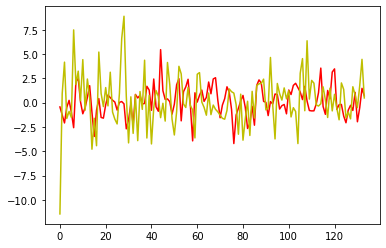

In [13]:
mkt='HK'
period = '3y'
num_samples = 10
num_epochs = 10
dependency = []
if mkt == 'HK':
    sym02 = '7200.HK'
    #sym02 = '7500.HK'
    #sym02 = '^HSI'
    list=[5,2318,1398,2628,823,700,1810,175,3690,2269]
    for i in list:
        dependency.append("{:04d}.HK".format(i))
else:
    sym02 = 'NASDX'
    #sym02 = 'QLD'
    #sym02 = 'QID'
    dependency=['FB', 'AAPL', 'AMZN', 'GOOG', 'NFLX', 'SQ', 'MTCH', 'AYX', 'ROKU', 'TTD' ]
outcome = []
df = pd.DataFrame()
print(dependency)
for sym01 in dependency:
    score,acc,tmr = mainTest(num_samples,num_epochs,sym01,sym02,period)
    outcome.append({'symbol': sym01, 'score': score, 'acc':acc, 'tmr': tmr})

sorted_list = pd.DataFrame(outcome).sort_values('score')
print(sorted_list)
good = sorted_list[sorted_list.acc > 50]
if len(good) > 0 :
    print(sum(good[['score','tmr']].apply(lambda x: x['score']*x['tmr'],axis=1))/sum(good['score']))